In [1]:
import os
import dill
import random
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from nltk.translate.bleu_score import sentence_bleu as bleu
from nltk.translate.bleu_score import SmoothingFunction

from utils import *
from seq2seq_data_loader import *

SMOOTH = SmoothingFunction()

In [2]:
loader = Seq2SeqDataLoader('mscoco/', freqCut=10000)
indexer, trainPairs, trainLens, testPairs, testLens = loader.load(specialTokenList=['EOS','SOS','PAD','UNK'])

Imposing vocabulary cut: 10000/27464

... loading training data.
... loading test data.
Done!



In [3]:
%%time

glovePath = "/usr/local/google/home/wangsu/Documents/SEQ2SEQ/glove_embeddings/glove.6B.300d.txt"
embeddings = np.zeros((indexer.size,300)) 
word2embedding = {}
count = 0
print "Reading embeddings ..."
with open(glovePath, 'r') as f:
    for line in f:
        count += 1
        line = line.split()
        word = line[0]
        embedding = np.array(line[1:], dtype=float)
        word2embedding[word] = embedding
        if count%10000==0:
            print '... processed %d lines.' % count
print "\nLoading embeddings to matrix ..."
oovSize = 0
for i in range(indexer.size-4): # special tokens.
    word = indexer.get_word(i)
    if word in word2embedding:
        embeddings[i] = word2embedding[word]
    else:
        embeddings[i] = np.zeros(300)
        oovSize += 1
print "Done (#oov = %d)" % oovSize

Reading embeddings ...
... processed 10000 lines.
... processed 20000 lines.
... processed 30000 lines.
... processed 40000 lines.
... processed 50000 lines.
... processed 60000 lines.
... processed 70000 lines.
... processed 80000 lines.
... processed 90000 lines.
... processed 100000 lines.
... processed 110000 lines.
... processed 120000 lines.
... processed 130000 lines.
... processed 140000 lines.
... processed 150000 lines.
... processed 160000 lines.
... processed 170000 lines.
... processed 180000 lines.
... processed 190000 lines.
... processed 200000 lines.
... processed 210000 lines.
... processed 220000 lines.
... processed 230000 lines.
... processed 240000 lines.
... processed 250000 lines.
... processed 260000 lines.
... processed 270000 lines.
... processed 280000 lines.
... processed 290000 lines.
... processed 300000 lines.
... processed 310000 lines.
... processed 320000 lines.
... processed 330000 lines.
... processed 340000 lines.
... processed 350000 lines.
... pr

### Model

In [9]:
class EncoderRNN(nn.Module):
    """Simple GRU encoder."""
    
    def __init__(self, inputSize, hiddenSize, embeddings=None, nLayers=2, dropout=0.1, bidirectional=True):
        """
        
        Args:
            inputSize: vocabulary size.
            hiddenSize: size of RNN hidden state.
            embeddings: pretrained, numpy.ndarray.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            bidirectional: boolean.
        """
        # inputSize: vocabulary size.
        # hiddenSize: size for both embedding and GRU hidden.
        super(EncoderRNN, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.nLayers = nLayers
        self.embedding = nn.Embedding(inputSize, hiddenSize)
        if embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embeddings))
        self.dropoutLayer = nn.Dropout(p=dropout)
        self.linear = nn.Linear(hiddenSize*2 if bidirectional else hiddenSize, hiddenSize)
        self.gru = nn.GRU(hiddenSize, hiddenSize, nLayers, dropout=dropout, bidirectional=bidirectional)
        
    
    def forward(self, inputs, inputsLen, hidden=None):
        """
        
        Args:
            inputs: Variable(torch.LongTensor()) of the shape <max-time,batch-size>.
            inputsLen: a list of input lengths with the shape <batch-size,>.
            hidden: input hidden state (initialized as None).
        """
        # inputs: <mt,bc>
        # inputsLen: <bc,> (a list).
        # hidden: <n_layer*n_direction,bc,h>
        
        
        embedded = self.embedding(inputs) # <mt,bc,h>
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, inputsLen)
            # 'packed' has a 'data' and a 'batch_sizes' field.
            #   'data' is a <sum(len),h> matrix (len is real lengths, not padded).
            #   'batch_sizes' has the number of non-zero batches at each time-step.
            # e.g. for this 'inputs'
            #    2     1     3     0     2
            #    6     8     1     6     2
            #    0     7     0     8     8
            #    6     4     2     1     1
            #    1     8     1     1     1
            #    6     1     1     1     1
            #    0     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1
            #    1     1     1     1     1  
            # 'data' = 22 = 7+5+4+3+3 (1's are pads corresponding to 'EOS').
            # 'batch_sizes' = [5, 5, 5, 3, 2, 1, 1].
        outputs,hidden = self.gru(packed, hidden)#, dropout=dropout)
            # outputs: <sum(len),h*n_direction>.
            # hidden: <n_layer*n_direction,bc,h>
        hidden = torch.cat((hidden[:self.nLayers,:,:],hidden[self.nLayers:,:,:]),dim=-1)
            # two <n_layer,bc,h> (fw/bw) concate on last dim.
            # hidden: <n_layer,bc,2h>
        hidden = self.linear(hidden)
            # shrink it down to <n_layer,bc,h>, also get info for concat bidirections.
        outputs, outputsLen = torch.nn.utils.rnn.pad_packed_sequence(outputs)
            # outputs: <mt,bc,h*n_direction>
            # outputsLen: same as the 'batch_sizes' field of 'packed'. 
        outputs = outputs[:,:,:self.hiddenSize] + outputs[:,:,self.hiddenSize:]
            # add bidirectional outputs (for attention later)
            # outputs: <mt,bc,h>
        outputs = self.dropoutLayer(outputs)
        return outputs, hidden
    

class AttentionDecoderRNN(nn.Module):
    """Simple GRU decoder (Bahdanau attention)."""
    
    def __init__(self, hiddenSize, outputSize, embeddings=None, nLayers=2, dropout=0.1, residual=True):
        """
        
        Args:
            hiddenSize: GRU hidden state size.
            outputSize: vocabulary size.
            embeddings: pretrained, numpy.ndarray.
            nLayers: number of stacked layers.
            dropout: dropout rate.
            residual: boolean, whether establish residual link or not.
        """
        super(AttentionDecoderRNN, self).__init__()
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        self.nLayers = nLayers
        self.residual = residual
        self.embedding = nn.Embedding(outputSize, hiddenSize)
        if embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embeddings))
        self.dropoutLayer = nn.Dropout(p=dropout)
        self.gru = nn.GRU(2*hiddenSize, hiddenSize, nLayers) 
        self.out = nn.Linear(2*hiddenSize, outputSize)
            # inputSize doubles because concatted context of same hiddenSize.
        self.linear = nn.Linear(hiddenSize, hiddenSize)

    def forward(self, inputs, hidden, context, encoderOutput, encoderInputsLen):
        """
        
        Args:
            inputs: inputs to decoder, of the shape <batch-size,> (1 time-step).
            hidden: <n_layers*n_directions,batch-size,hidden-size>.
            context: context vector made using attention, <batch-size,hidden-size>.
            encoderOutput: <max-time,batch-size,hidden-size>.
            NB: all are Variable(torch.LongTensor()).
        Returns:
            output: <batch-size,vocab-size>.
            hidden: <n_layers*n_directions,batch-size,hidden-size>.
            context: <batch-size,hidden-size>.
            attentionWeights: <batch-size,max-time>.
        """
            # inputs: <bc,>
            # hidden: <n_layer*n_direction,bc,h>
            # context: <bc,h>
            # encoderOutput: <mt,bc,h>  
        batchSize = inputs.size(0)
        encoderOutputLen = encoderOutput.size(0)
        embedded = self.embedding(inputs).view(1,batchSize,self.hiddenSize) # <mt=1,bc,h>
        inputs = torch.cat((embedded,context.unsqueeze(0)),2)
            # unsqueeze: <bc,h> -> <mt=1,bc,h>
            # concat: <mt,bc,h> & <mt,bc,h> @2 -> <mt,bc,2h>
        output, hidden = self.gru(inputs, hidden)#, dropout=dropout)
            # IN: <mt=1,bc,2h>, <n_layer*n_direction,bc,h>
            # OUT: <mt=1,bc,h>, <n_layer*n_direction,bc,h>
        output = self.dropoutLayer(output)
        hidden = hidden + embedded if self.residual else hidden
        attentionWeights = Variable(torch.zeros(batchSize,encoderOutputLen)).cuda()
        for b in range(batchSize):
            rawAttentionWeight = torch.mm(self.linear(encoderOutput[:,b,:]), 
                                          hidden[:,b,:][-1].unsqueeze(1)).squeeze()
                # op1. linear transformation on encoderOutput (dot energy).
                # op2. select <mt,h> and <1,h> slices (from <mt,bc,h> and <1,bc,h>).
                # op3. sel hidden last dim <h,> and expand -> <mt,h> & <h,1> now.
                # op4. matmul -> <mt,1>.
                # op5. squeeze -> <mt,>
            if b>0:
                mask = Variable(torch.FloatTensor(np.array([1 if i<=encoderInputsLen[b] else 0 for i in range(encoderOutputLen)]))).cuda()
                    # encoder outputlen is the largest length in the current input batch.
                    # <= rather than <: including EOS
                rawAttentionWeight = F.softmax(rawAttentionWeight, dim=-1) * mask
                    # first softmax to get rid of negative numbers
            attentionWeights[b] = F.softmax(rawAttentionWeight, dim=-1)
                # normalize to get a distribution.
            # result: <bc,mt> attention matrix, normalized along mt.
        multiDiag = Variable(torch.eye(batchSize).expand(self.hiddenSize,batchSize,batchSize),
                             requires_grad=False).cuda()
            # op1. eye -> <bc,bc> diagonal matrix mask.
            # op2. expand -> <h,bc,bc>, same shape as attended encoderOutput.
            # op3. Variable/grad=false: same type as attended encoderOutput.
        context = (torch.matmul(attentionWeights, encoderOutput.permute(2,0,1)) * multiDiag).sum(dim=2).transpose(0,1)
            # op1. masking -> <h,bc,bc>, with the last 2 dims only have non-zero diag elems.
            # op2. compress 1 bc dimension (useless, because its diag).
            # op3. <h,bc> -> <bc,h>, keep input shape.
        output = output.squeeze(0)
            # output squeeze: <mt=1,bc=1,h> -> <bc,h>, to concat with context
        output = F.log_softmax(F.tanh(self.out(torch.cat((output,context),1))),dim=-1)
            # concat: <bc,h> & <bc,h> @1 -> <bc,2h>
            # linear->tahn/out: <bc,2h> * <2h,vocab> -> <bc,vocab>
            # softmax: along dim=-1, i.e. vocab.  
        return output, hidden, context, attentionWeights
            # full output for visualization:
            #   output: <bc,vocab>
            #   hidden: <n_layer*n_direction,bc,h>
            #   context: <bc,h>
            #   attentionWeights: <bc,mt> 

class Seq2Seq:
    """Encoder-Decoder model with Bahdanau attention, stacking and residual links."""
    
    def __init__(self, indexer, trainPairs, trainLens, testPairs, testLens,
                 embeddings=None,
                 batchSize=5, hiddenSize=10,
                 nLayers=2, dropout=0.1, residual=True, bidirectional=True, 
                 lr=1e-4, lrDecay=0.95, lrDecayFreq=100,
                 l2Reg=0.5,
                 enforcingRatio=0.5, clip=5.0,
                 maxDecodingLen=10,
                 resultSavePath='toy/results.txt'):
        """
        
        Args:
            indexer: an Indexer object.
            trainPairs, testPairs: each is a list of pairs of word index list.
            trainLens, testLens: each is a list of pairs of length of word index list.
            batchSize: int. (default=5)
            hiddenSize: int. (default=10)
            nLayers: number of GRU stacking layers. (default=2)
            dropout: dropout rate. (default=0.1)
            residual: boolean, whether to establish residual links. (default=True)
            bidirectional: boolean.
            lr: learning rate, float. (default=1e-4 with Adam)
            lrDecay: rate at which lr drops per m batches.
            lrDecayFreq: the number of batches per lr decay.
            l2Reg: ridge regression.
            enforcingRatio: the percentage of teacher-enforced training. (default=0.5)
            clip: gradient clip cap, float. (default=5.0)
            maxDecodingLen: max #tokens generated by decoder before stopping.
            resultSavePath: (input,prediction,target) sentence triples file path.
        """
        self.indexer = indexer
        self.trainIter = DataIterator(indexer, trainPairs, trainLens, maxTargetLen=maxDecodingLen)
        self.testIter = DataIterator(indexer, testPairs, testLens, maxTargetLen=maxDecodingLen)
        self.embeddings = embeddings
        self.batchSize = batchSize
        self.hiddenSize = hiddenSize
        self.nLayers = nLayers
        self.dropout = dropout
        self.residual = residual
        self.bidirectional = bidirectional
        self.lr = lr
        self.lrDecay = lrDecay
        self.lrDecayFreq = lrDecayFreq
        self.l2Reg = l2Reg
        self.enforcingRatio = enforcingRatio
        self.clip = clip
        self.maxDecodingLen = maxDecodingLen
        self.resultSavePath = resultSavePath
        self._build_model()
    
    def _build_model(self):
        """Specify computational graph."""
        
        
        self.encoder = EncoderRNN(self.indexer.size, self.hiddenSize, self.embeddings,
                                  nLayers=self.nLayers, dropout=self.dropout, bidirectional=self.bidirectional).cuda()
        self.decoder = AttentionDecoderRNN(self.hiddenSize, self.indexer.size, self.embeddings,
                                           nLayers=self.nLayers, dropout=self.dropout, residual=self.residual).cuda()
        self.encoderOptim = optim.Adam(self.encoder.parameters(), self.lr, weight_decay=self.l2Reg)
        self.decoderOptim = optim.Adam(self.decoder.parameters(), self.lr, weight_decay=self.l2Reg)
        self.criterion = nn.NLLLoss()
    
    def _model_config(self):
        return 'Vocab Size = ' + str(self.indexer.size) + '\n' + \
               'Train/Test Size = ' + str(self.trainIter.size)+'/'+str(self.testIter.size) + '\n' + \
               'batchSize = ' + str(self.batchSize) + '; hiddenSize = ' + str(self.hiddenSize) + '\n' + \
               'nLayers = ' + str(self.nLayers) + '; dropout = ' + str(self.dropout) + '\n' + \
               'residual = ' + str(self.residual) + '; learning rate = ' + str(self.lr) + '\n' + \
               'learning rate decay = ' + str(self.lrDecay) + ' per ' + str(self.lrDecayFreq) + ' batches/steps\n' + \
               'regularization (l2) = ' + str(self.l2Reg) + '\n' + \
               'teacher enforce ratio = ' + str(self.enforcingRatio) + '; clip = ' + str(self.clip) + '\nn'
    
    def _lr_decay(self, encOptim, decOptim):
        self.lr *= self.lrDecay
        for paramGroup in encOptim.param_groups:
            paramGroup['lr'] = self.lr
        for paramGroup in decOptim.param_groups:
            paramGroup['lr'] = self.lr
        return encOptim, decOptim
    
    def _train_step(self):
        """One step of training."""
        inputs, inputsLen, targets, targetsLen = self.trainIter.random_batch(self.batchSize)
        inputs, targets = inputs.cuda(), targets.cuda()
        self.encoderOptim.zero_grad()
        self.decoderOptim.zero_grad()
        loss = 0
        # Run encoder
        
#         print type(inputs)
#         assert 1==0
        
        encoderHidden = None
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen, encoderHidden)    
        # Run decoder
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*self.batchSize)).cuda()
        decoderContext = Variable(torch.zeros(self.batchSize,self.decoder.hiddenSize)).cuda()
        decoderHidden = encoderHidden
        enforce = random.random() < self.enforcingRatio
        currDecodingLen = min(max(targetsLen),self.maxDecodingLen)
        decoderOutputAll = Variable(torch.zeros(currDecodingLen,self.batchSize,self.decoder.outputSize)).cuda()
            # <mt-max,bc,vocab>
        mask = torch.LongTensor([1]*self.batchSize).cuda()
            # start with 1, a cell turns 0 to mask out generation after an EOS is seen.
        for di in range(currDecodingLen):
            decoderOutput,decoderHidden,decoderContext,attentionWeights = self.decoder(decoderInput,
                                                                                       decoderHidden,
                                                                                       decoderContext, 
                                                                                       encoderOutput,
                                                                                       inputsLen)
            decoderOutputAll[di] = decoderOutput
            if enforce:
                decoderInput = targets[di] # <== targets is <mt,bc>
            else:
                topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
                topIndices = topIndices.squeeze()# topIndices = <bc,>
                for b in range(self.batchSize):
                    if topIndices[b] == 0: # EOS
                        mask[b] = 0
                topIndices = topIndices * mask
                decoderInput = Variable(topIndices).cuda()     
        # Batch cross entropy
            # requires arg1/pred = <#entries,vocab>, arg2/target = <#entries,>
        decoderOutputAll = decoderOutputAll.view(-1, self.decoder.outputSize)
            # reshape to <mt*bc,vocab>
        targets = targets[:currDecodingLen,:].contiguous().view(-1)
            # reshape to <mt*bc>
        loss = self.criterion(decoderOutputAll, targets)
        # Backprop
        loss.backward()
        torch.nn.utils.clip_grad_norm(self.encoder.parameters(), self.clip)
        torch.nn.utils.clip_grad_norm(self.decoder.parameters(), self.clip)
        self.encoderOptim.step()
        self.decoderOptim.step()
        return loss.data[0] / targetsLen.sum()
    
    def train(self, nEpochs=1, epochSize=100, printEvery=5):
        """Train on loaded data upon construction.
        
        Args:
            nEpochs: number of epochs.
            epochSize: number of batches trained in an epoch.
            printEvery: frequency of results report.
        """
        globalStep = 0
        averageLoss = 0
        start = time.time()
        for e in range(nEpochs):
            epochLoss = 0
            for step in range(epochSize):
                loss = self._train_step()
                if step!=0 and step%printEvery==0:
                    print("Step %d average loss = %.4f (time: %.2f)" % (step, loss, # batch mean.
                                                                        time.time()-start))
                    start = time.time()
                epochLoss += loss
                globalStep += 1
                if globalStep%self.lrDecayFreq==0:
                    print '  [LR DECAY] from %.10f to %.10f at step %d' % (self.lr, self.lr*self.lrDecay, globalStep)
                    self.encoderOptim, self.decoderOptim = self._lr_decay(self.encoderOptim, self.decoderOptim)
            epochLoss /= epochSize
            averageLoss += epochLoss
            print("\nEpoch %d loss = %.4f\n" % (e+1,epochLoss))
            averageBleu = self.evaluate_random(size=self.batchSize, saveResults=False, printResults=True)
        averageLoss /= nEpochs
        print("\nGrand average loss = %.4f\n" % averageLoss) 
        
    def _clear_special_tokens(self, words):
        """Clear all the PAD, UNK, EOS to avoid inflated BLEU.
        
        Args:
            words: a list of tokens.
        Returns:
            a list of tokens which are not special tokens.
        """
        return [word for word in words if word not in set(["PAD","UNK","EOS","SOS"])]

    def evaluate_pair(self, predWords, targetWords):
        """Compute the BLEU score of a prediction given a reference.
        
        Args:
            predWords: predicted words (a list of strings).
            targetWords: reference, same type as preWords.
        Returns:
            The BLEU score (uses = nltk.translate.bleu_score.sentence_bleu).
        """
        return bleu([self._clear_special_tokens(targetWords)], 
                     self._clear_special_tokens(predWords), smoothing_function=SMOOTH.method3)

    def _print_heatmap(self, attentionWeightsAll, inputs, predictions, targets):
        """Plot alignment heatmaps.
        
        Args:
            attentionWeightsAll: shape <bc,mt-dec=maxDecodingLen,mt-enc=inputsLen>
            inputs: <bc,mt-enc=inputsLen>
            predictions: <bc,mt-dec=maxDecodingLen>
            targets: <bc,mt-dec=targetsLen>
            NB: all types = numpy.ndarray.
        """

        print '=========== HEATMAPS =========='
        for aw,iw,pw,tw in zip(attentionWeightsAll,inputs,predictions,targets): # <mt,vocab>
            _, ax = plt.subplots()
            xticks = self.indexer.to_words(iw)
            yticks = [p+'-'+t for p,t in zip(self.indexer.to_words(pw),self.indexer.to_words(tw))]
            ax = sns.heatmap(aw, xticklabels=xticks, yticklabels=yticks)
            ax.xaxis.tick_top()
            plt.show()
        print '===============================\n\n'
        
    def evaluate_random(self, size, saveResults, printResults=True, endOfEpochPlot=True):
        """Randomly evaluate samples from the test set (which is loaded upon construction).
        
        Args:
            size: number of samples evaluated (as a single batch).
            printResults: print input, prediction and gold translation to console. (default=True)
        Returns:
            The average BLEU score in the batch.
        """
        self.encoder.eval()
        self.decoder.eval()
        inputs, inputsLen, targets, targetsLen = self.testIter.random_batch(size)
        inputs, targets = inputs.cuda(), targets.cuda()
        # Run encoder
        encoderHidden = None
        encoderOutput, encoderHidden = self.encoder(inputs, inputsLen, encoderHidden)
        # Run decoder
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*size)).cuda()
        decoderContext = Variable(torch.zeros(size,self.decoder.hiddenSize)).cuda()
        decoderHidden = encoderHidden
        predictions = []
        attentionWeightsAll = []
        for di in range(self.maxDecodingLen):
            decoderOutput,decoderHidden,decoderContext,attentionWeights = self.decoder(decoderInput,
                                                                                       decoderHidden,
                                                                                       decoderContext, 
                                                                                       encoderOutput,
                                                                                       inputsLen)
            attentionWeightsAll.append(attentionWeights)
            topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
            decoderInput = Variable(topIndices.squeeze()).cuda() # <bc,1> -> <bc,>
            predictions.append(topIndices.view(-1).cpu().numpy())
        attentionWeightsAll = np.array([aw.data.cpu().numpy() for aw in attentionWeightsAll])
        attentionWeightsAll = attentionWeightsAll.swapaxes(0,1) # <mt-dec,bc,mt-enc> -> <bc,mt-dec,mt-enc> 
        inputs = inputs.data.cpu().numpy().transpose()
        predictions = np.array(predictions).transpose() # <mt,bc> -> <bc,mt>
        targets = targets.data.cpu().numpy().transpose()
        
        if endOfEpochPlot:
            self._print_heatmap(attentionWeightsAll, inputs, predictions, targets)
        bleuList = []
        results = []
        for i,(input,pred,target) in enumerate(zip(inputs,predictions,targets)):
            inputWords = self._clear_special_tokens(self.indexer.to_words(input))
            predWords = self._clear_special_tokens(self.indexer.to_words(pred))
            targetWords = self._clear_special_tokens(self.indexer.to_words(target))
            bleuCurr = self.evaluate_pair(predWords, targetWords)
            bleuList.append(bleuCurr)
            inputSent = ' '.join(inputWords)
            predSent = ' '.join(predWords)
            targetSent = ' '.join(targetWords)
            results.append([inputSent, predSent, targetSent])
            if printResults:
                print("Example %d" % (i+1))
                print("INPUT >> %s" % inputSent)
                print("PRED >> %s" % predSent)
                print("TRUE >> %s" % targetSent)
                print("[BLEU] %.2f\n" % bleuCurr)
        averageBleu = np.mean(bleuList)
        if saveResults:
            return averageBleu, results
        return averageBleu

    def evaluate(self, nBatches=10, saveResults=True):
        """Randomly evaluate a given number of batches.
        
        Args:
            nBatches: the number of random batches to be evaluated.
        """
        averageBleuList = []
        for i in range(nBatches):
            if saveResults:
                averageBleu, results = self.evaluate_random(self.batchSize, saveResults, printResults=False)
                averageBleuList.append(averageBleu)
                with open(self.resultSavePath, 'a') as f:
                    if i==0:
                        f.write(self._model_config())
                        f.write('=================================\n')
                    for input,pred,target in results:
                        f.write('INPUT  >> ' + input + '\n')
                        f.write('PRED   >> ' + pred + '\n')
                        f.write('TARGET >> ' + target + '\n\n')
            else:
                averageBleuList.append(self.evaluate_random(self.batchSize, saveResults, printResults=False))
        message = "Average BLEU score over %d examples is %.4f" % (self.batchSize*nBatches, 
                                                                   np.mean(averageBleuList))
        with open(self.resultSavePath, 'a') as f:
            f.write('=================================\n')
            f.write(message)
        print message
            
    def evaluate_given(self, sent, maxLen=20):
        """Evaluate a give sentence.
        
        Args:
            sentence: a single string. OOVs are treated as UNKs.
            maxLen: the max number of decoding steps.
        """
        sent = sent.split()
        sentCode = [self.indexer.get_index(word,add=False) for word in sent]
        if any(i==-1 for i in sentCode):
            raise Exception("This sentence contains out of vocabulary words!")
        input = Variable(torch.LongTensor(sentCode)).cuda().view(-1,1)
        inputLen = np.array([len(sentCode)])
        # Run encoder
        encoderHidden = None
        encoderOutput, encoderHidden = self.encoder(input, inputLen, encoderHidden)
        # Run decoder
        decoderInput = Variable(torch.LongTensor([self.indexer.get_index('SOS')]*1)).cuda()
        decoderContext = Variable(torch.zeros(1,self.decoder.hiddenSize)).cuda()
        decoderHidden = encoderHidden
        pred = []
        for di in range(maxLen):
            decoderOutput,decoderHidden,decoderContext,attentionWeights = self.decoder(decoderInput,
                                                                                       decoderHidden,
                                                                                       decoderContext, 
                                                                                       encoderOutput)
            topValues,topIndices = decoderOutput.data.topk(1) # <bc,1>
            decoderInput = Variable(topIndices.squeeze()).cuda() # <bc,1> -> <bc,>
            predIndex = topIndices.view(-1).cpu().numpy()[0]
            if predIndex == self.indexer.get_index('EOS'):
                break
            pred.append(predIndex)
        print("INPUT >> %s" % ' '.join(sent))
        print("PRED >> %s\n" % ' '.join(self.indexer.to_words(pred))) 
        

Step 50 average loss = 0.0223 (time: 13.80)
Step 100 average loss = 0.0228 (time: 13.86)
Step 150 average loss = 0.0216 (time: 13.63)
Step 200 average loss = 0.0238 (time: 13.31)
Step 250 average loss = 0.0227 (time: 13.83)
Step 300 average loss = 0.0235 (time: 13.76)
Step 350 average loss = 0.0236 (time: 13.92)
Step 400 average loss = 0.0238 (time: 13.92)
Step 450 average loss = 0.0242 (time: 13.99)
Step 500 average loss = 0.0227 (time: 13.86)
Step 550 average loss = 0.0231 (time: 13.97)
Step 600 average loss = 0.0232 (time: 13.85)
Step 650 average loss = 0.0217 (time: 13.83)
Step 700 average loss = 0.0254 (time: 14.05)
Step 750 average loss = 0.0209 (time: 14.04)
Step 800 average loss = 0.0245 (time: 13.91)
Step 850 average loss = 0.0234 (time: 13.83)
Step 900 average loss = 0.0232 (time: 13.94)
Step 950 average loss = 0.0227 (time: 14.22)

Epoch 1 loss = 0.0233

=========== HEATMAPS ==========


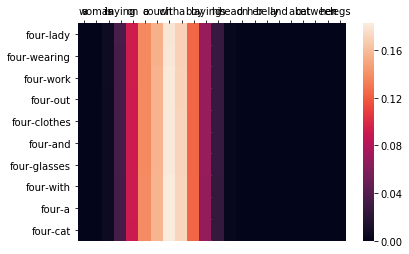

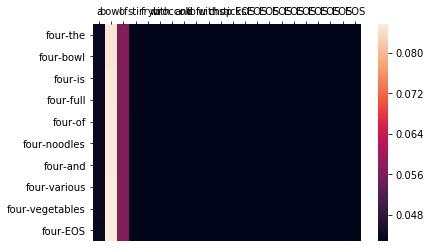

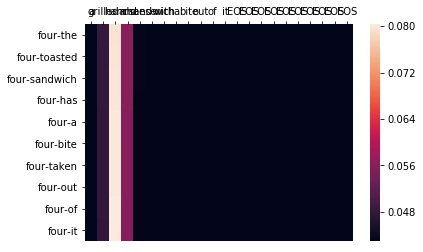

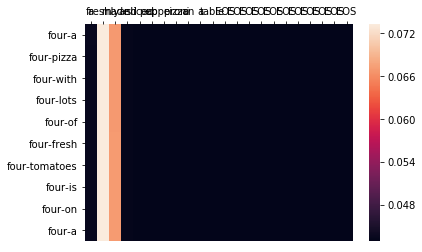

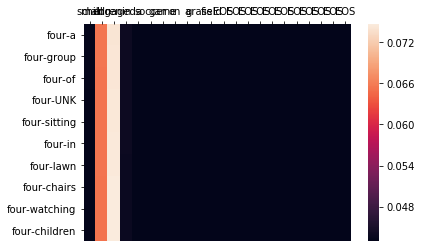

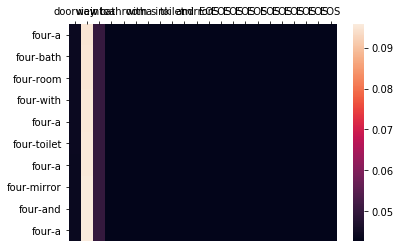

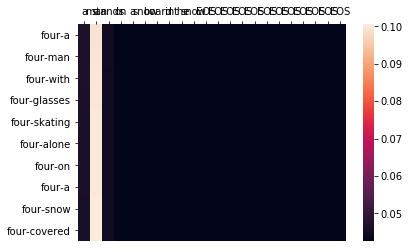

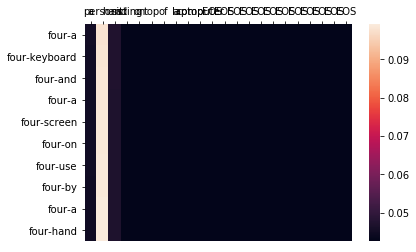

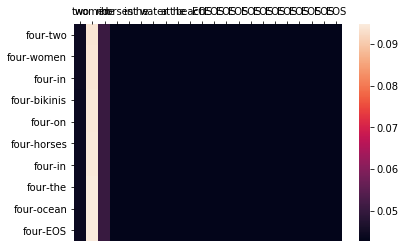

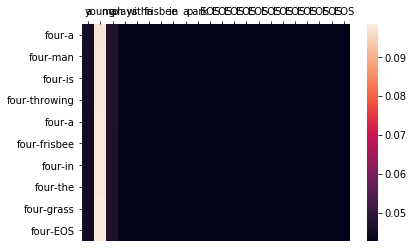

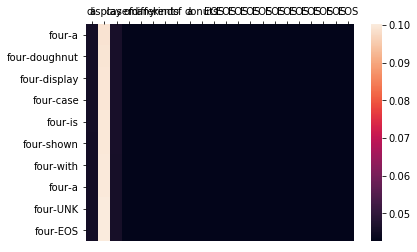

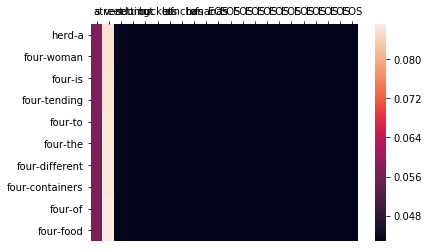

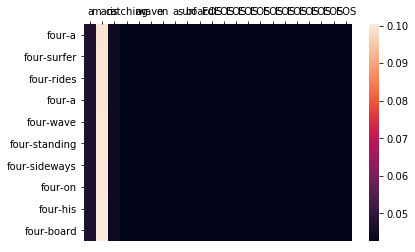

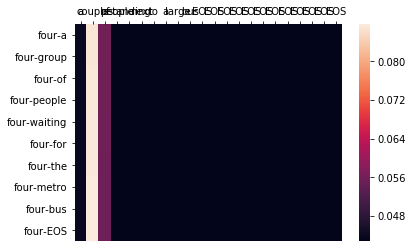

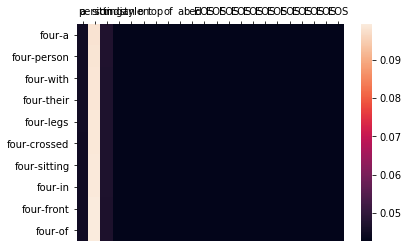

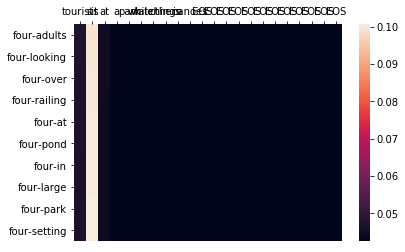

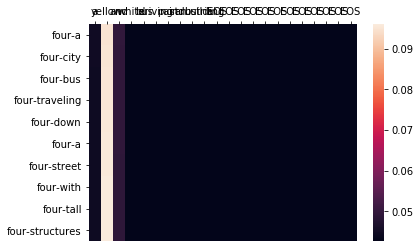

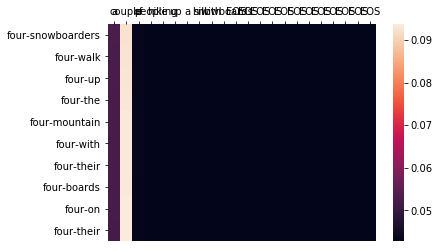

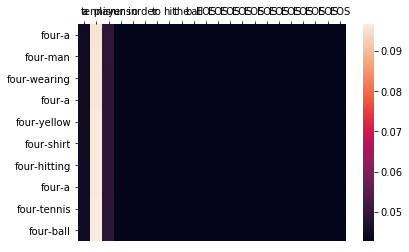

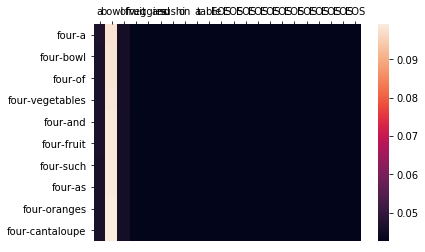

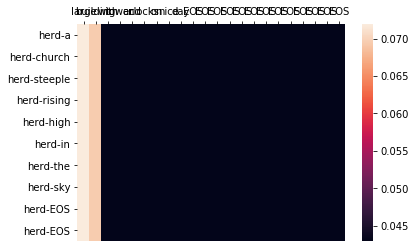

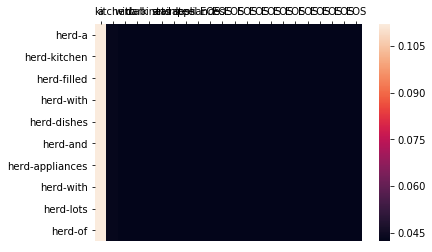

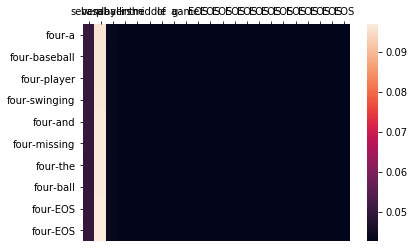

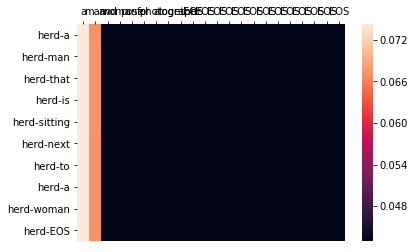

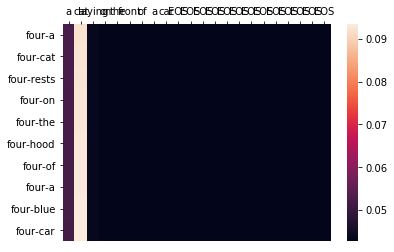

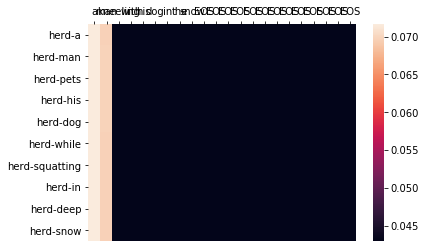

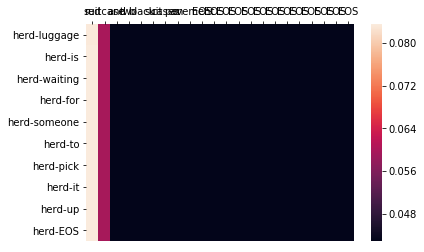

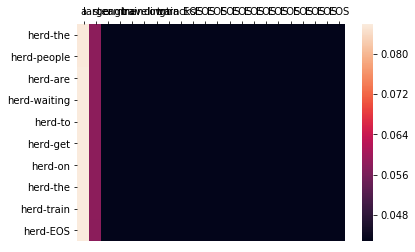

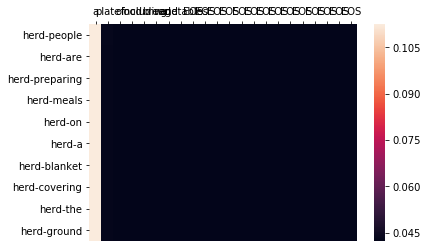

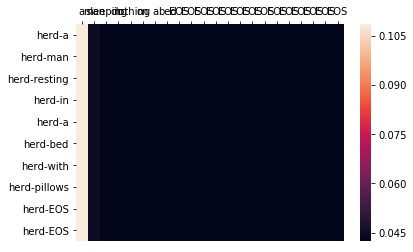

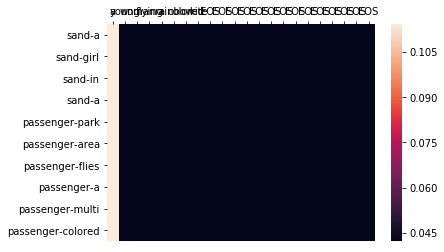

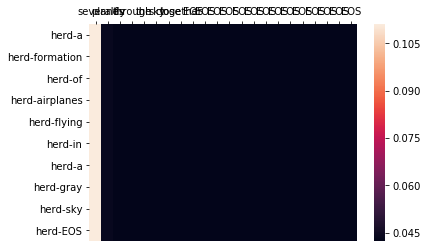



Example 1
INPUT >> a woman is laying on a couch with a boy laying his head on her belly and a cat between her legs
PRED >> four four four four four four four four four four
TRUE >> lady wearing work out clothes and glasses with a cat
[BLEU] 0.00

Example 2
INPUT >> a bowl of stir fry with broccoli and tofu with chop sticks
PRED >> four four four four four four four four four four
TRUE >> the bowl is full of noodles and various vegetables
[BLEU] 0.00

Example 3
INPUT >> a grilled ham and cheese sandwich with a bite out of it
PRED >> four four four four four four four four four four
TRUE >> the toasted sandwich has a bite taken out of it
[BLEU] 0.00

Example 4
INPUT >> a freshly made and sliced up pepperoni pizza on a table
PRED >> four four four four four four four four four four
TRUE >> a pizza with lots of fresh tomatoes is on a
[BLEU] 0.00

Example 5
INPUT >> small children engaged in a soccer game on a grass field
PRED >> four four four four four four four four four four
TRUE >> a

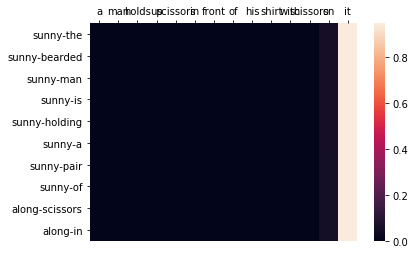

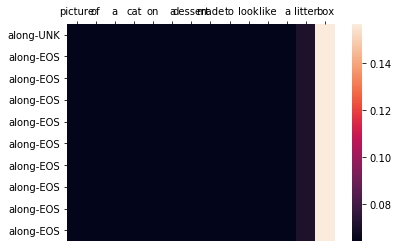

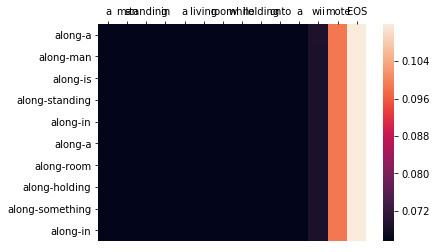

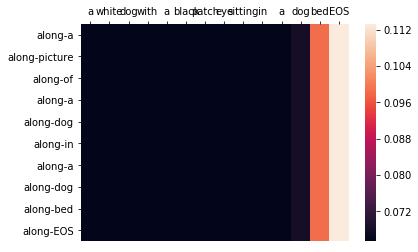

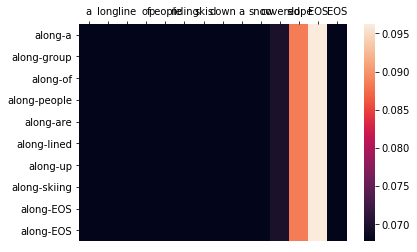

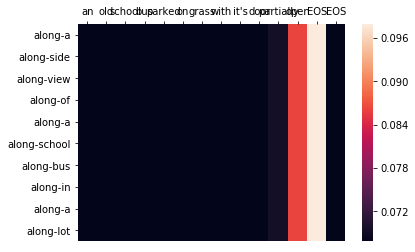

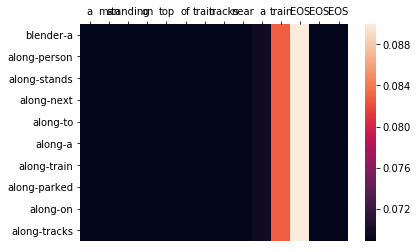

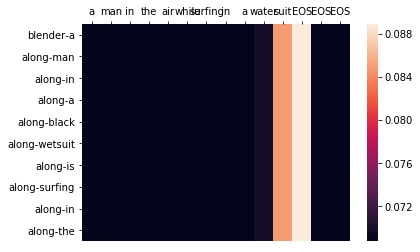

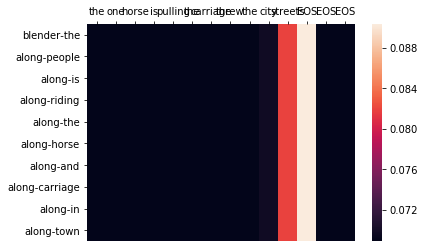

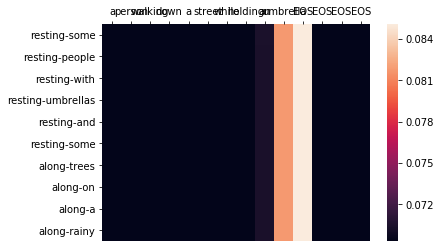

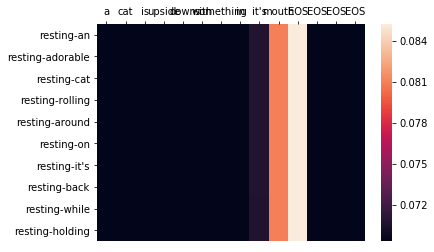

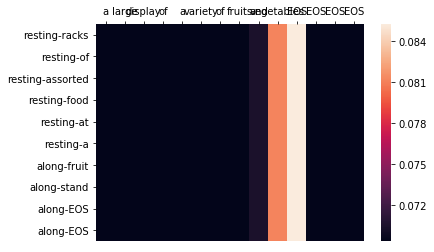

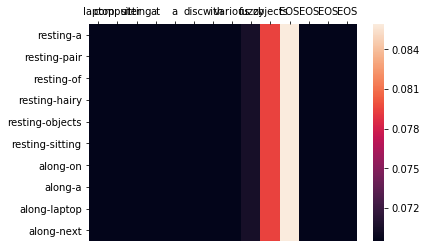

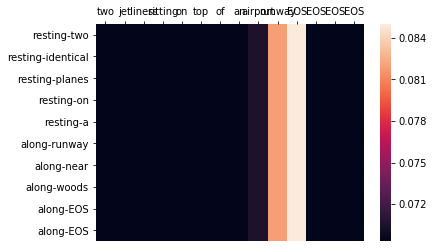

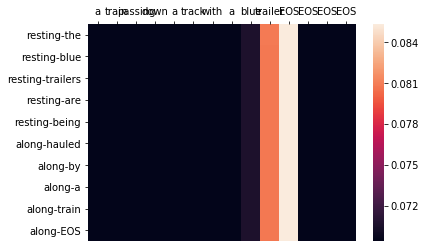

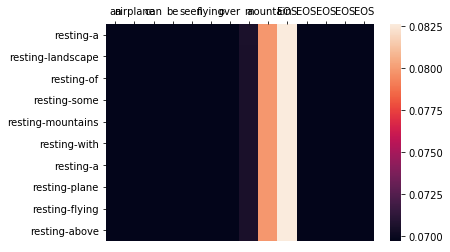

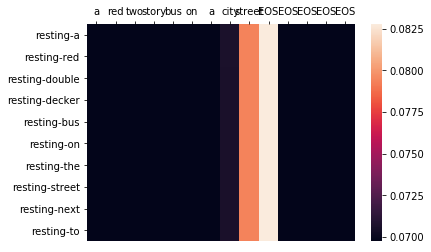

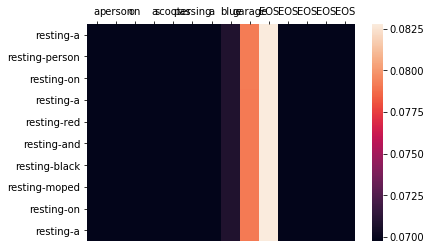

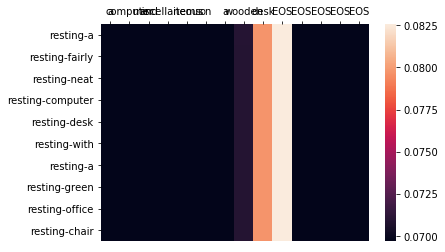

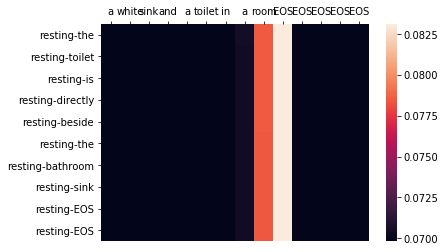

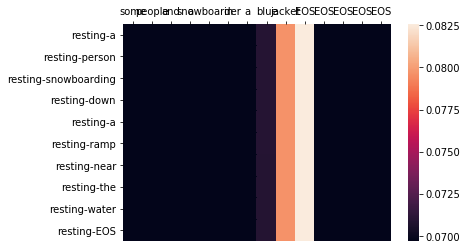

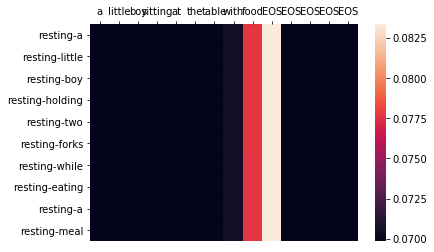

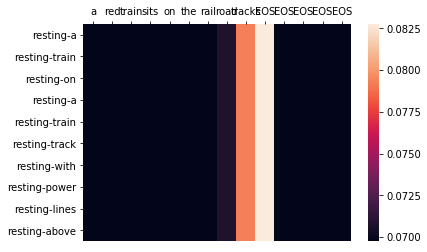

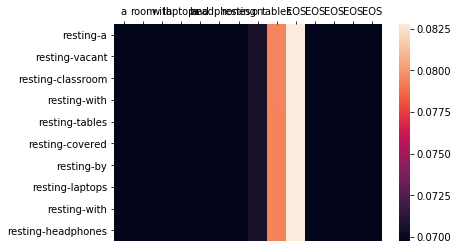

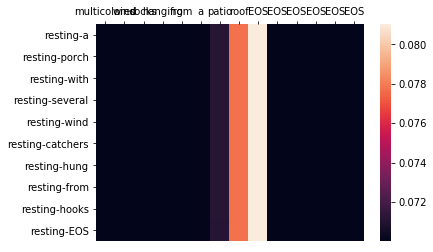

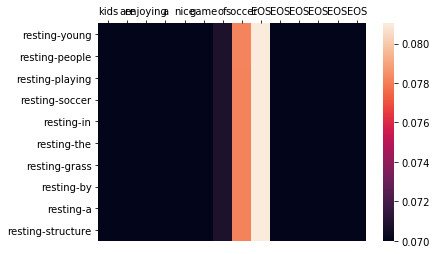

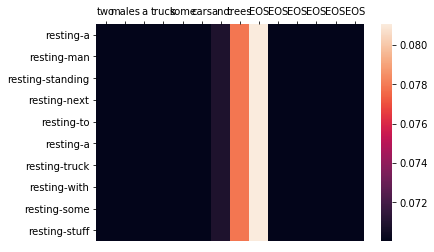

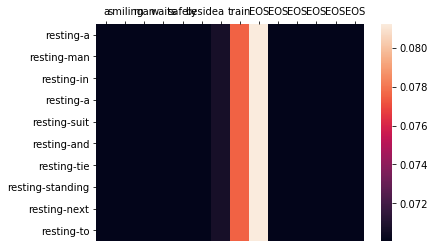

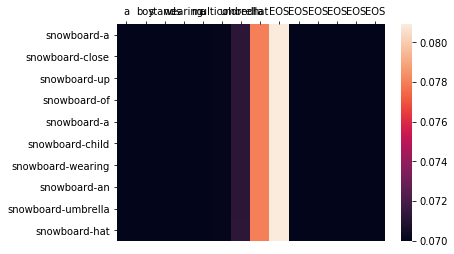

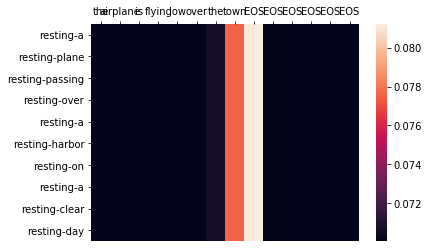

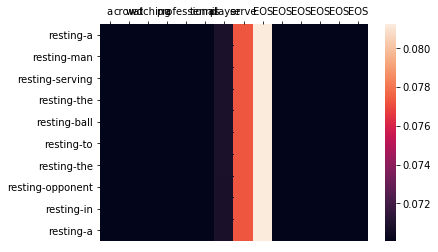

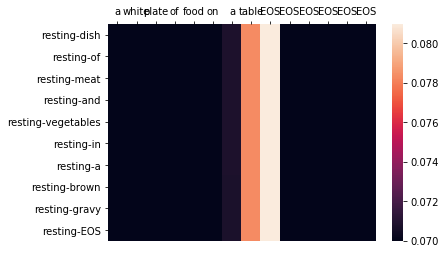



Example 1
INPUT >> a man holds up scissors in front of his shirt with scissors on it
PRED >> sunny sunny sunny sunny sunny sunny sunny sunny along along
TRUE >> the bearded man is holding a pair of scissors in
[BLEU] 0.00

Example 2
INPUT >> picture of a cat on a dessert made to look like a litter box
PRED >> along along along along along along along along along along
TRUE >> 
[BLEU] 0.00

Example 3
INPUT >> a man standing in a living room while holding onto a wii mote
PRED >> along along along along along along along along along along
TRUE >> a man is standing in a room holding something in
[BLEU] 0.00

Example 4
INPUT >> a white dog with a black patch eye sitting in a dog bed
PRED >> along along along along along along along along along along
TRUE >> a picture of a dog in a dog bed
[BLEU] 0.00

Example 5
INPUT >> a long line of people riding skis down a snow covered slope
PRED >> along along along along along along along along along along
TRUE >> a group of people are lined up skii

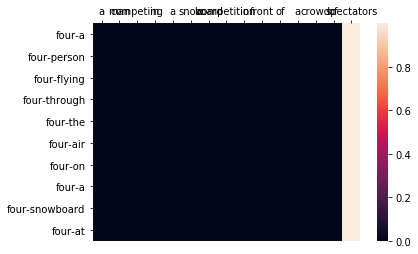

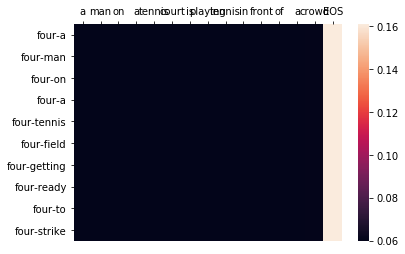

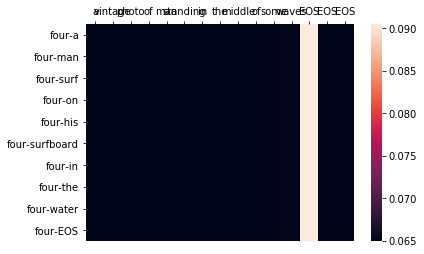

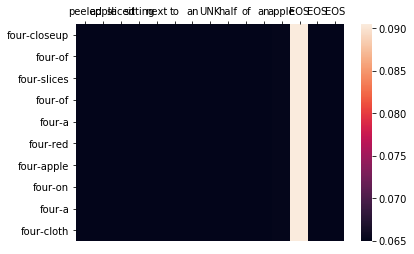

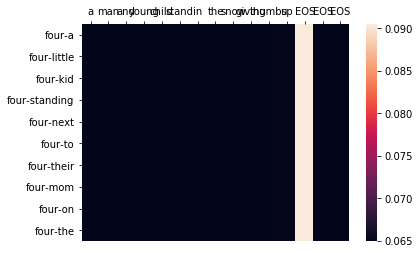

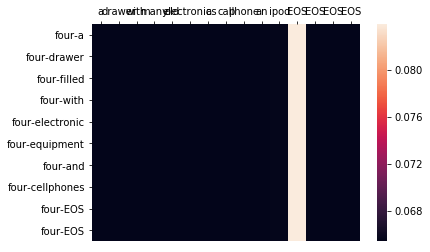

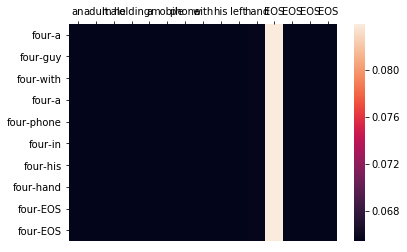

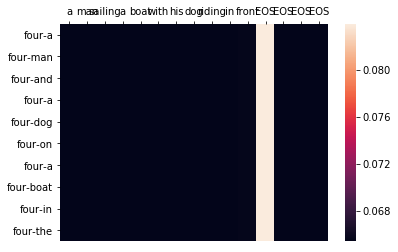

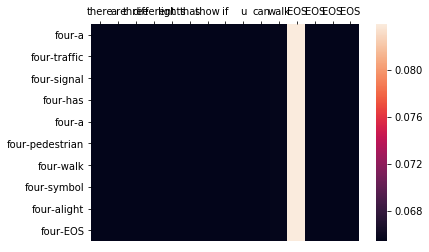

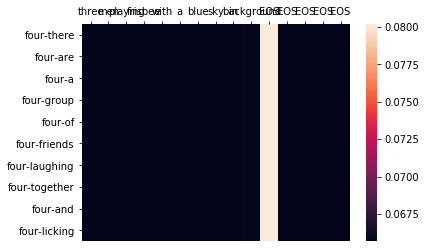

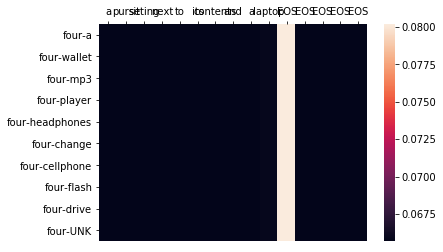

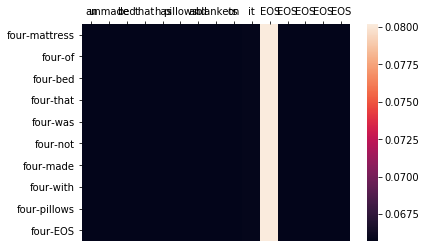

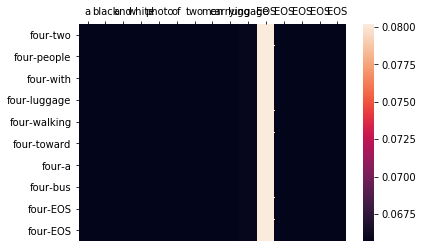

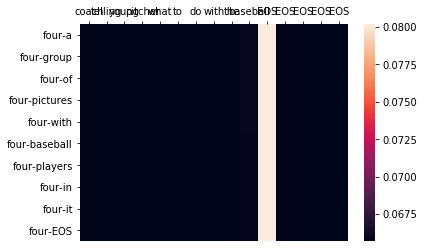

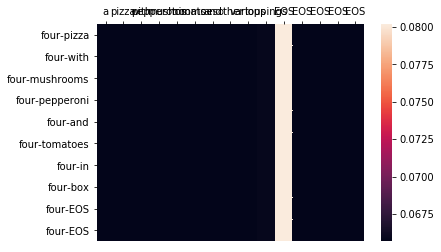

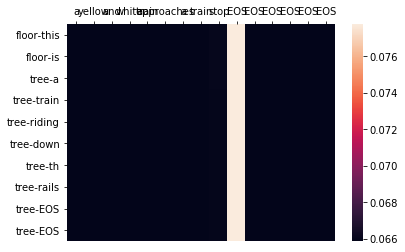

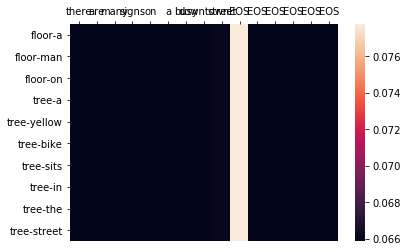

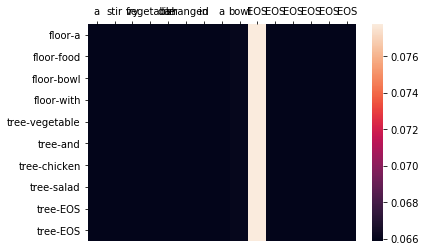

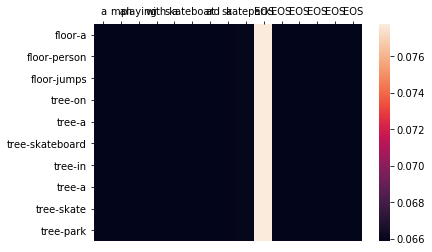

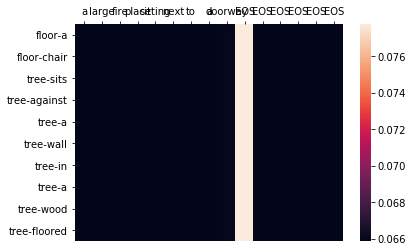

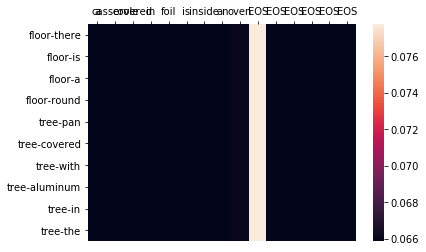

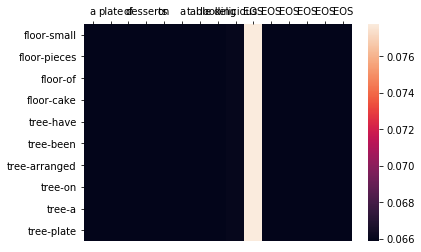

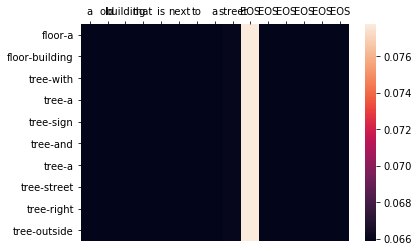

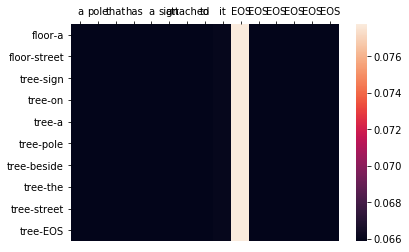

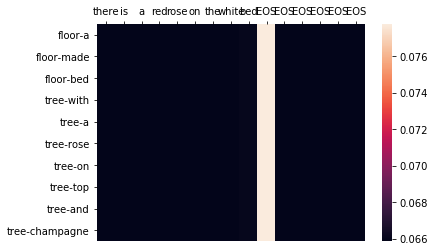

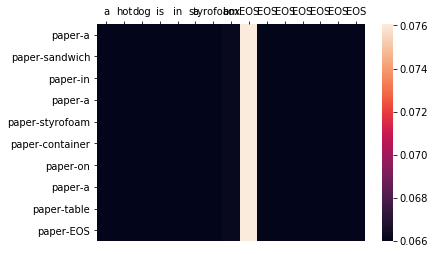

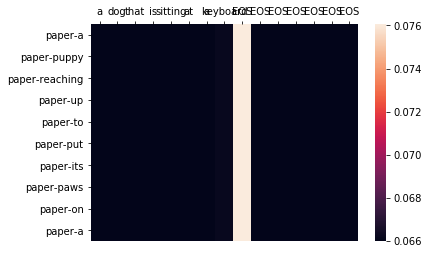

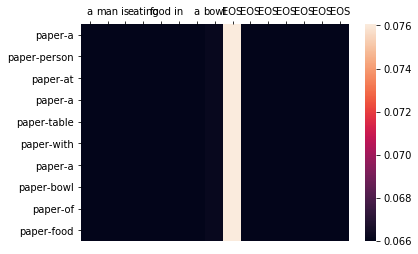

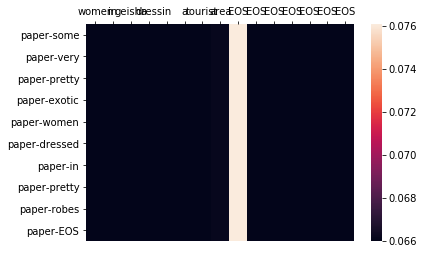

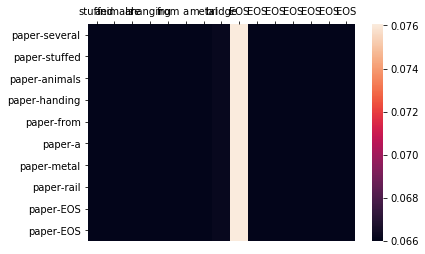

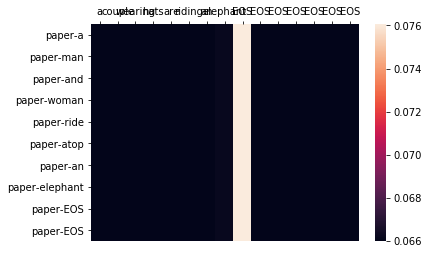

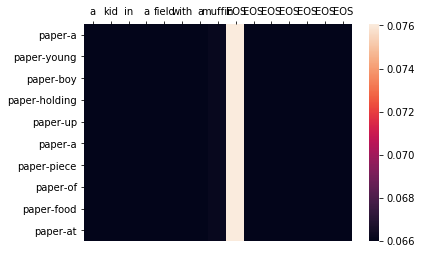



Example 1
INPUT >> a man competing in a snow board competition in front of a crowd of spectators
PRED >> four four four four four four four four four four
TRUE >> a person flying through the air on a snowboard at
[BLEU] 0.00

Example 2
INPUT >> a man on a tennis court is playing tennis in front of a crowd
PRED >> four four four four four four four four four four
TRUE >> a man on a tennis field getting ready to strike
[BLEU] 0.00

Example 3
INPUT >> a vintage photo of man standing in the middle of some waves
PRED >> four four four four four four four four four four
TRUE >> a man surf on his surfboard in the water
[BLEU] 0.00

Example 4
INPUT >> peeled apple sliced sitting next to an half of an apple
PRED >> four four four four four four four four four four
TRUE >> closeup of slices of a red apple on a cloth
[BLEU] 0.00

Example 5
INPUT >> a man and young child stand in the snow giving thumbs up
PRED >> four four four four four four four four four four
TRUE >> a little kid standing nex

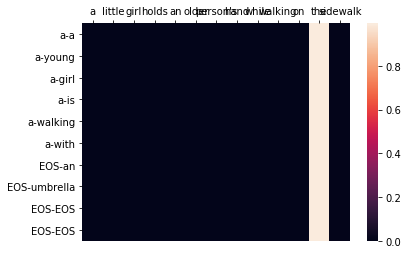

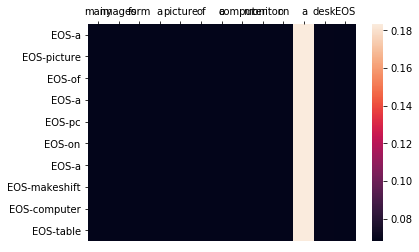

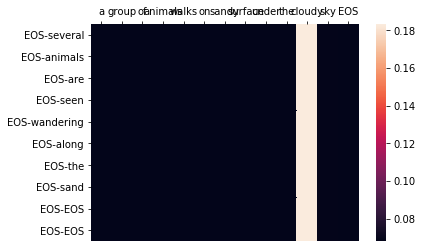

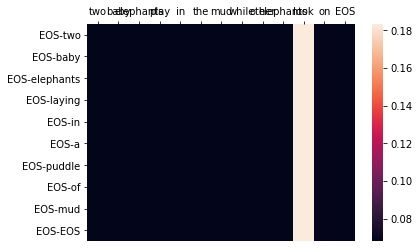

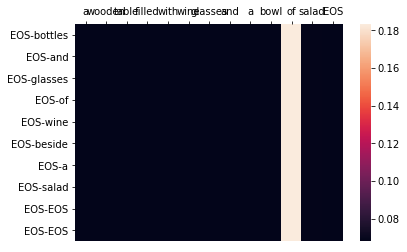

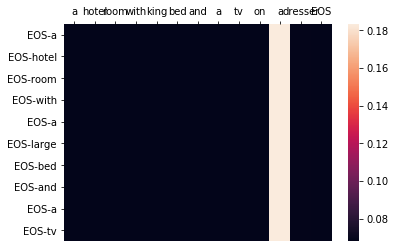

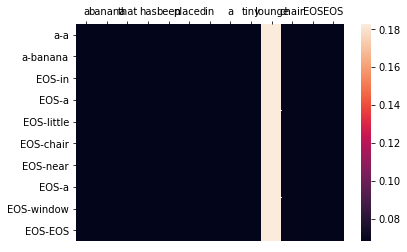

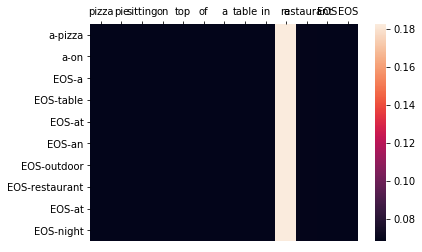

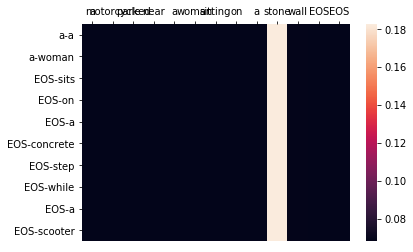

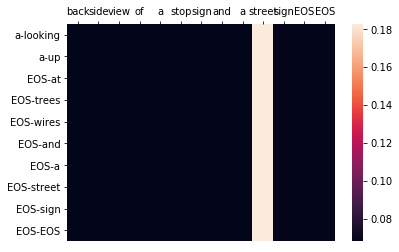

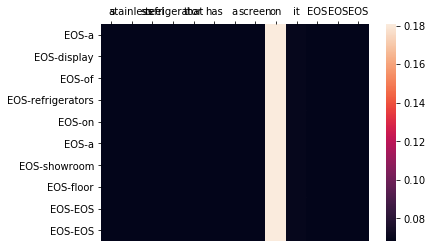

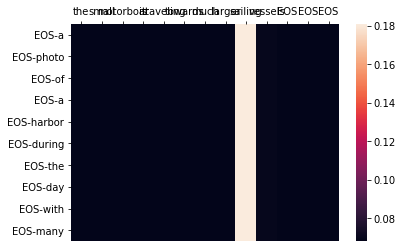

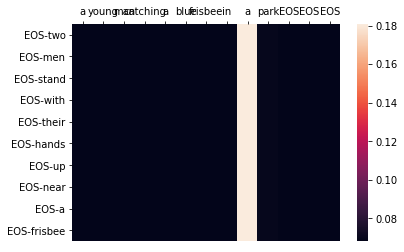

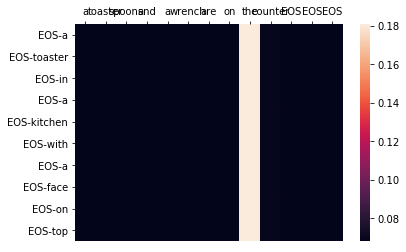

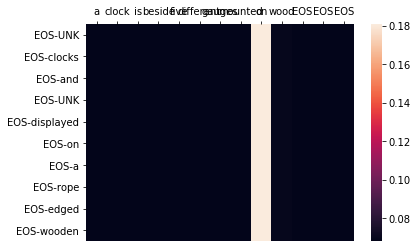

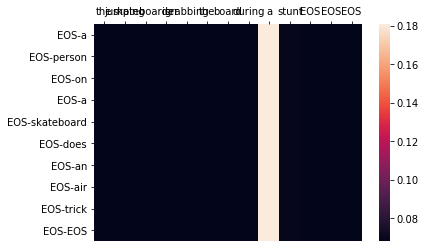

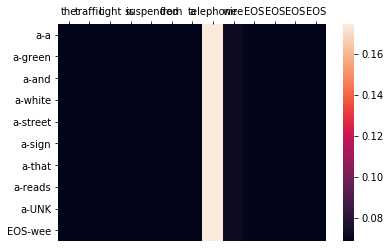

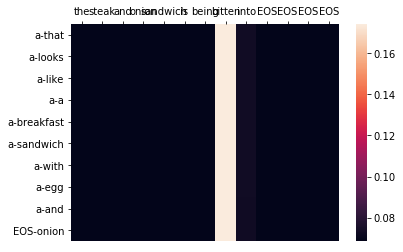

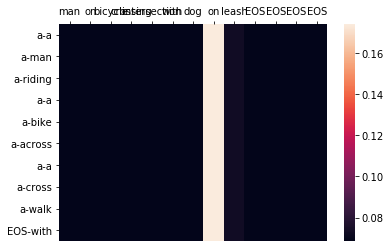

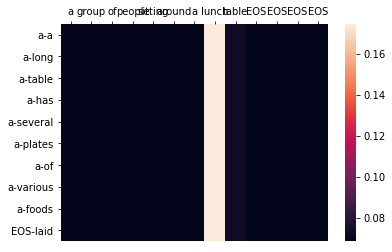

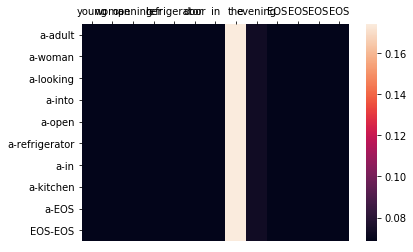

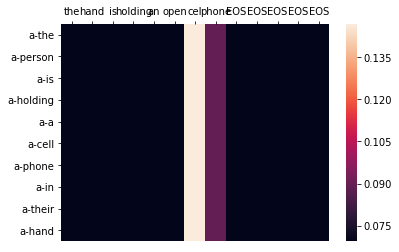

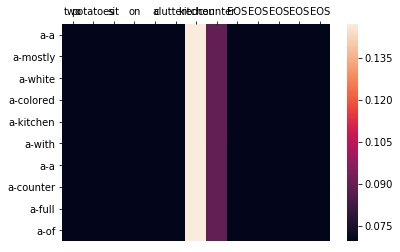

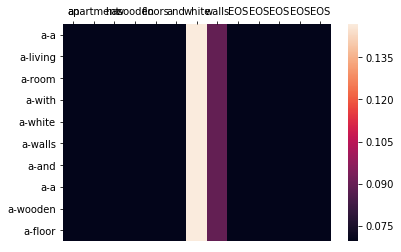

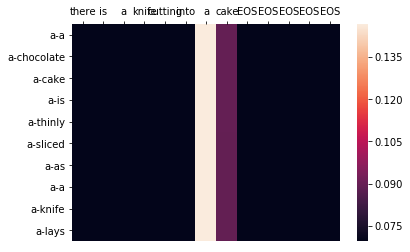

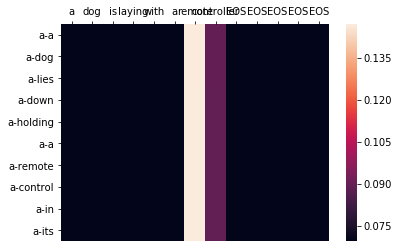

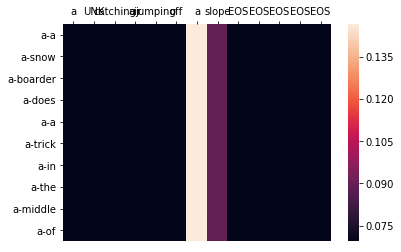

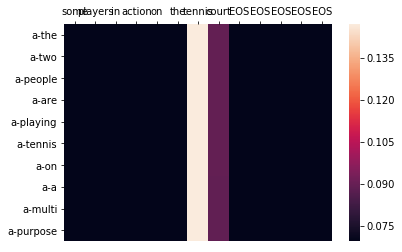

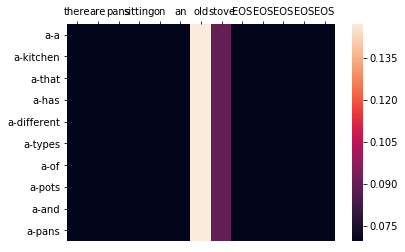

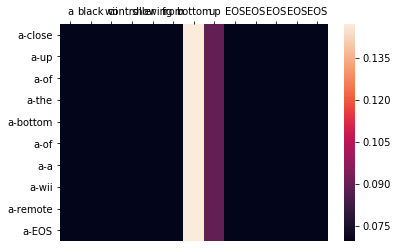

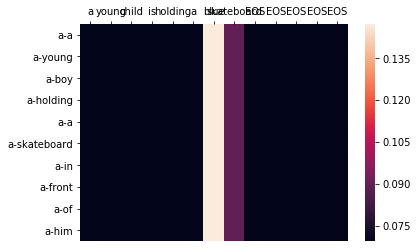

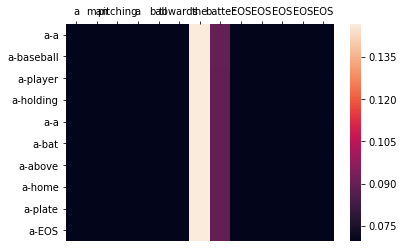



Example 1
INPUT >> a little girl holds an older person's hand while walking on the sidewalk
PRED >> a a a a a a
TRUE >> a young girl is walking with an umbrella
[BLEU] 0.06

Example 2
INPUT >> many images form a picture of a computer monitor on a desk
PRED >> 
TRUE >> a picture of a pc on a makeshift computer table
[BLEU] 0.00

Example 3
INPUT >> a group of animals walks on sandy surface under the cloudy sky
PRED >> 
TRUE >> several animals are seen wandering along the sand
[BLEU] 0.00

Example 4
INPUT >> two baby elephants play in the mud while other elephants look on
PRED >> 
TRUE >> two baby elephants laying in a puddle of mud
[BLEU] 0.00

Example 5
INPUT >> a wooden table filled with wine glasses and a bowl of salad
PRED >> 
TRUE >> bottles and glasses of wine beside a salad
[BLEU] 0.00

Example 6
INPUT >> a hotel room with king bed and a tv on a dresser
PRED >> 
TRUE >> a hotel room with a large bed and a tv
[BLEU] 0.00

Example 7
INPUT >> a banana that has been placed in a tiny

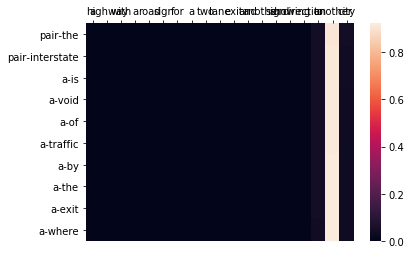

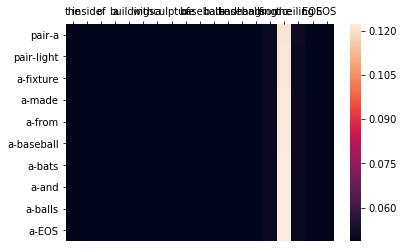

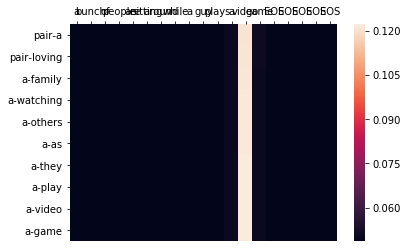

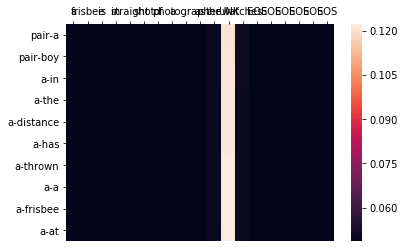

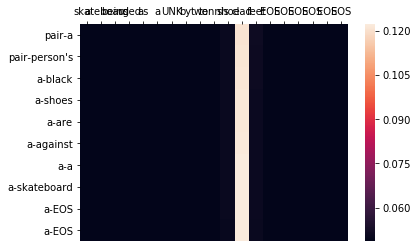

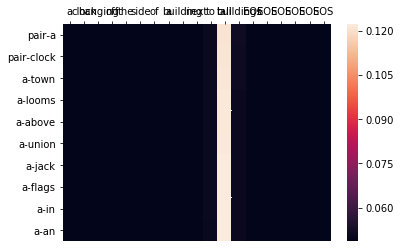

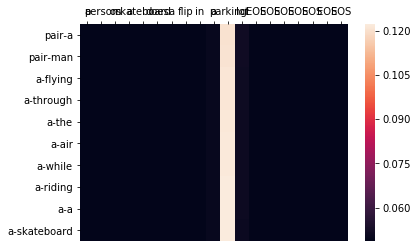

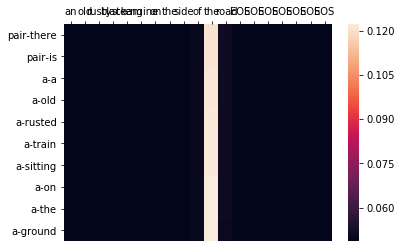

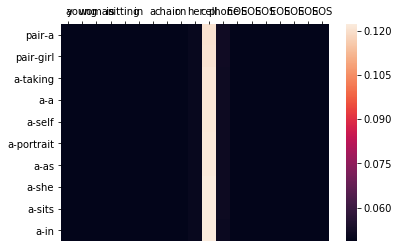

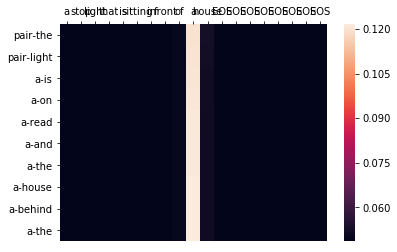

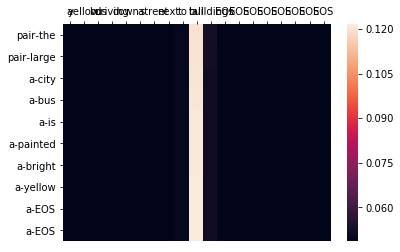

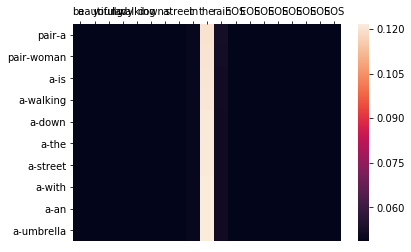

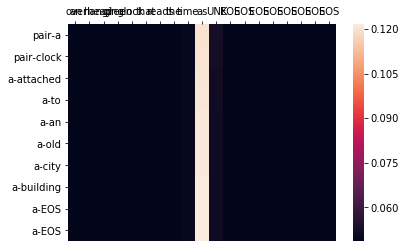

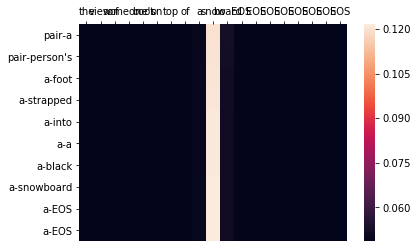

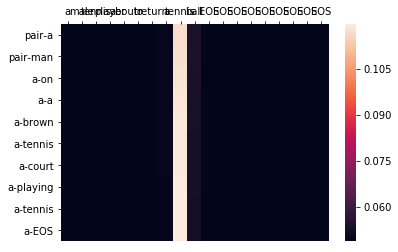

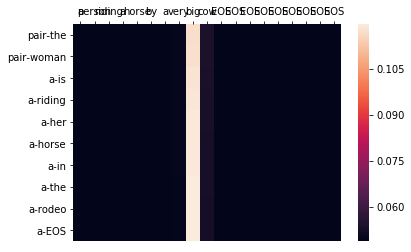

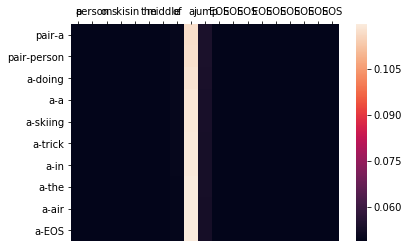

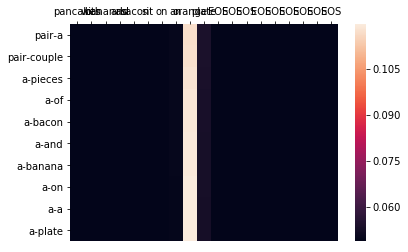

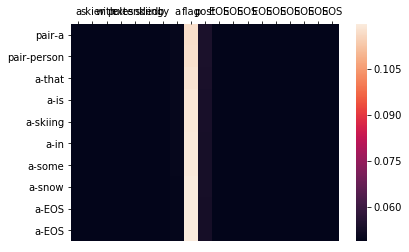

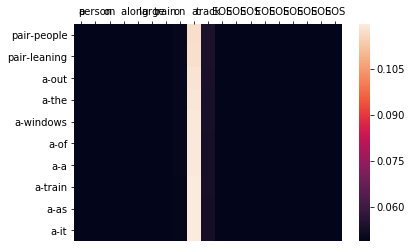

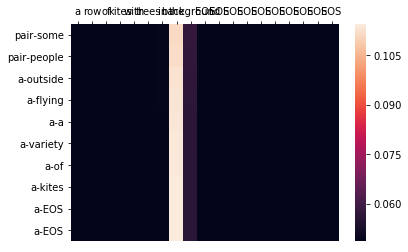

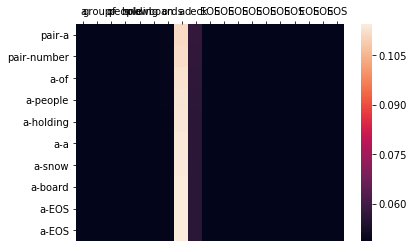

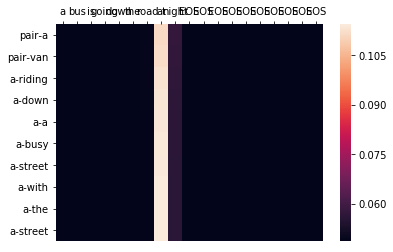

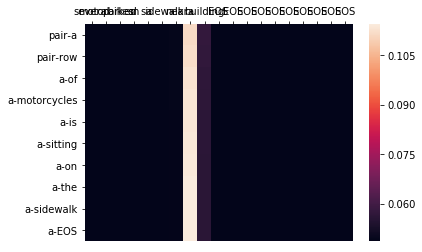

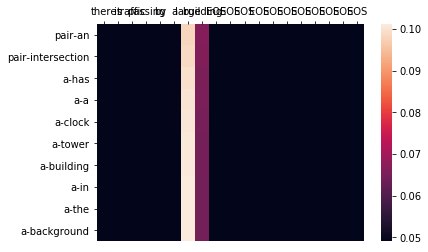

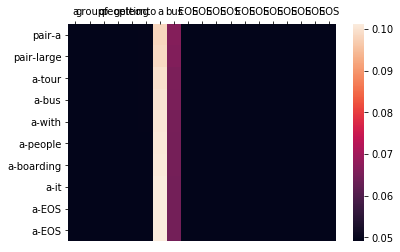

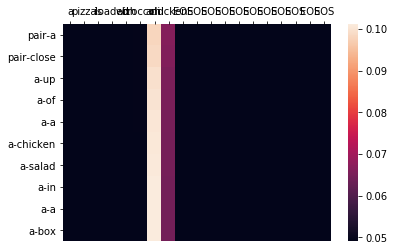

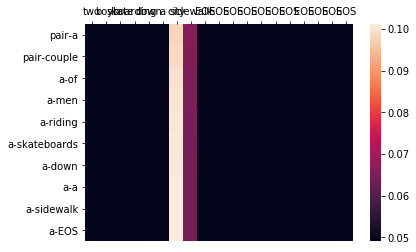

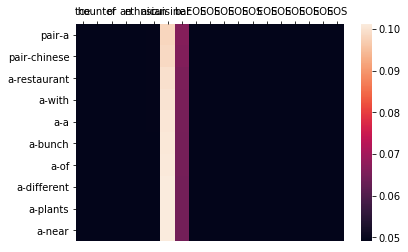

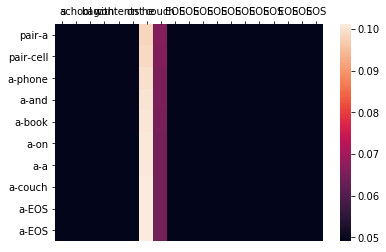

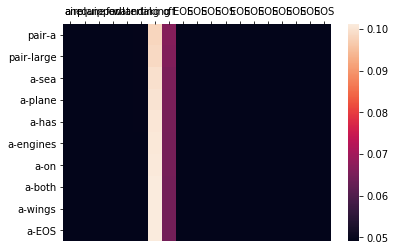

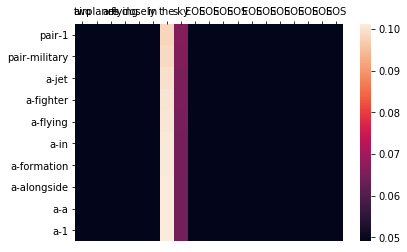



Example 1
INPUT >> a highway with a road sign for a two lane exit and another sign showing direction to another city
PRED >> pair pair a a a a a a a a
TRUE >> the interstate is void of traffic by the exit where
[BLEU] 0.00

Example 2
INPUT >> the inside of a building with a sculpture of baseball bats and baseballs hanging from the ceiling
PRED >> pair pair a a a a a a a a
TRUE >> a light fixture made from baseball bats and balls
[BLEU] 0.04

Example 3
INPUT >> a bunch of people are sitting around while a guy plays a video game
PRED >> pair pair a a a a a a a a
TRUE >> a loving family watching others as they play video game
[BLEU] 0.04

Example 4
INPUT >> a frisbee is in straight shot of a photographer as the watches
PRED >> pair pair a a a a a a a a
TRUE >> a boy in the distance has thrown a frisbee at
[BLEU] 0.05

Example 5
INPUT >> a skateboard being used as a by two tennis shoe clad feet
PRED >> pair pair a a a a a a a a
TRUE >> a person's black shoes are against a skateboard
[BLE

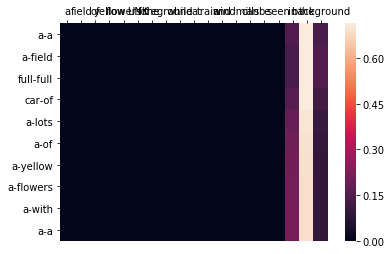

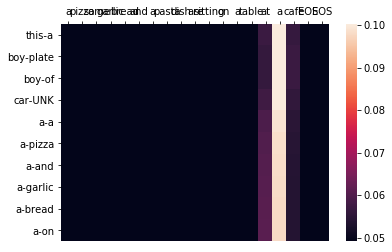

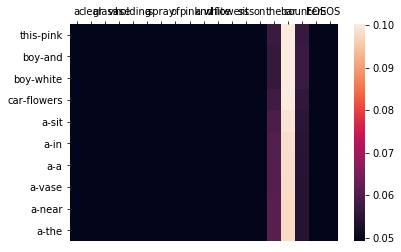

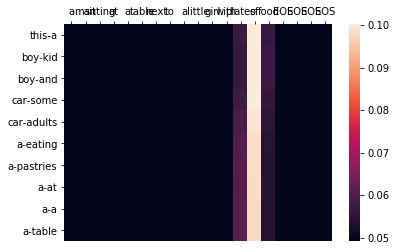

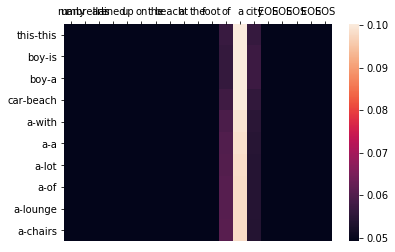

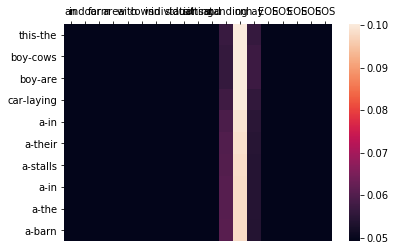

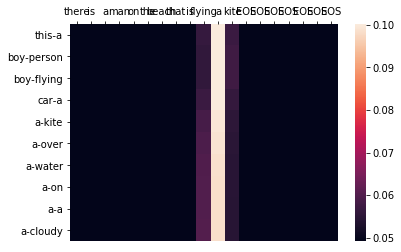

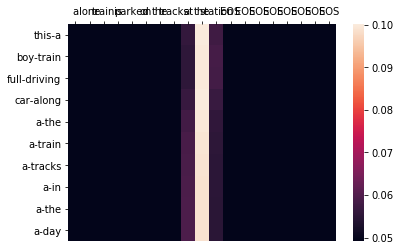

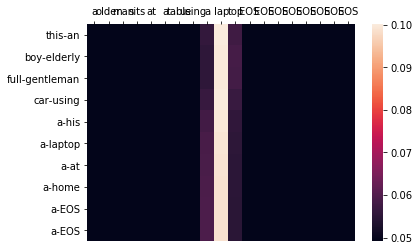

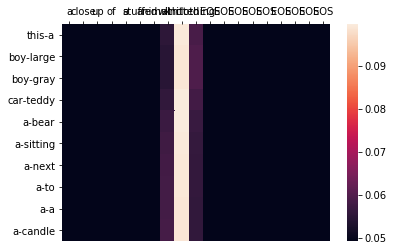

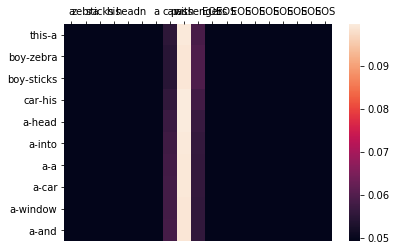

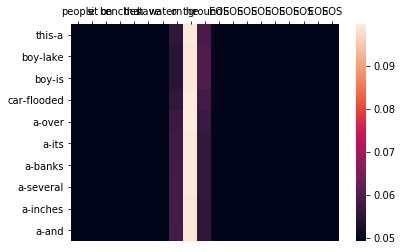

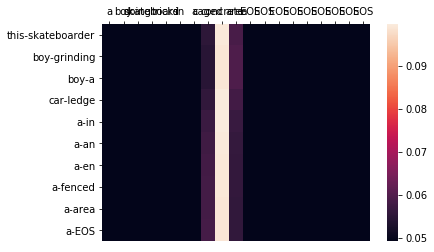

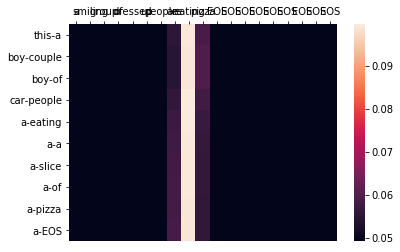

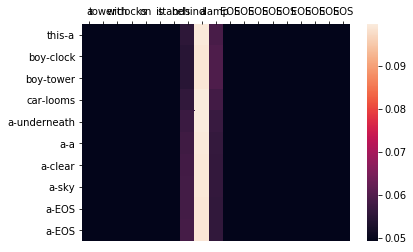

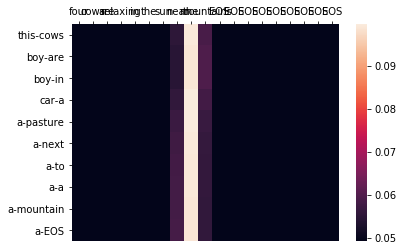

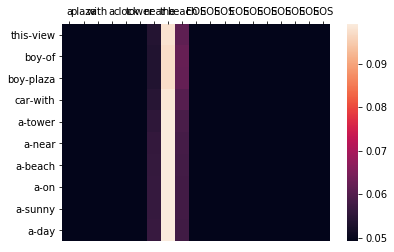

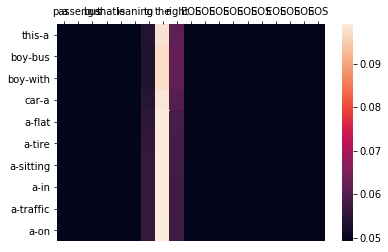

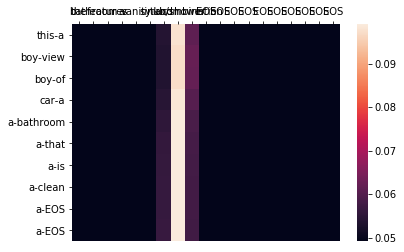

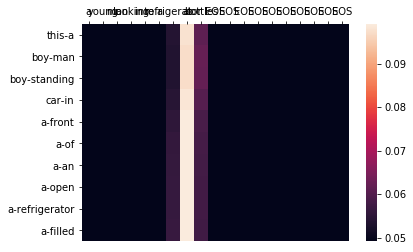

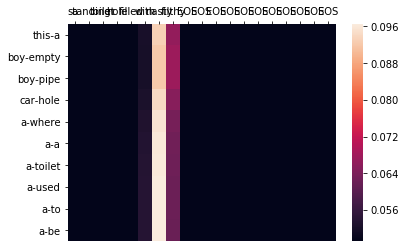

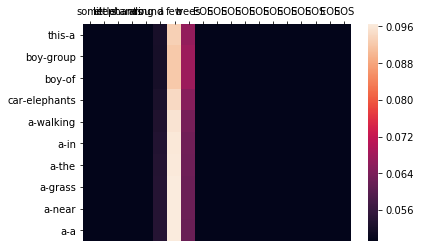

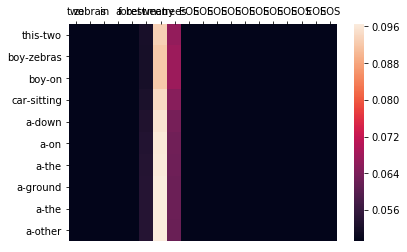

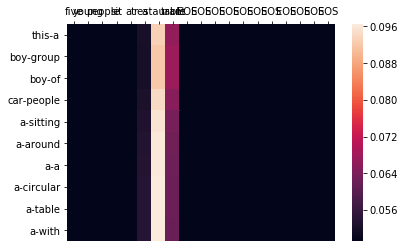

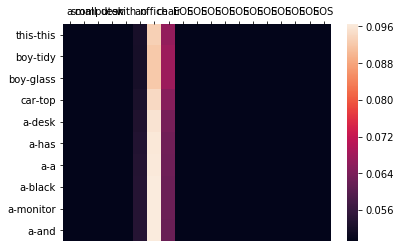

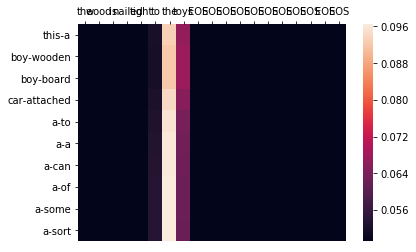

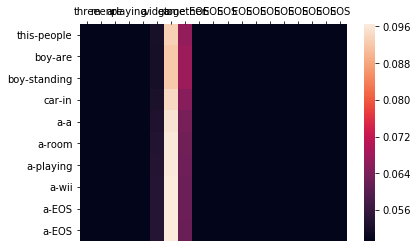

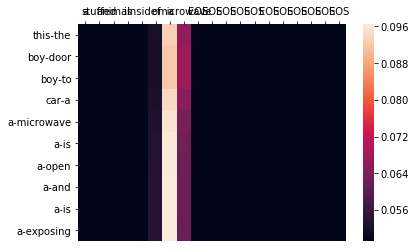

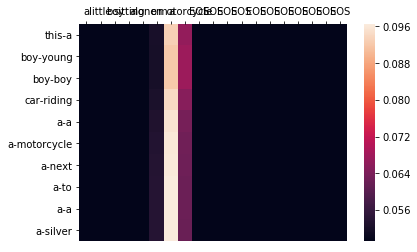

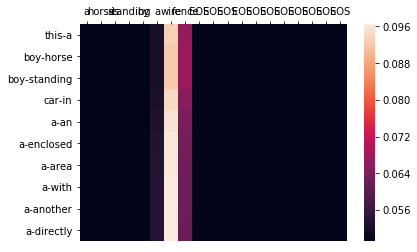

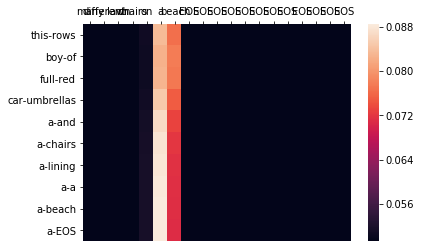

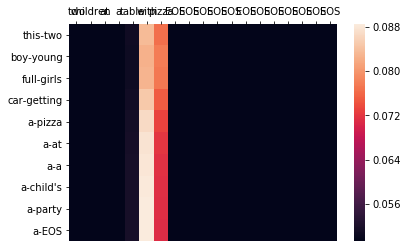



Example 1
INPUT >> a field of yellow flowers the foreground while a train and windmills can be seen in the background
PRED >> a a full car a a a a a a
TRUE >> a field full of lots of yellow flowers with a
[BLEU] 0.06

Example 2
INPUT >> a pizza some garlic bread and a pasta dish are sitting on a table at a cafe
PRED >> this boy boy car a a a a a a
TRUE >> a plate of a pizza and garlic bread on
[BLEU] 0.05

Example 3
INPUT >> a clear glass vase holding a spray of pink and white flowers sits on the bar counter
PRED >> this boy boy car a a a a a a
TRUE >> pink and white flowers sit in a vase near the
[BLEU] 0.04

Example 4
INPUT >> a man sitting at a table next to a little girl with plates of food
PRED >> this boy boy car car a a a a a
TRUE >> a kid and some adults eating pastries at a table
[BLEU] 0.05

Example 5
INPUT >> many umbrellas are lined up on the beach at the foot of a city
PRED >> this boy boy car a a a a a a
TRUE >> this is a beach with a lot of lounge chairs
[BLEU] 0.06

E

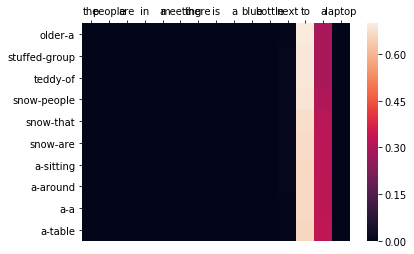

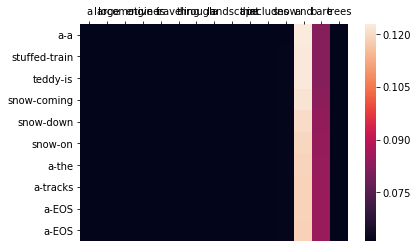

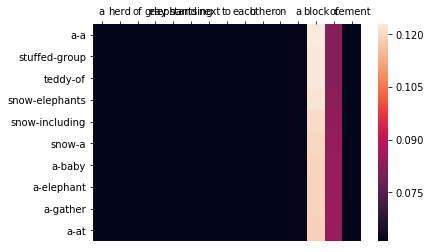

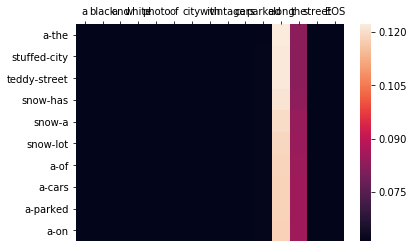

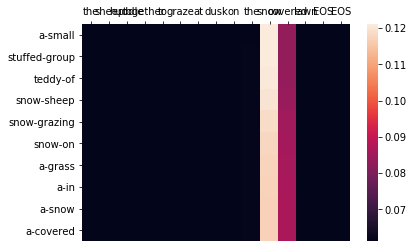

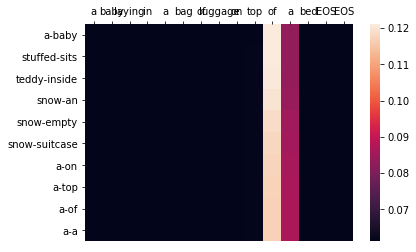

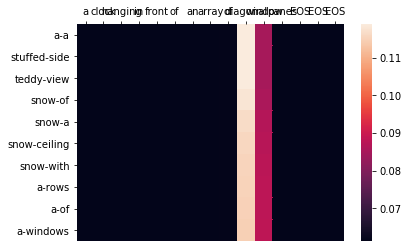

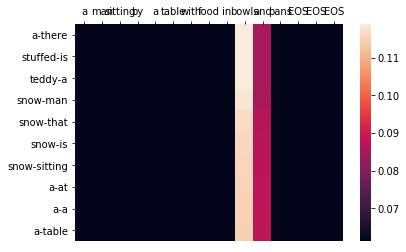

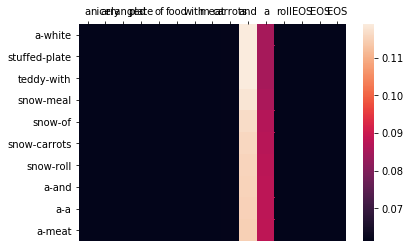

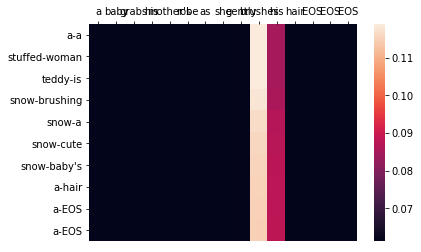

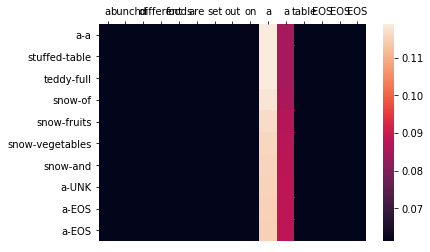

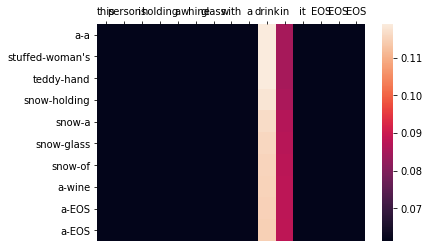

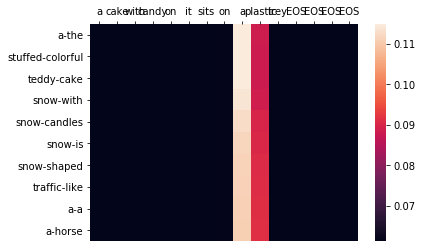

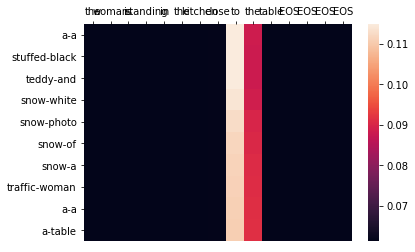

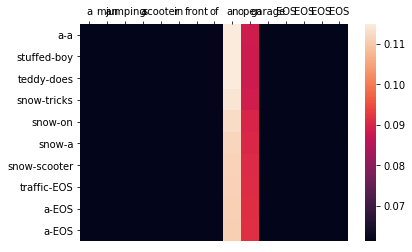

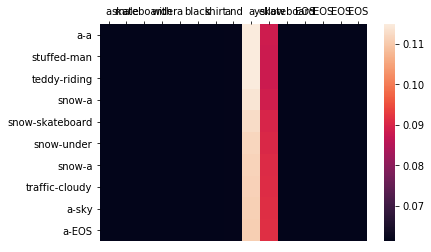

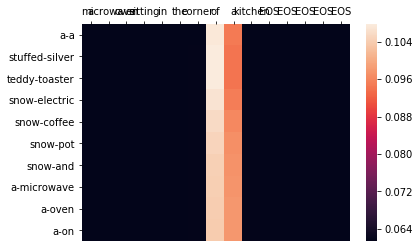

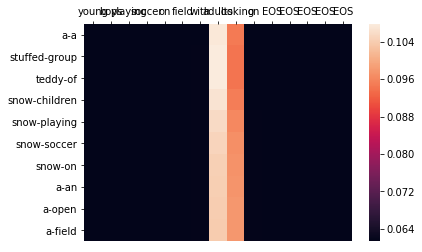

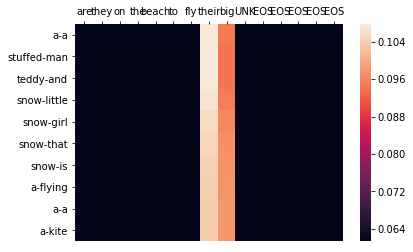

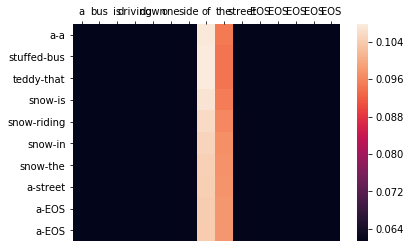

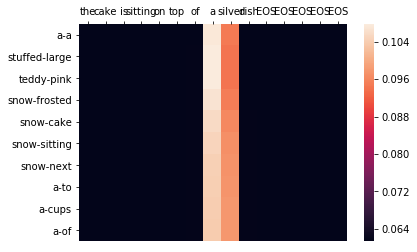

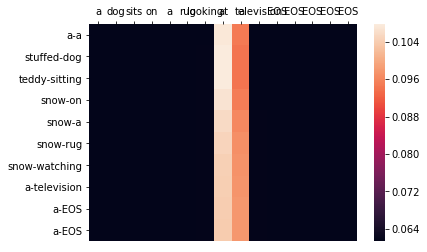

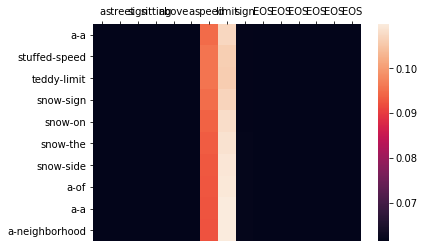

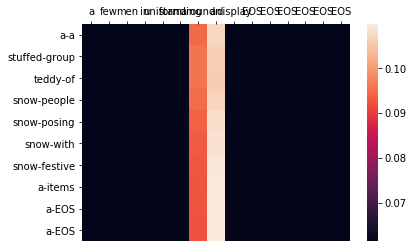

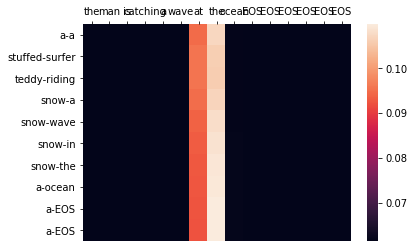

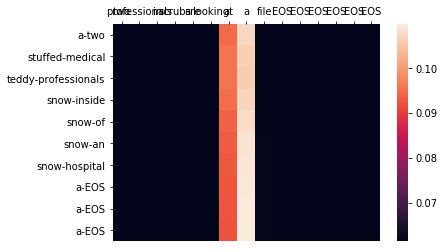

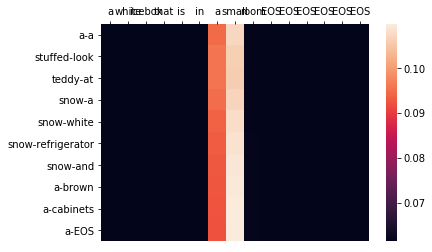

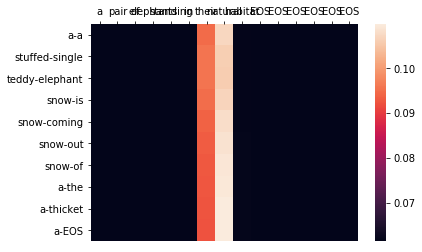

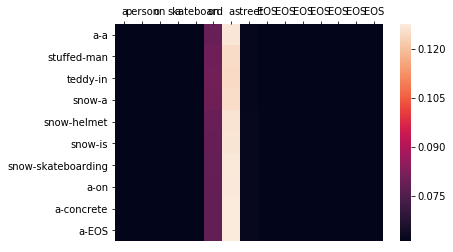

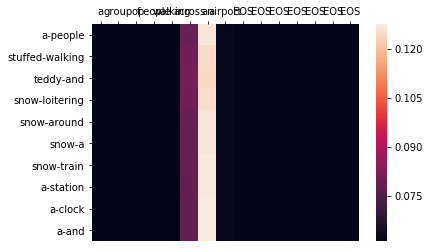

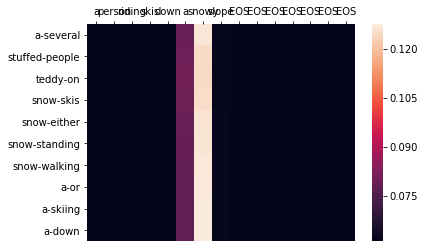

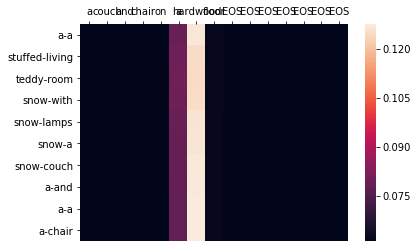



Example 1
INPUT >> the people are in a meeting there is a blue bottle next to a laptop
PRED >> older stuffed teddy snow snow snow a a a a
TRUE >> a group of people that are sitting around a table
[BLEU] 0.05

Example 2
INPUT >> a large locomotive engine is traveling through a landscape that includes snow and bare trees
PRED >> a stuffed teddy snow snow snow a a a a
TRUE >> a train is coming down on the tracks
[BLEU] 0.04

Example 3
INPUT >> a herd of gray elephants standing next to each other on a block of cement
PRED >> a stuffed teddy snow snow snow a a a a
TRUE >> a group of elephants including a baby elephant gather at
[BLEU] 0.05

Example 4
INPUT >> a black and white photo of city with vintage cars parked along the street
PRED >> a stuffed teddy snow snow snow a a a a
TRUE >> the city street has a lot of cars parked on
[BLEU] 0.04

Example 5
INPUT >> the sheep huddle together to graze at dusk on the snow covered lawn
PRED >> a stuffed teddy snow snow snow a a a a
TRUE >> small g

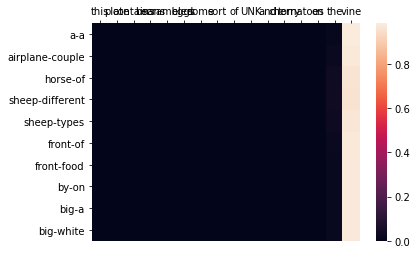

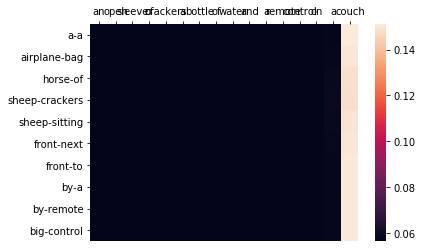

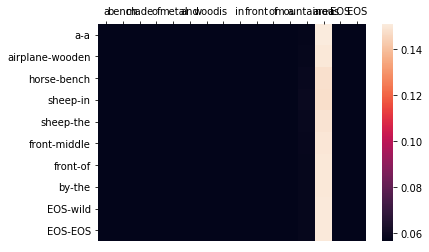

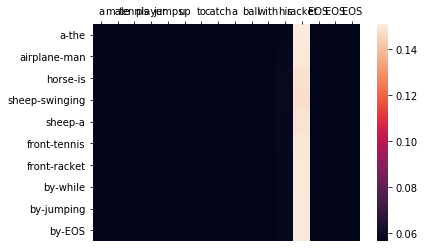

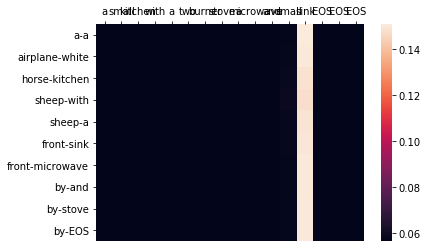

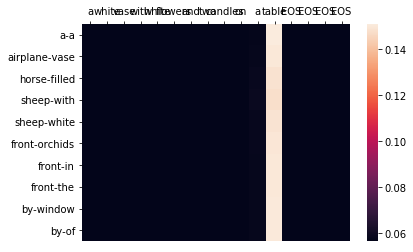

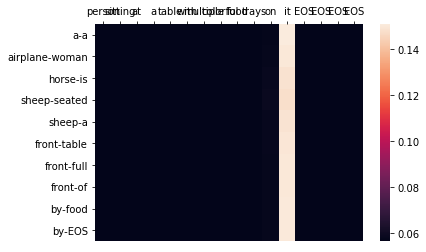

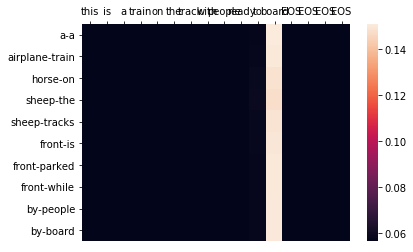

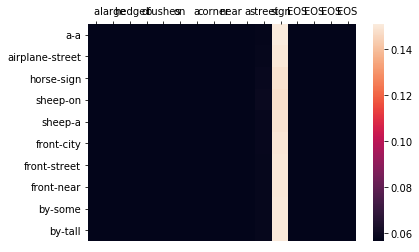

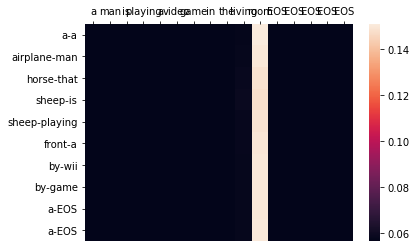

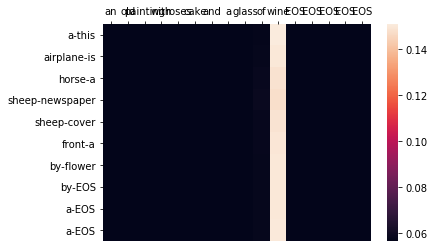

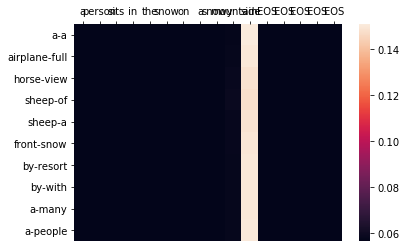

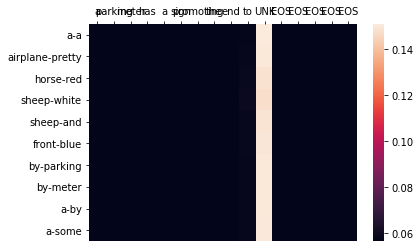

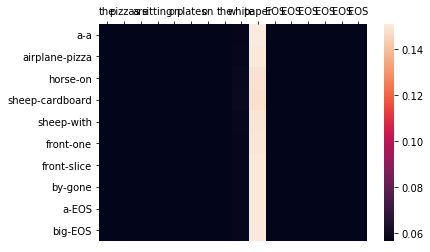

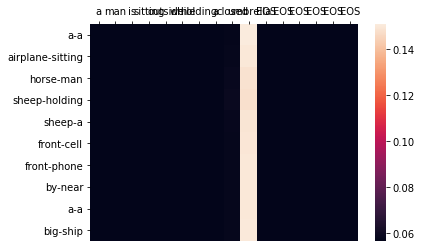

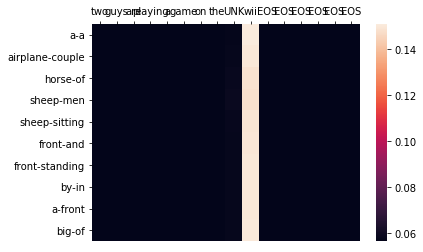

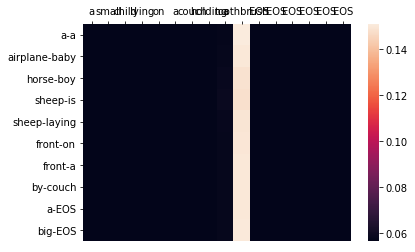

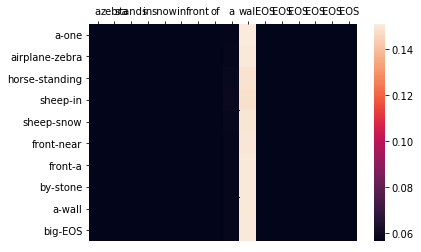

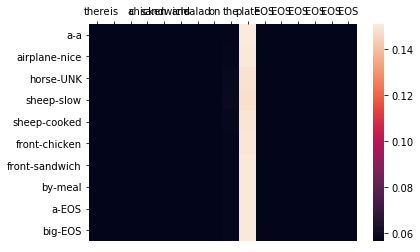

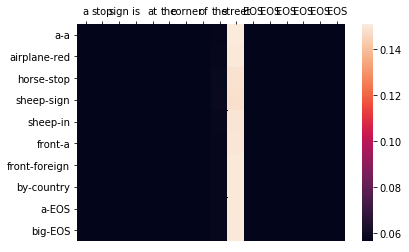

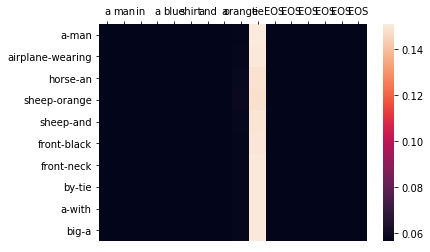

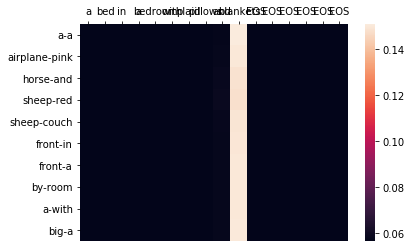

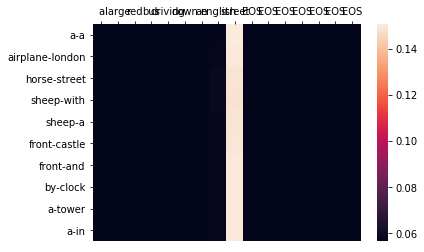

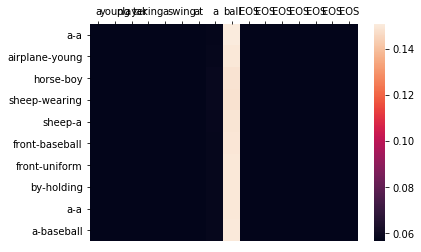

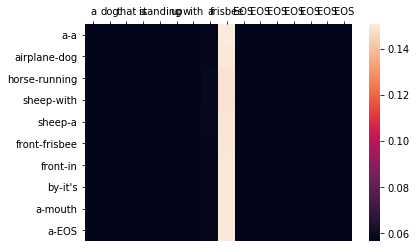

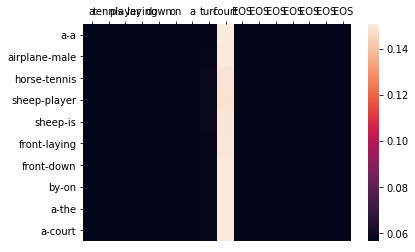

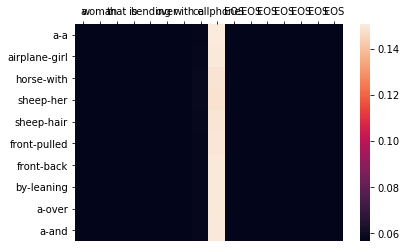

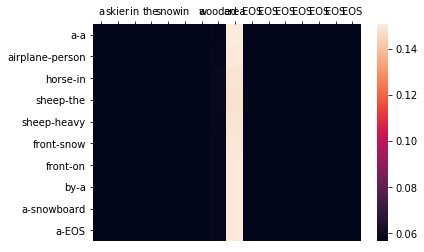

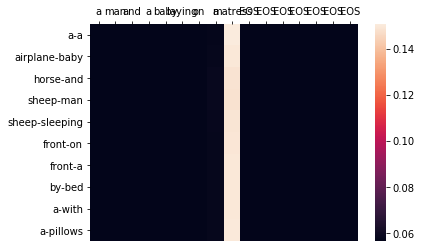

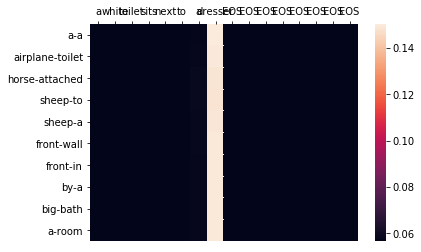

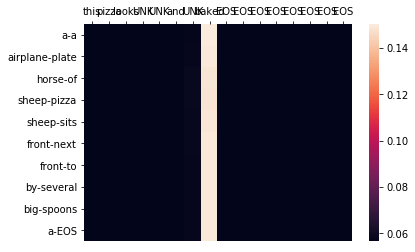

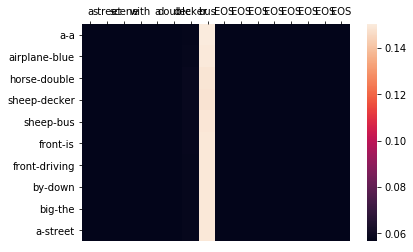



Example 1
INPUT >> this plate contains beans scrambled eggs some sort of and cherry tomatoes on the vine
PRED >> a airplane horse sheep sheep front front by big big
TRUE >> a couple of different types of food on a white
[BLEU] 0.04

Example 2
INPUT >> an open sleeve of crackers a bottle of water and a remote control on a couch
PRED >> a airplane horse sheep sheep front front by by big
TRUE >> a bag of crackers sitting next to a remote control
[BLEU] 0.04

Example 3
INPUT >> a bench made of metal and wood is in front of a mountainous area
PRED >> a airplane horse sheep sheep front front by
TRUE >> a wooden bench in the middle of the wild
[BLEU] 0.05

Example 4
INPUT >> a male tennis player jumps up to catch a ball with his racket
PRED >> a airplane horse sheep sheep front front by by by
TRUE >> the man is swinging a tennis racket while jumping
[BLEU] 0.04

Example 5
INPUT >> a small kitchen with a two burner stove a microwave and small sink
PRED >> a airplane horse sheep sheep front f

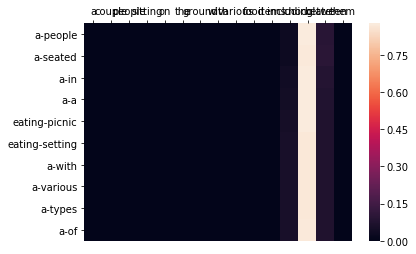

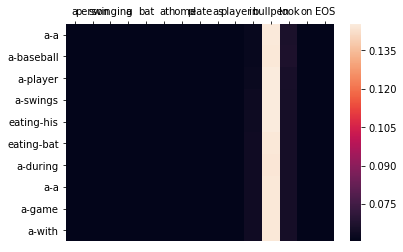

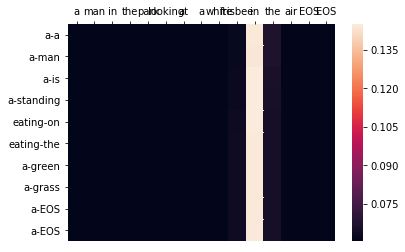

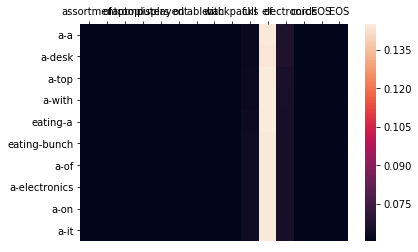

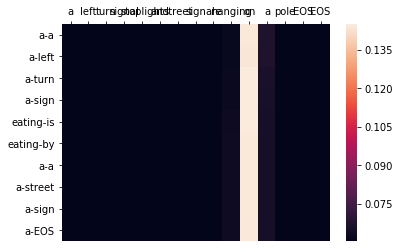

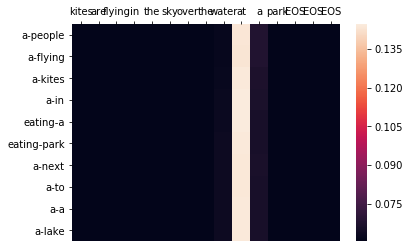

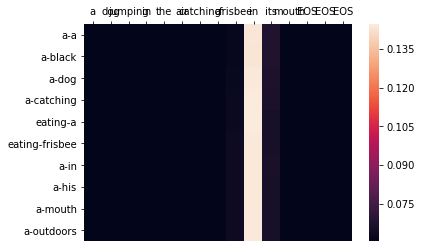

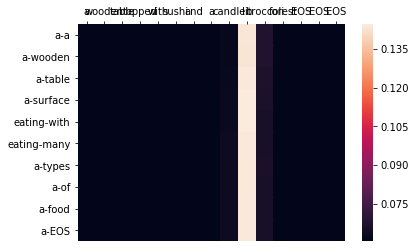

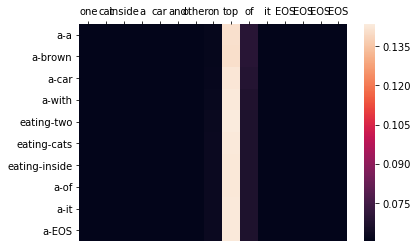

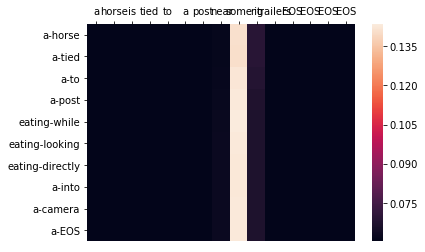

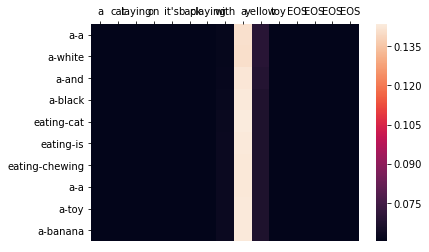

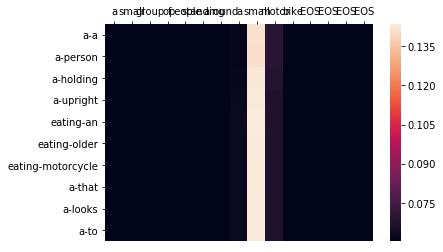

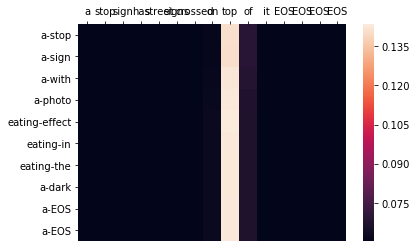

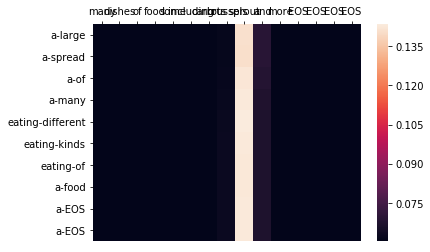

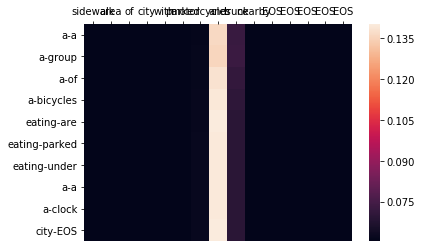

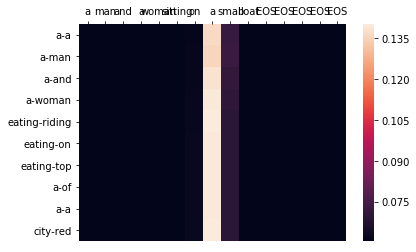

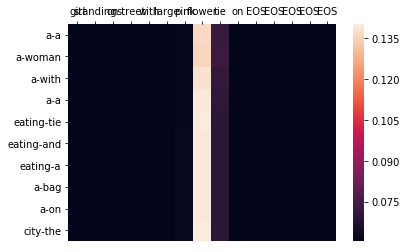

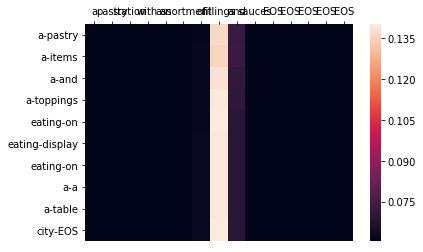

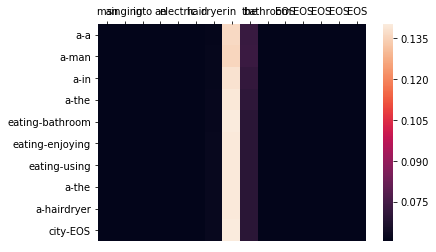

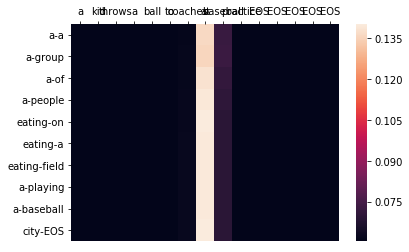

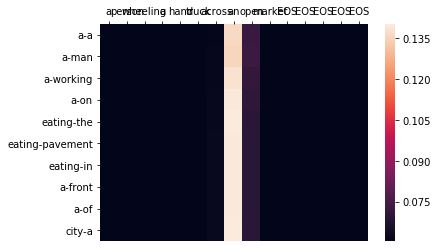

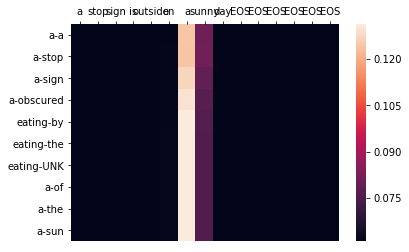

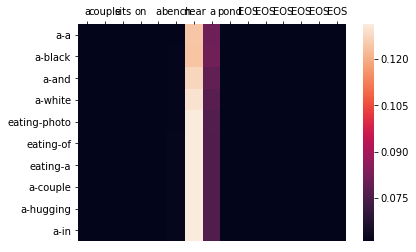

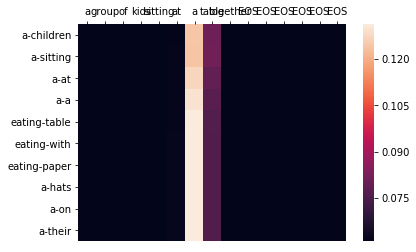

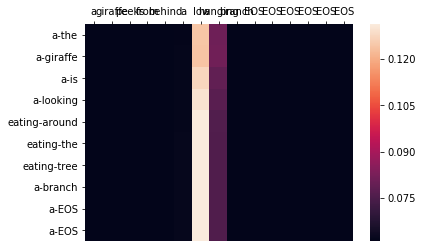

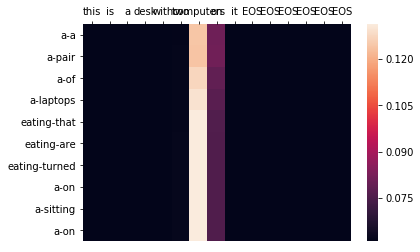

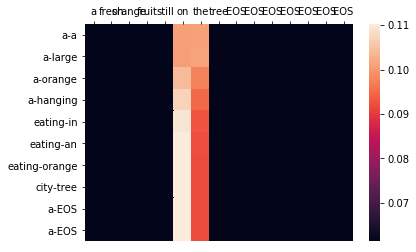

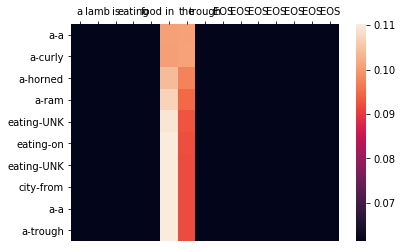

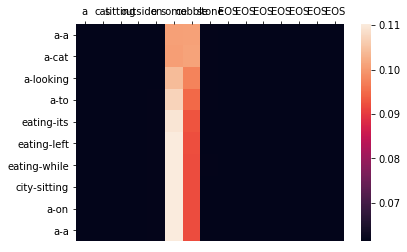

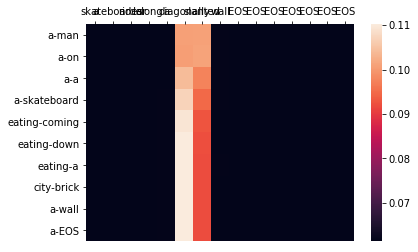

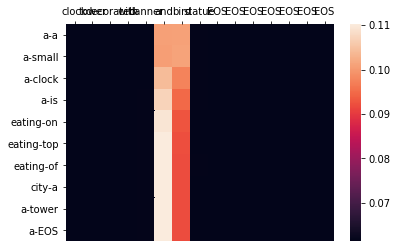

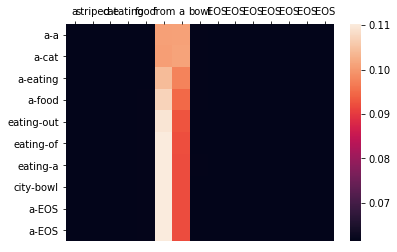



Example 1
INPUT >> a couple people sitting on the ground with various food items including chocolate between them
PRED >> a a a a eating eating a a a a
TRUE >> people seated in a picnic setting with various types of
[BLEU] 0.04

Example 2
INPUT >> a person swinging a bat at home plate as player in bullpen look on
PRED >> a a a a eating eating a a a a
TRUE >> a baseball player swings his bat during a game with
[BLEU] 0.05

Example 3
INPUT >> a man in the park looking at a white frisbee in the air
PRED >> a a a a eating eating a a a a
TRUE >> a man is standing on the green grass
[BLEU] 0.04

Example 4
INPUT >> assortment of laptop computers displayed on table with backpacks full of electronic cords
PRED >> a a a a eating eating a a a a
TRUE >> a desk top with a bunch of electronics on it
[BLEU] 0.05

Example 5
INPUT >> a left turn signal stoplight and street sign are hanging on a pole
PRED >> a a a a eating eating a a a a
TRUE >> a left turn sign is by a street sign
[BLEU] 0.05

Exampl

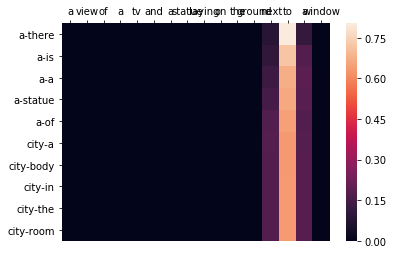

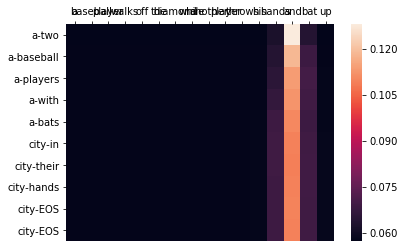

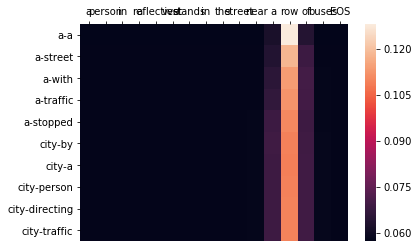

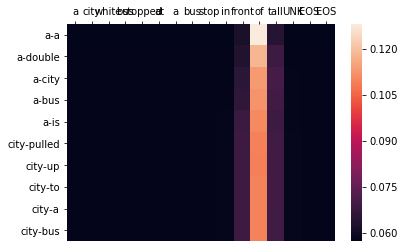

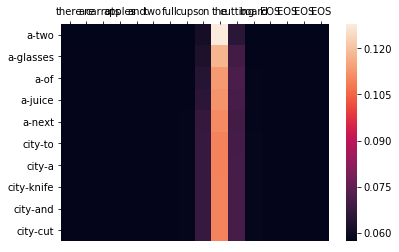

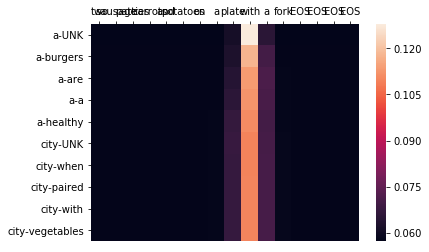

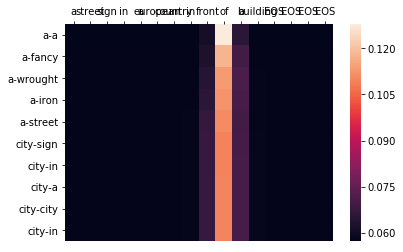

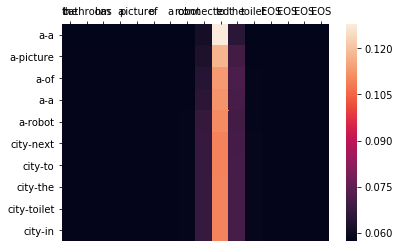

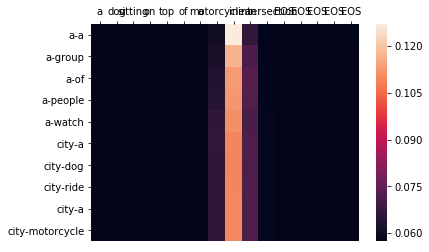

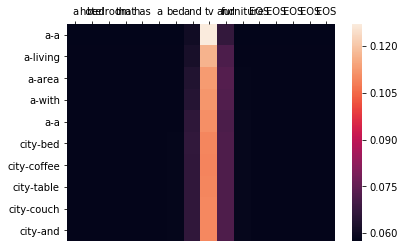

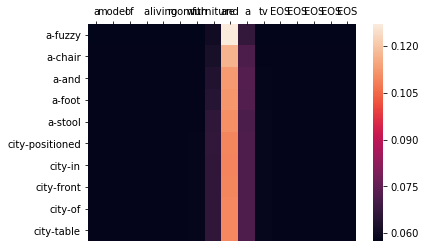

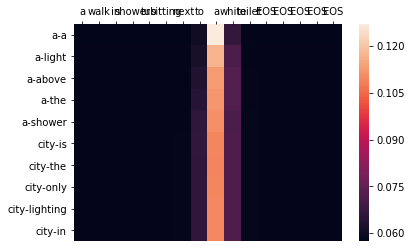

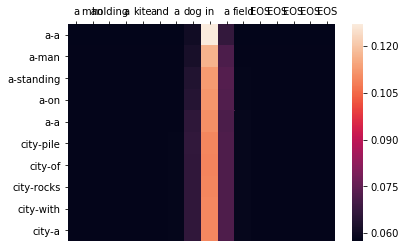

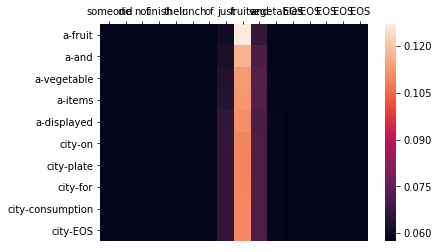

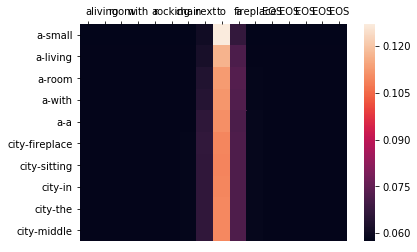

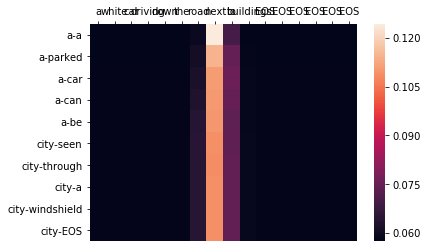

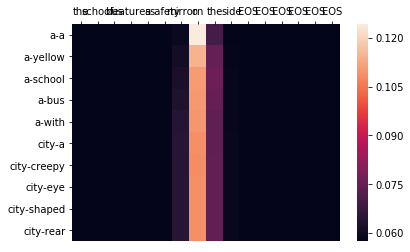

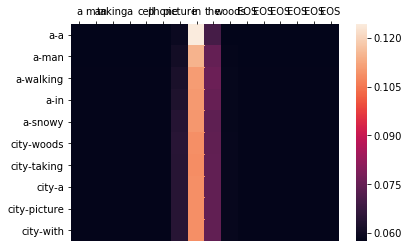

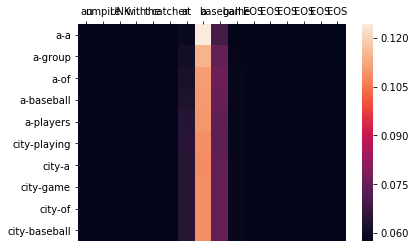

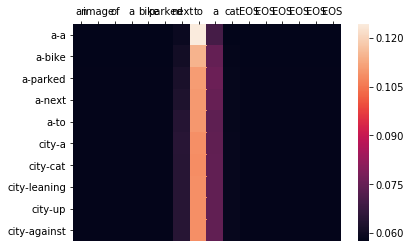

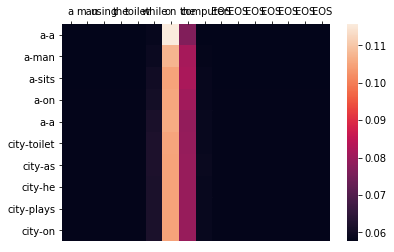

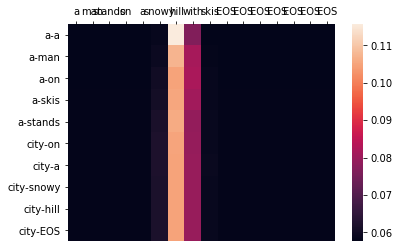

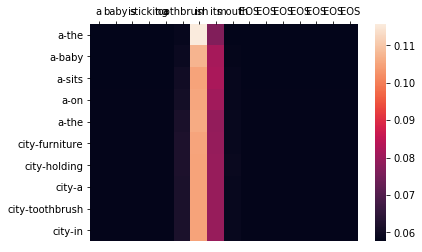

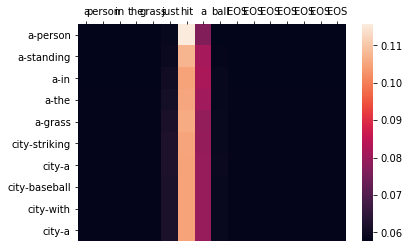

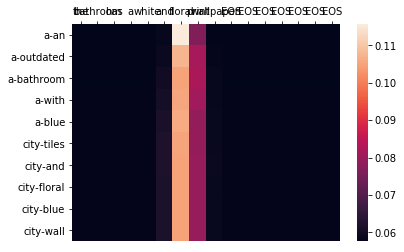

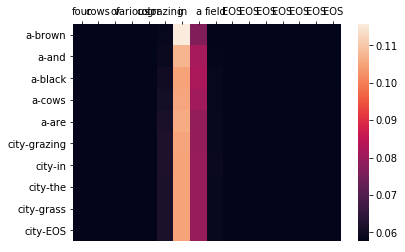

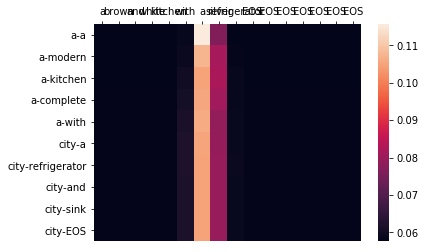

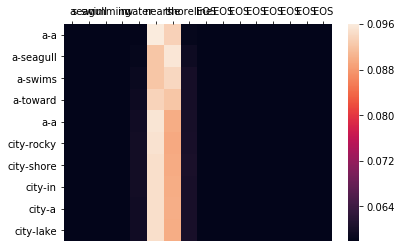

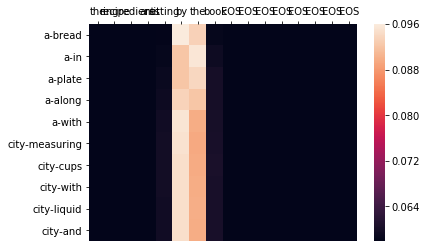

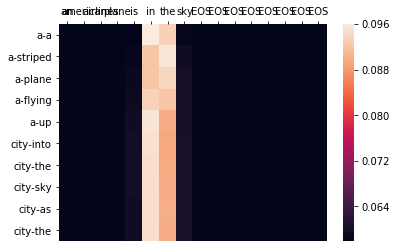

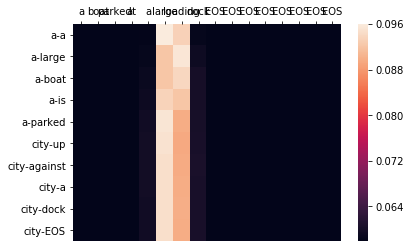

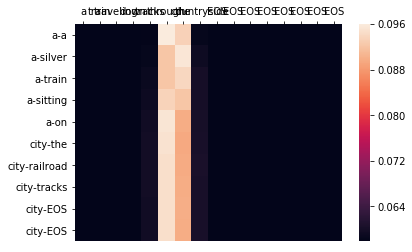



Example 1
INPUT >> a view of a tv and a statue laying on the ground next to a window
PRED >> a a a a a city city city city city
TRUE >> there is a statue of a body in the room
[BLEU] 0.05

Example 2
INPUT >> a baseball player walks off the diamond while another player throws his hands and bat up
PRED >> a a a a a city city city city city
TRUE >> two baseball players with bats in their hands
[BLEU] 0.00

Example 3
INPUT >> a person in a reflective vest stands in the street near a row of buses
PRED >> a a a a a city city city city city
TRUE >> a street with traffic stopped by a person directing traffic
[BLEU] 0.05

Example 4
INPUT >> a city white bus stopped at a bus stop in front of tall
PRED >> a a a a a city city city city city
TRUE >> a double city bus is pulled up to a bus
[BLEU] 0.06

Example 5
INPUT >> there are carrots apples and two full cups on the cutting board
PRED >> a a a a a city city city city city
TRUE >> two glasses of juice next to a knife and cut
[BLEU] 0.04

Exampl

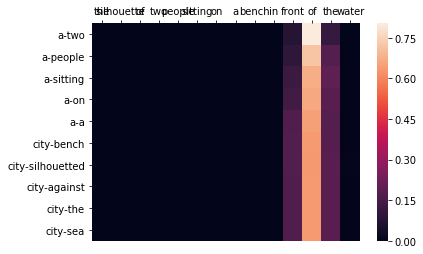

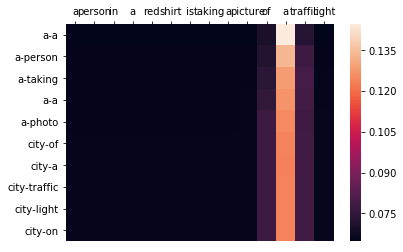

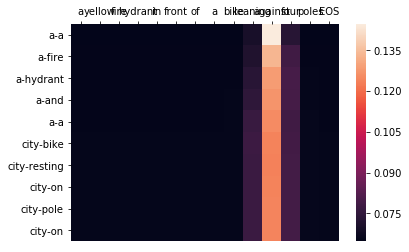

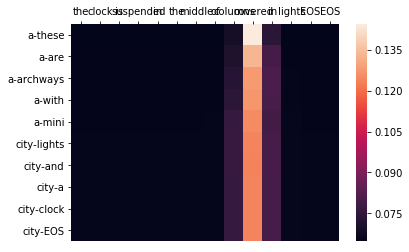

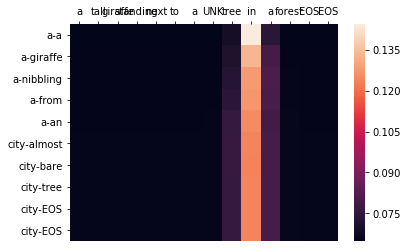

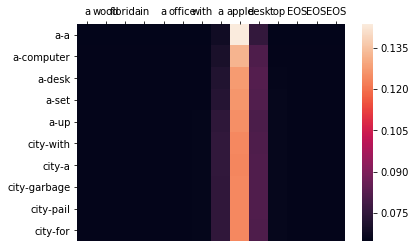

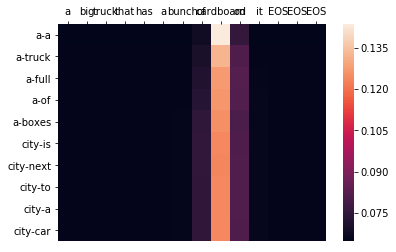

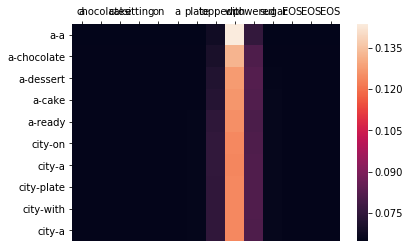

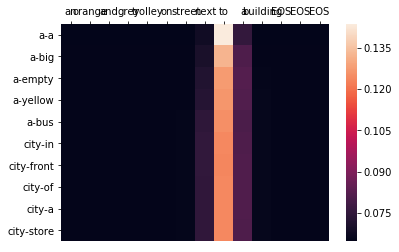

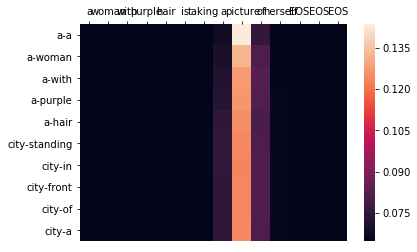

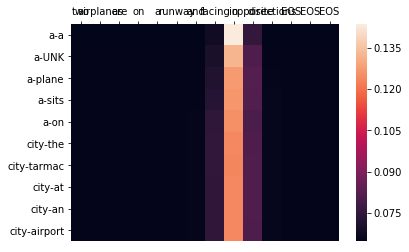

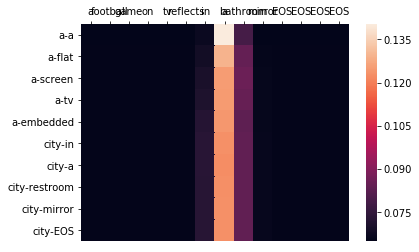

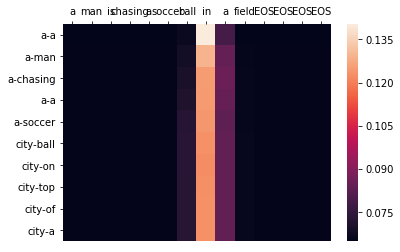

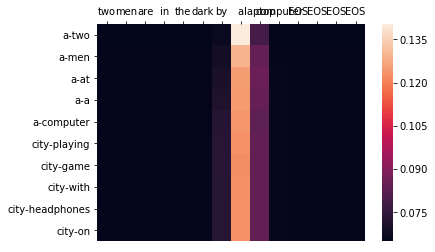

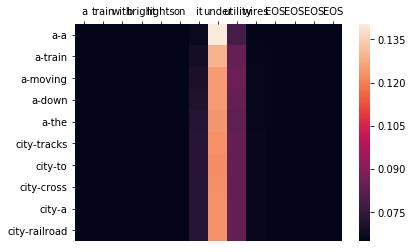

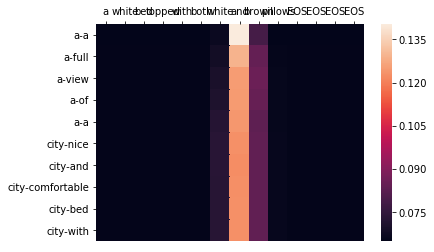

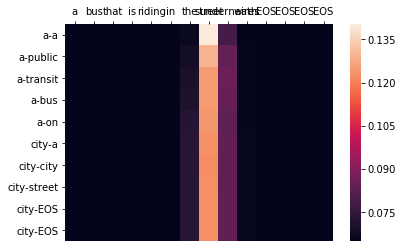

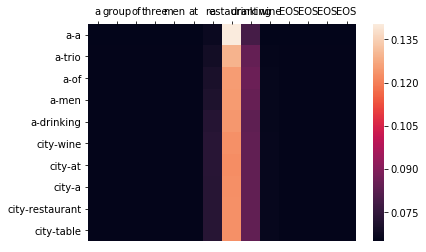

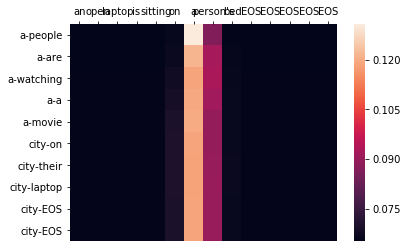

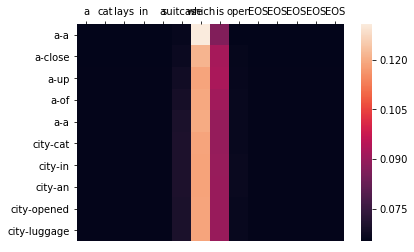

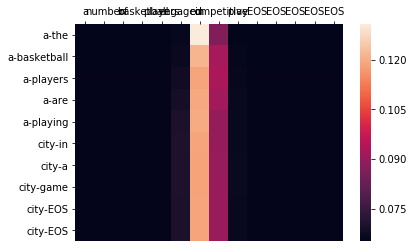

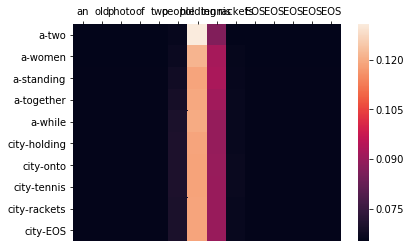

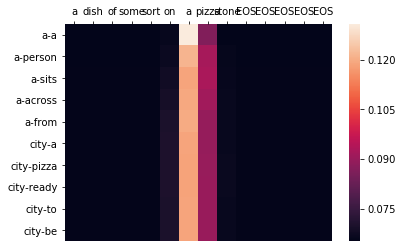

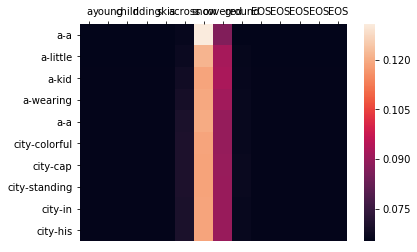

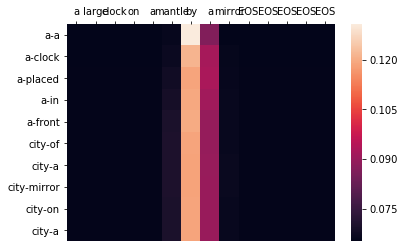

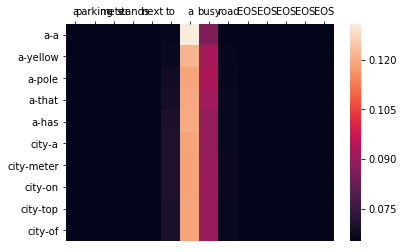

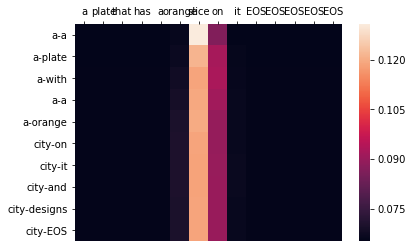

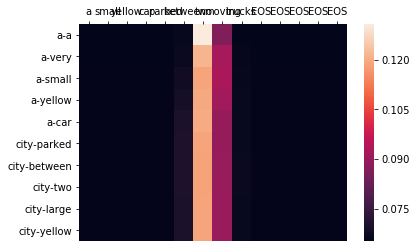

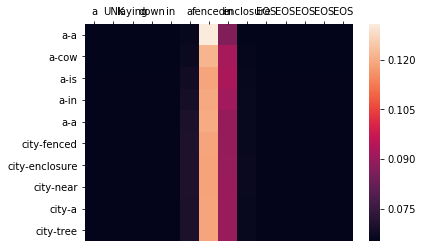

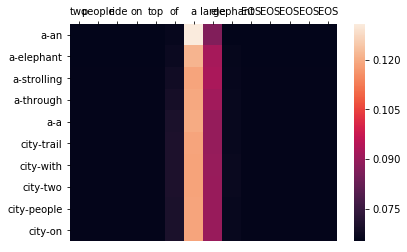

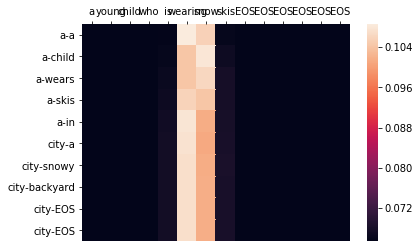

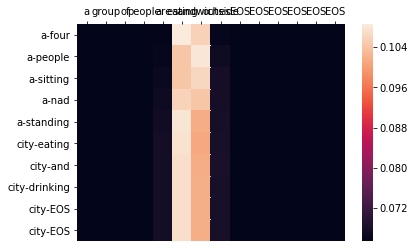



=========== HEATMAPS ==========


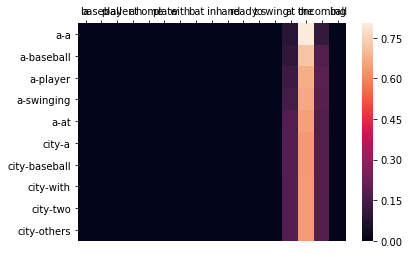

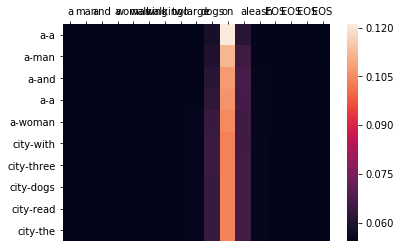

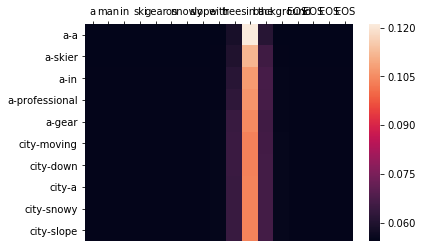

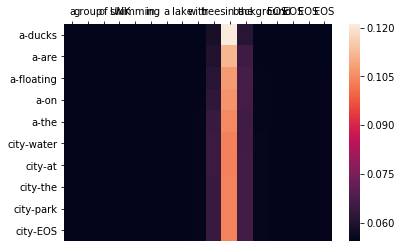

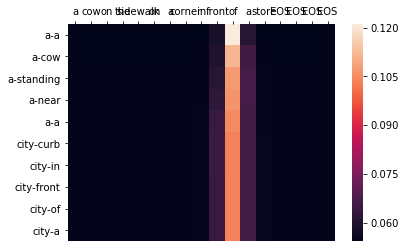

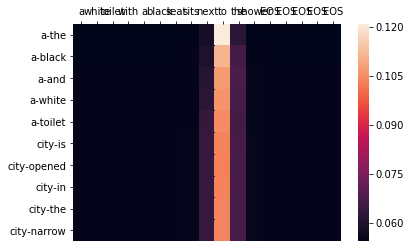

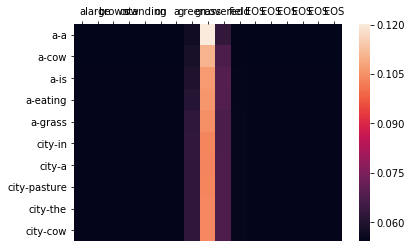

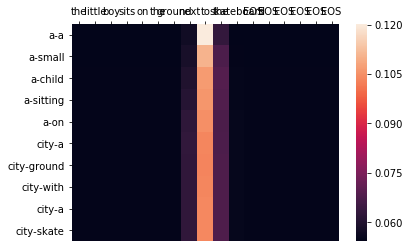

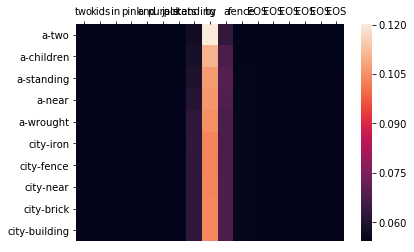

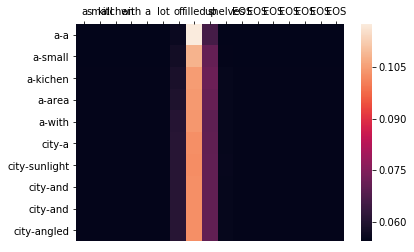

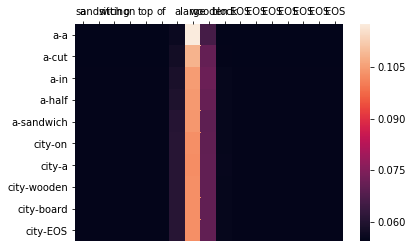

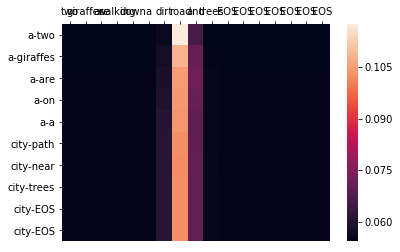

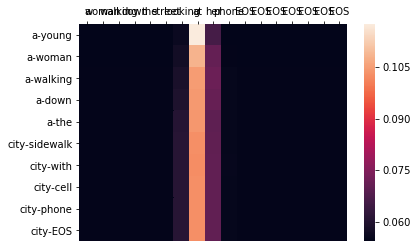

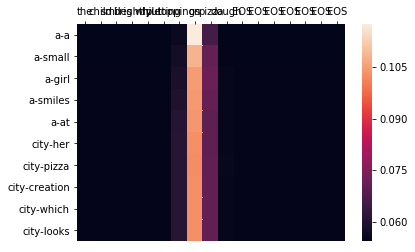

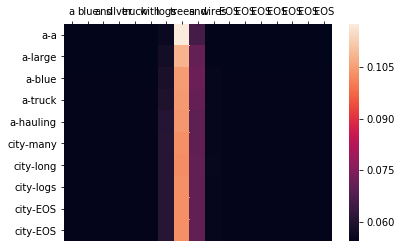

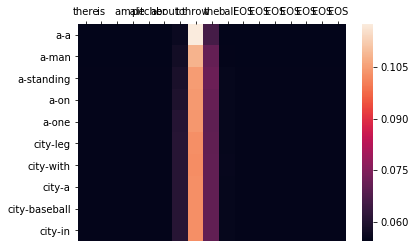

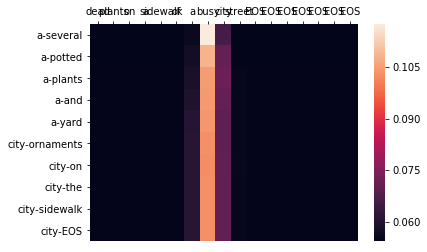

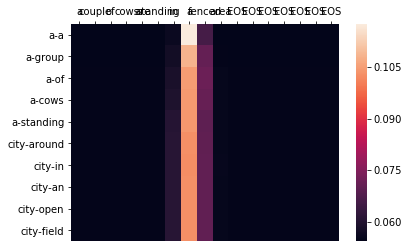

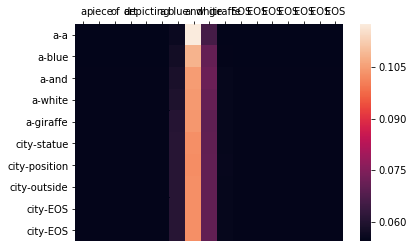

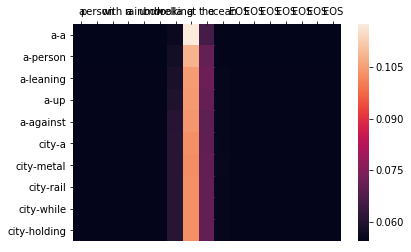

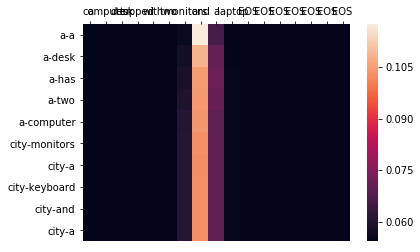

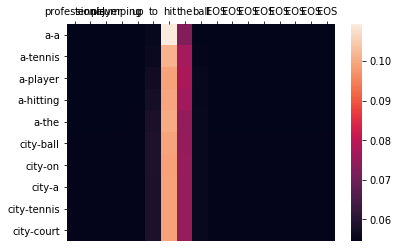

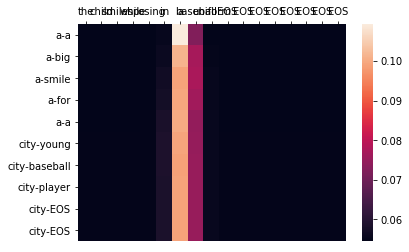

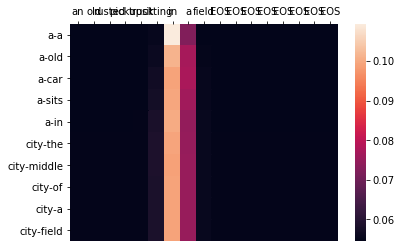

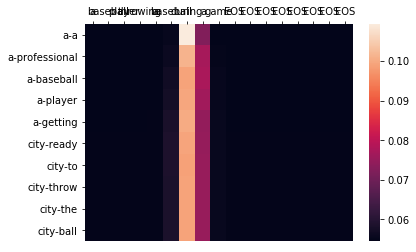

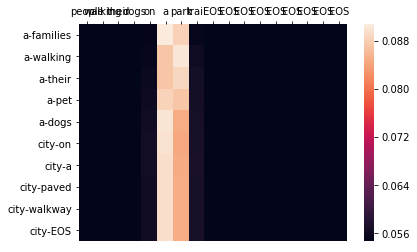

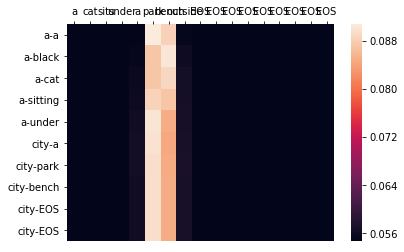

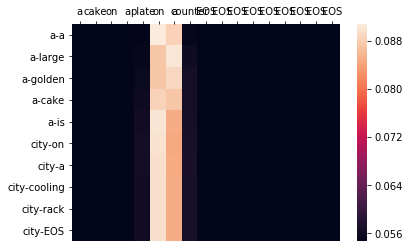

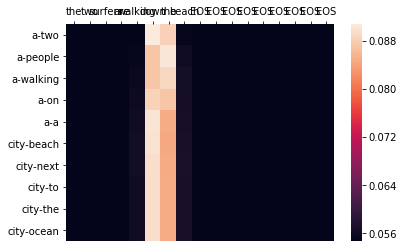

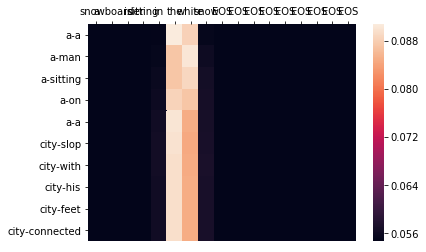

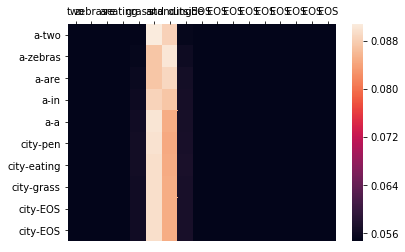

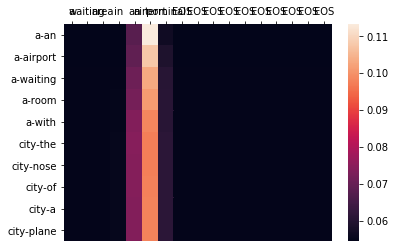



=========== HEATMAPS ==========


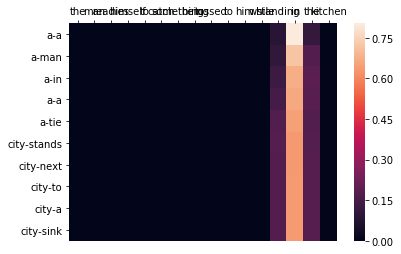

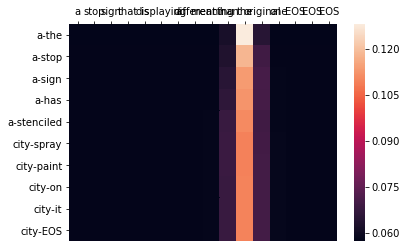

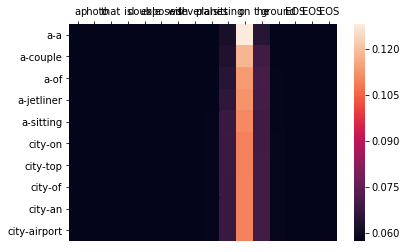

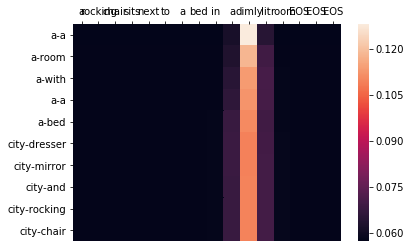

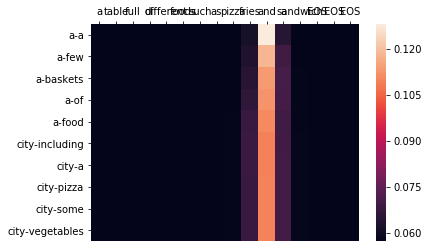

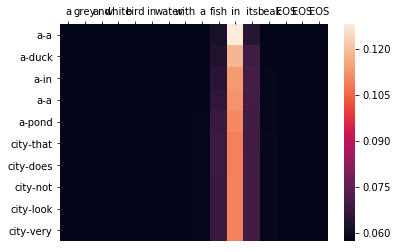

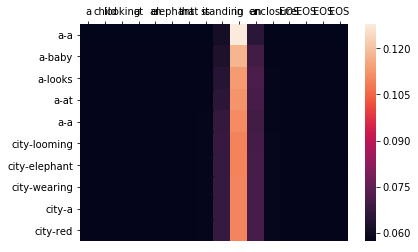

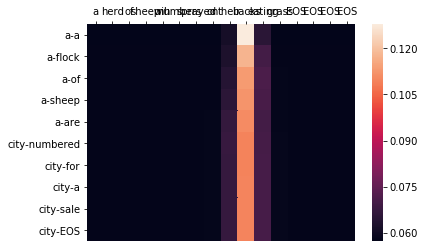

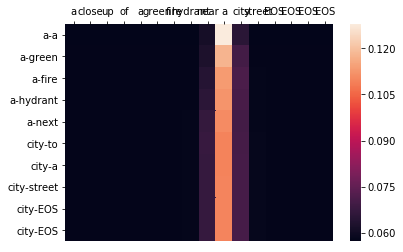

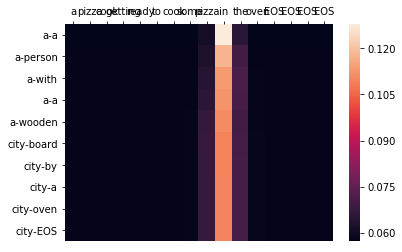

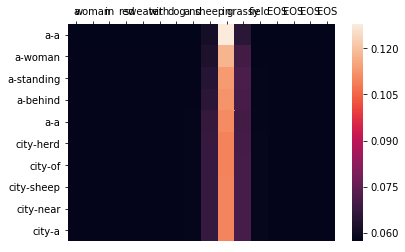

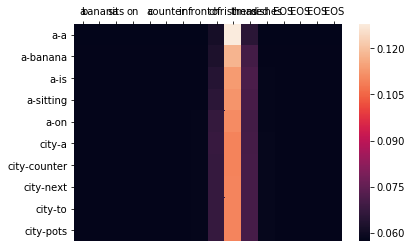

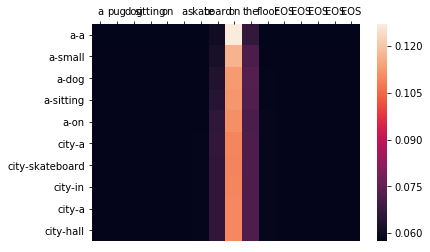

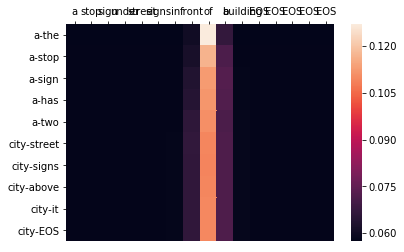

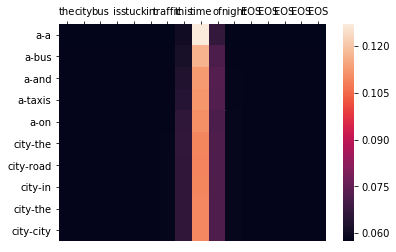

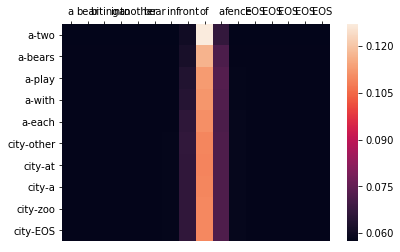

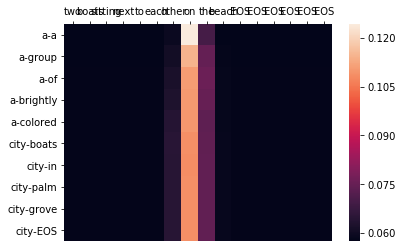

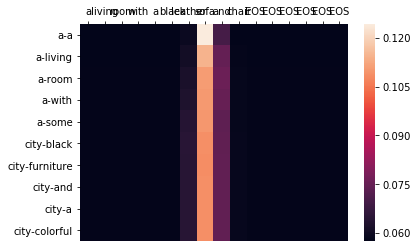

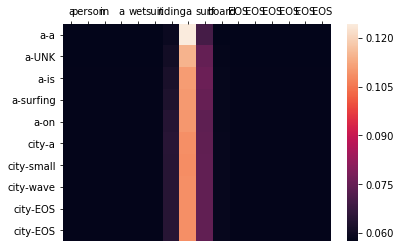

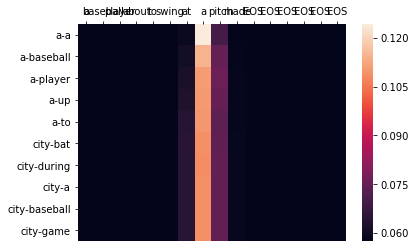

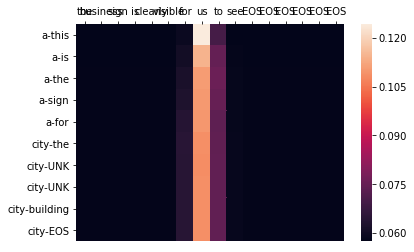

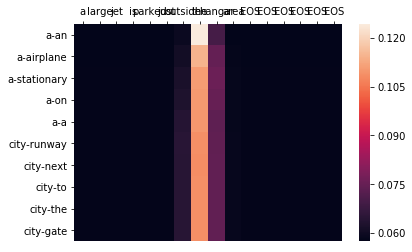

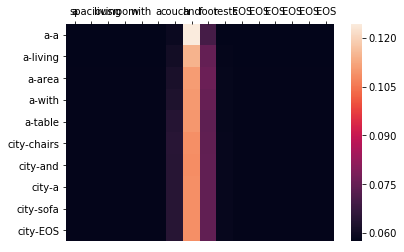

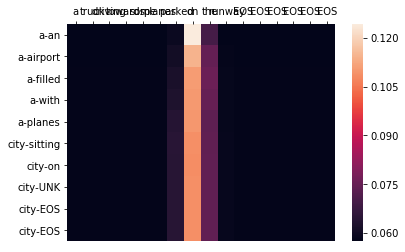

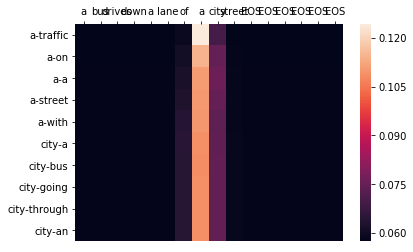

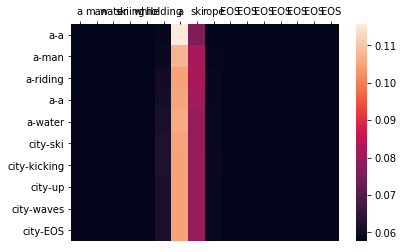

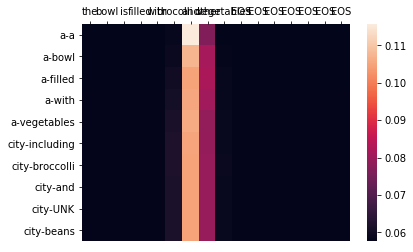

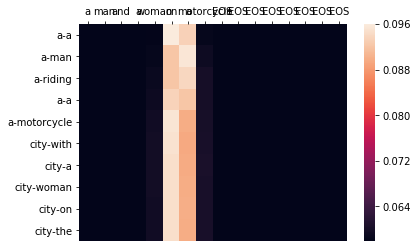

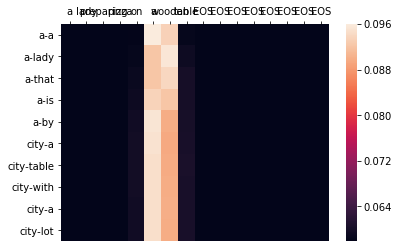

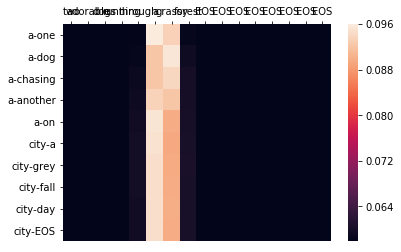

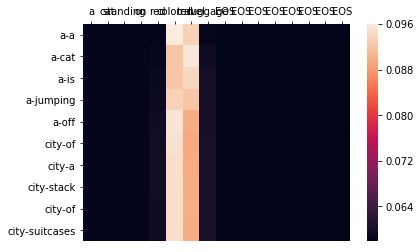

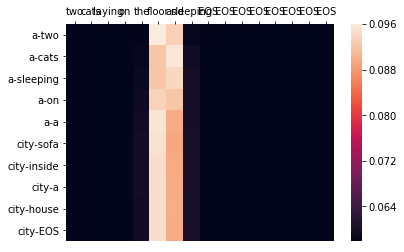



=========== HEATMAPS ==========


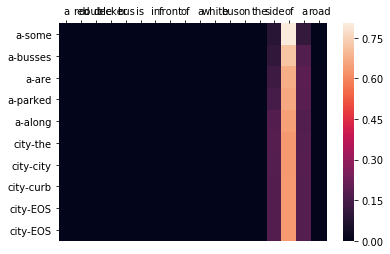

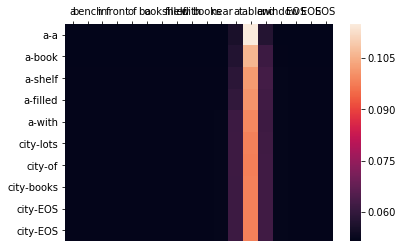

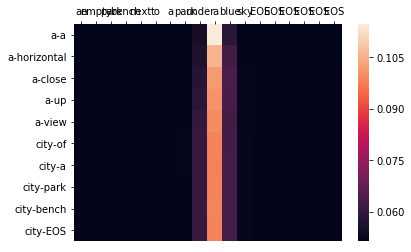

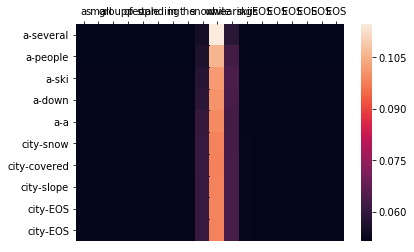

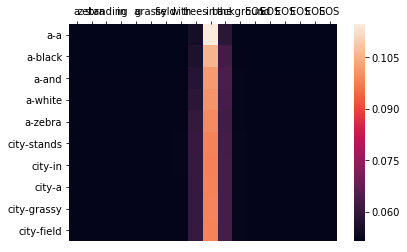

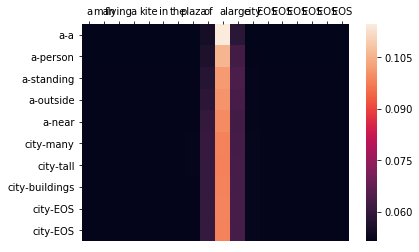

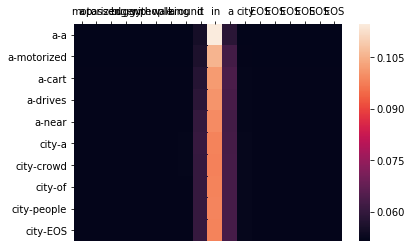

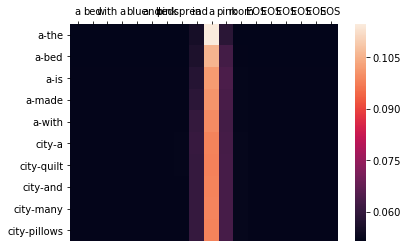

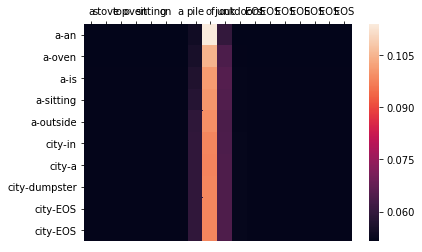

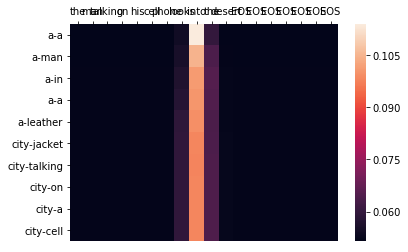

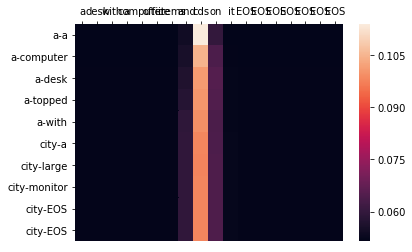

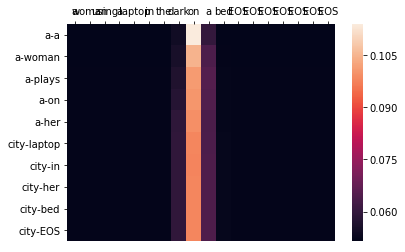

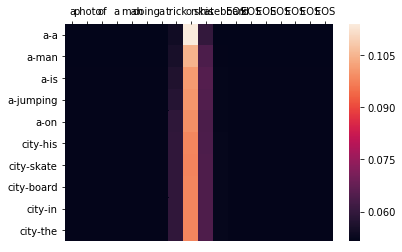

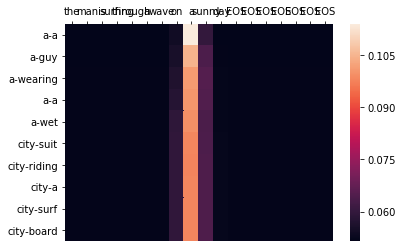

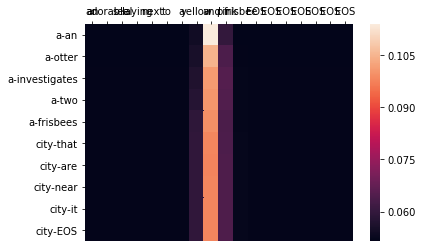

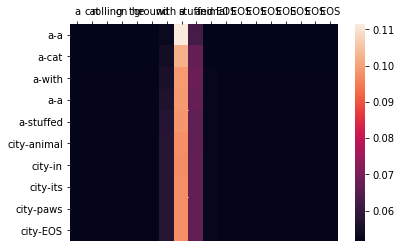

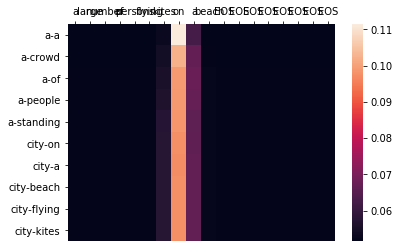

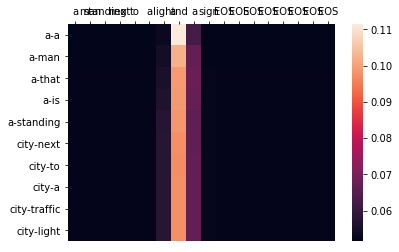

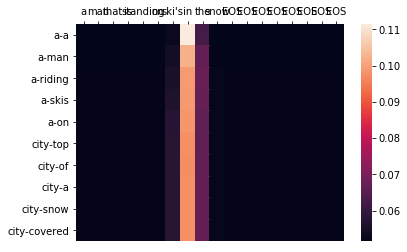

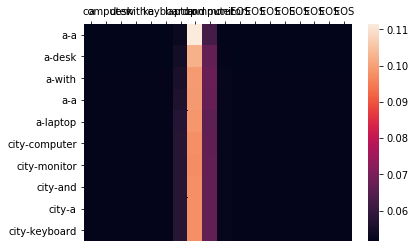

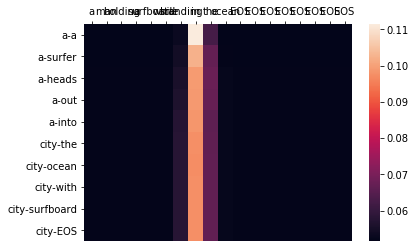

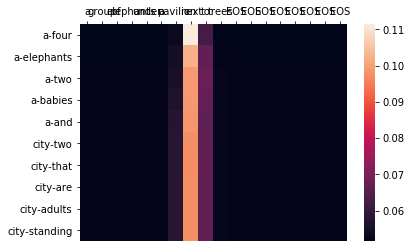

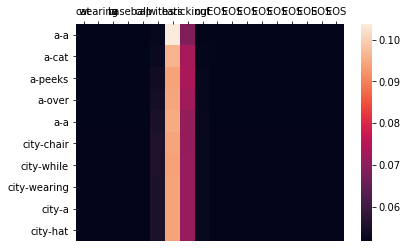

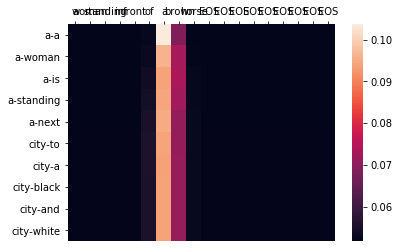

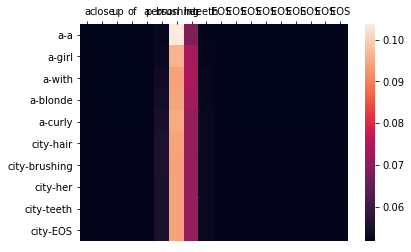

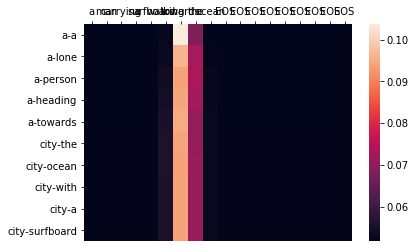

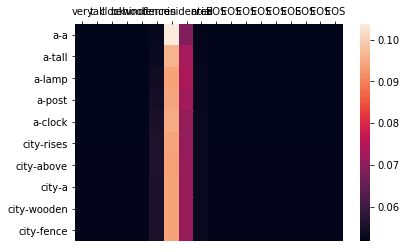

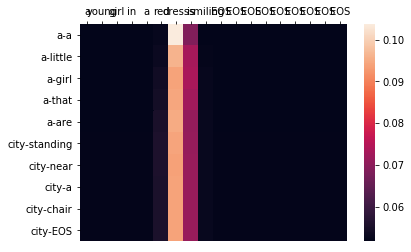

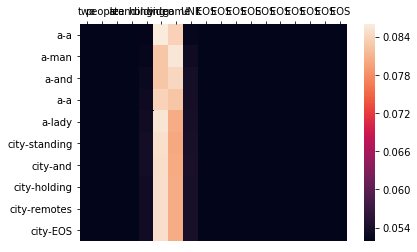

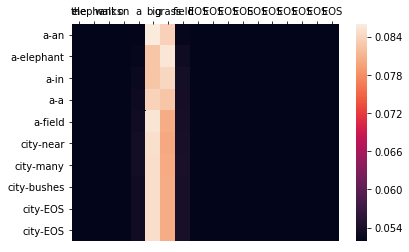

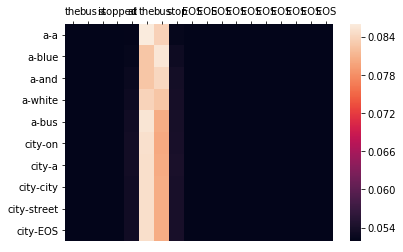

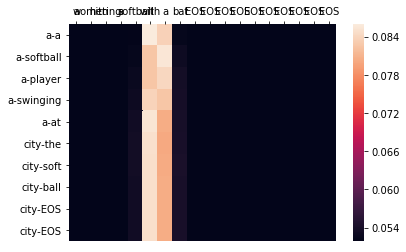



=========== HEATMAPS ==========


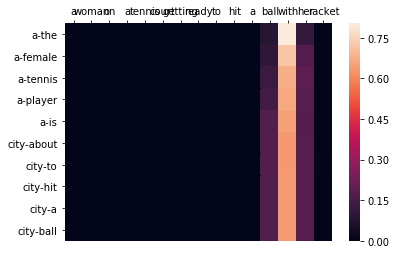

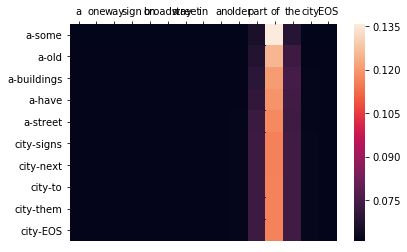

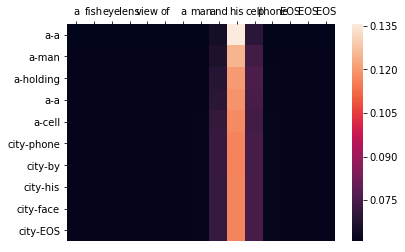

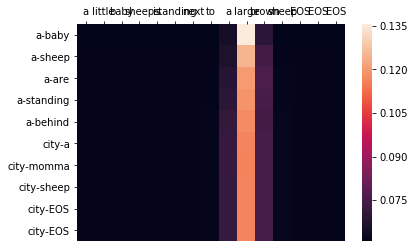

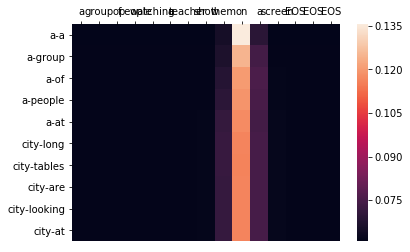

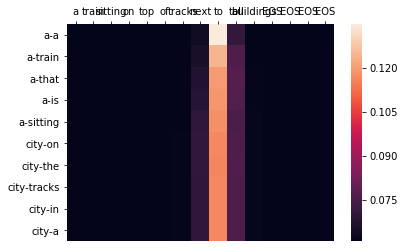

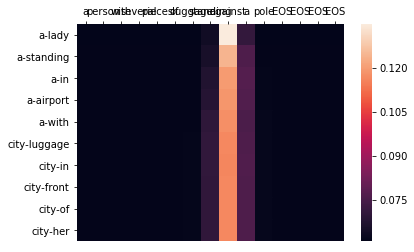

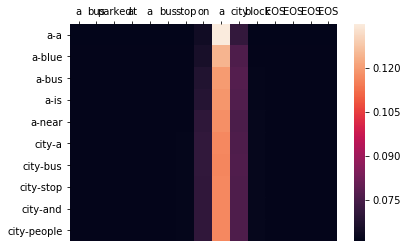

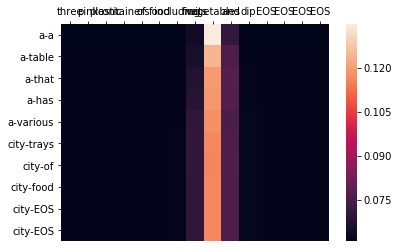

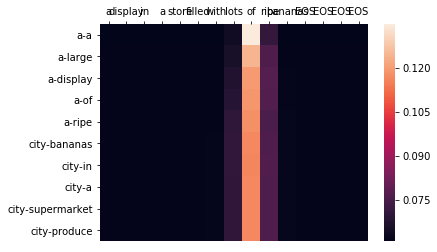

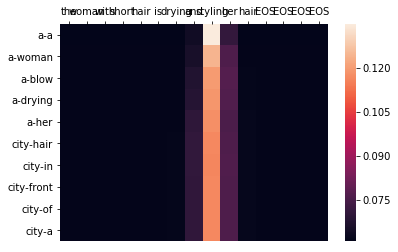

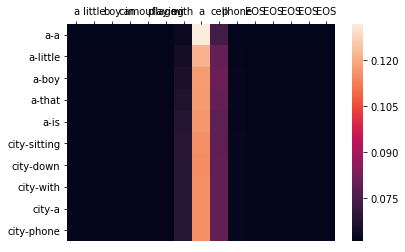

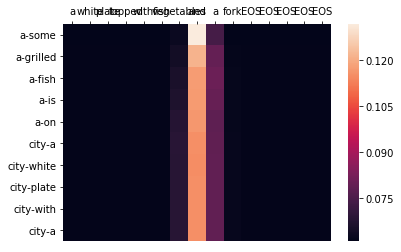

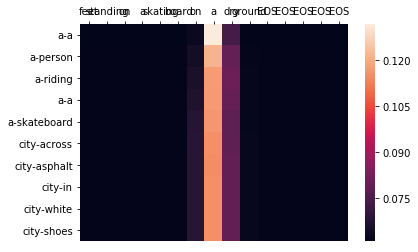

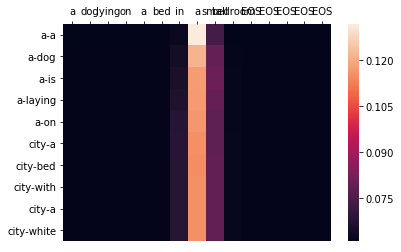

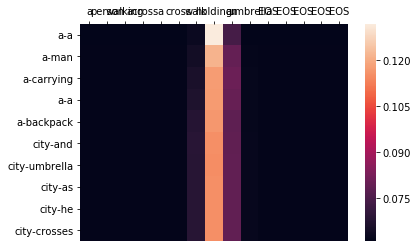

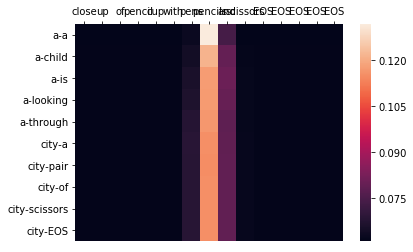

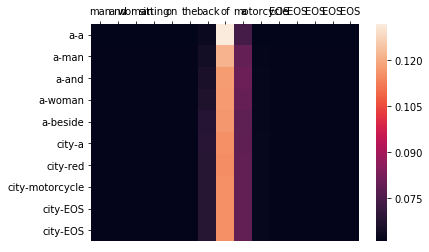

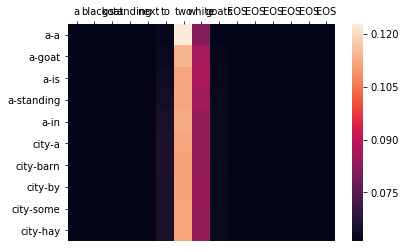

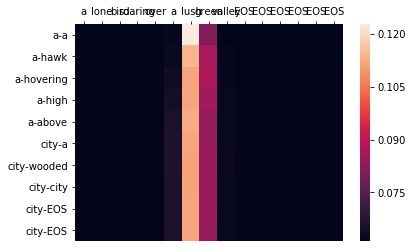

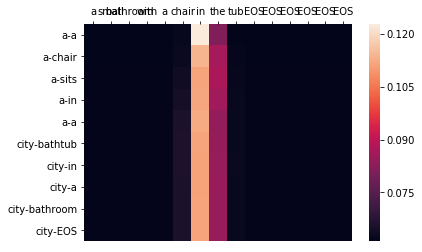

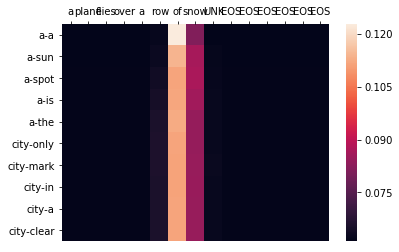

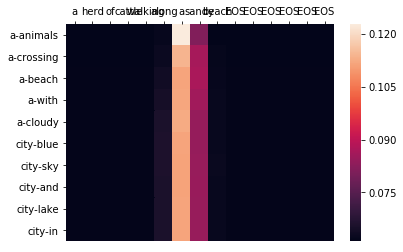

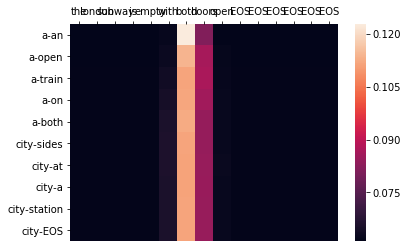

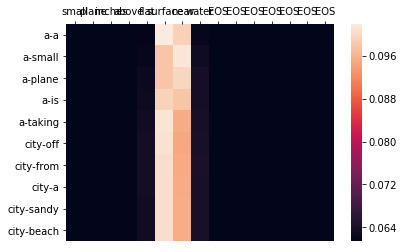

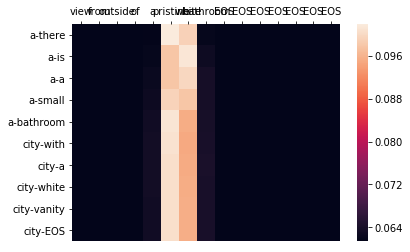

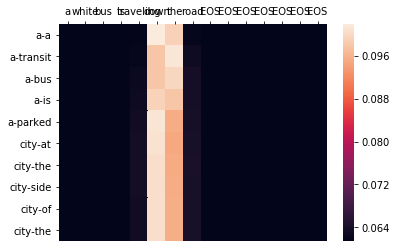

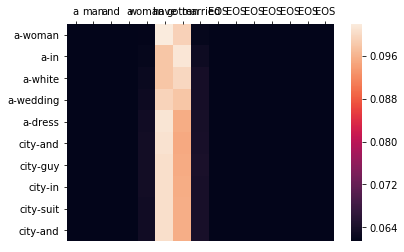

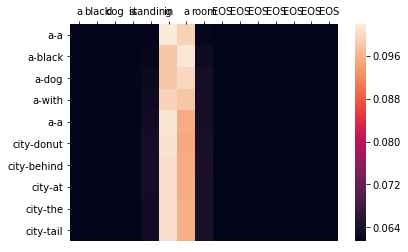

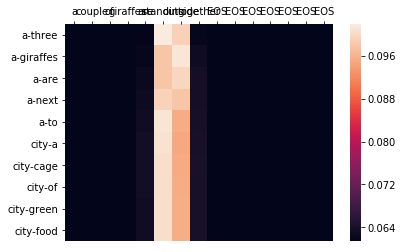

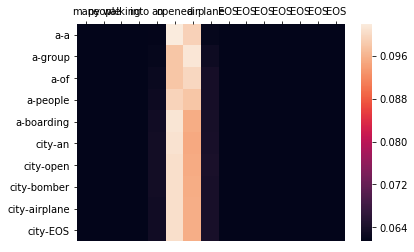

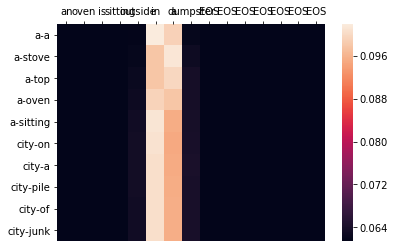



=========== HEATMAPS ==========


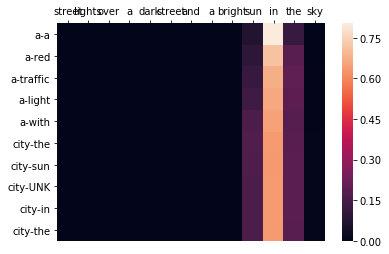

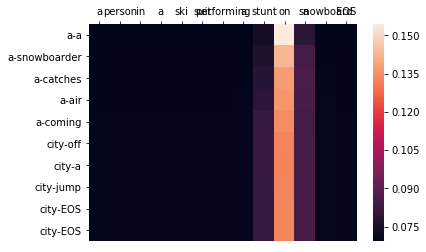

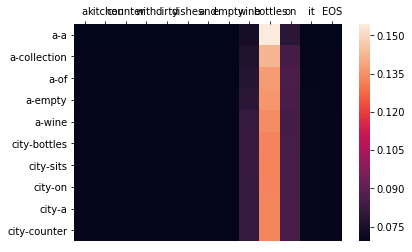

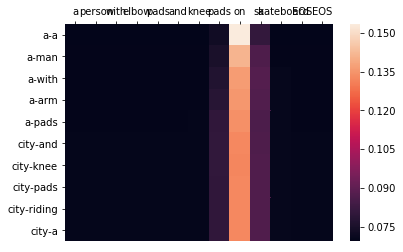

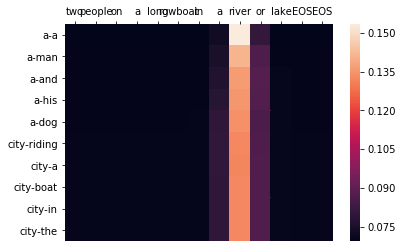

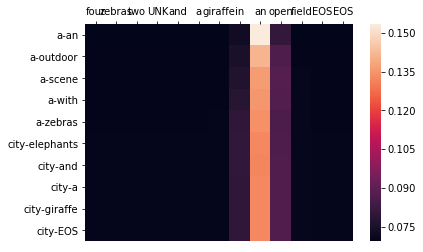

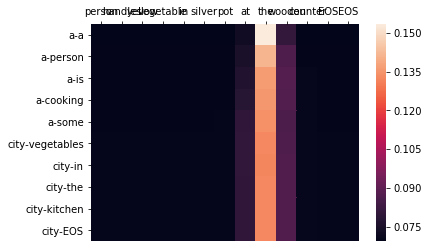

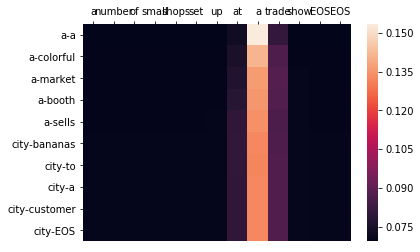

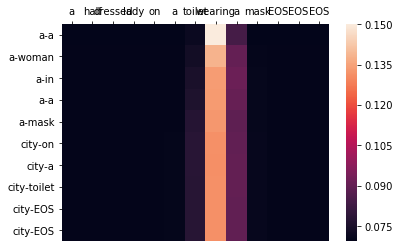

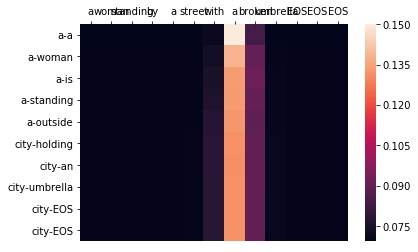

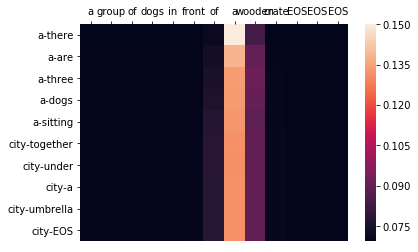

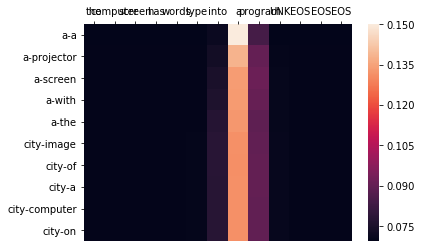

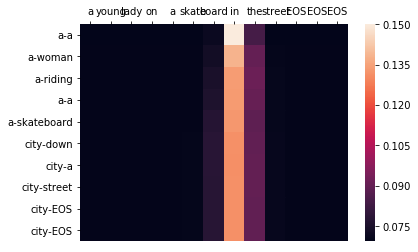

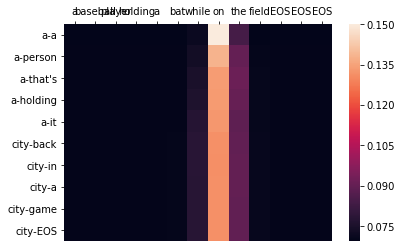

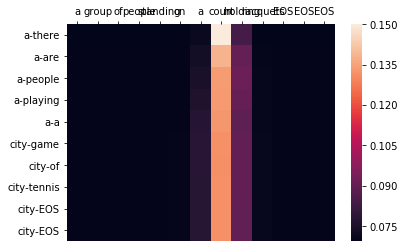

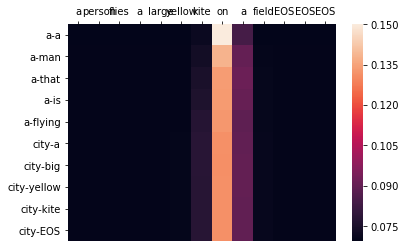

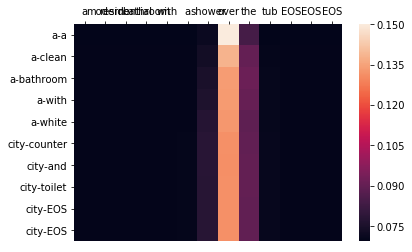

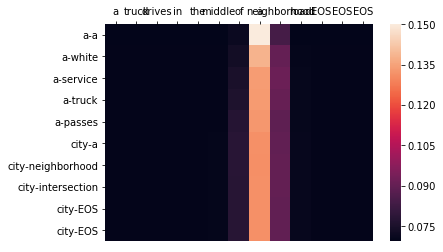

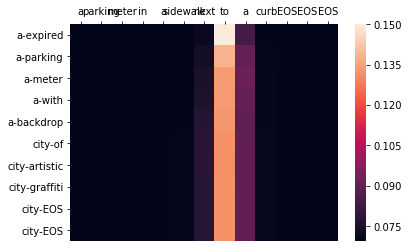

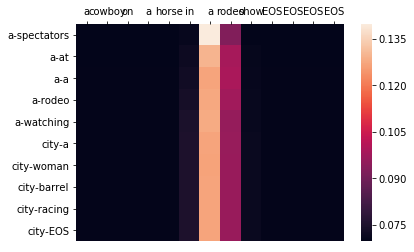

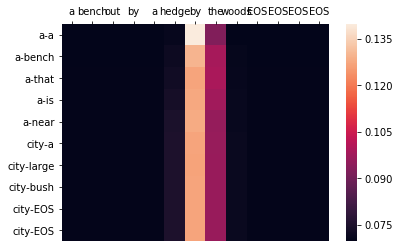

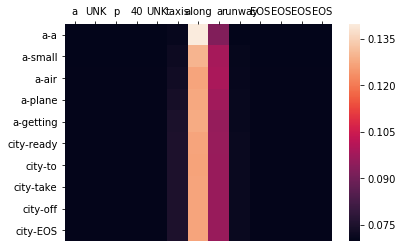

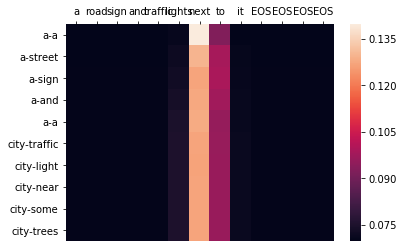

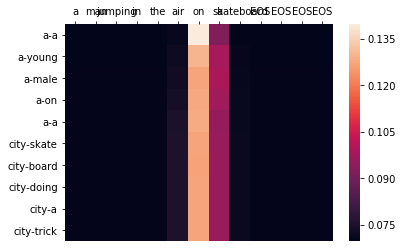

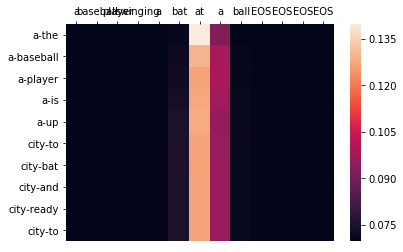

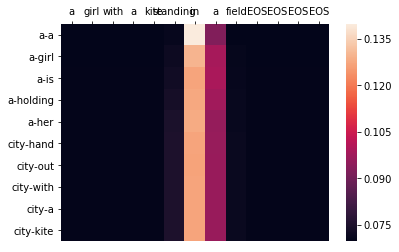

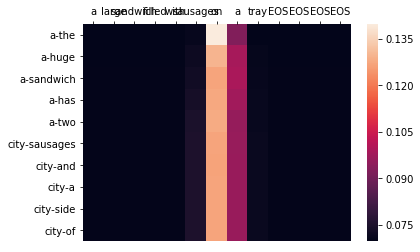

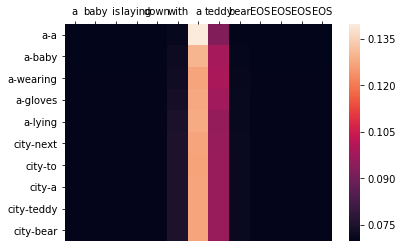

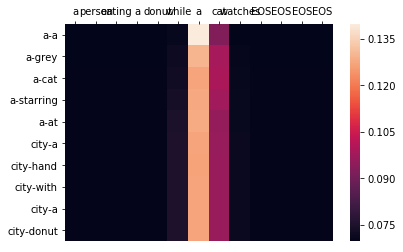

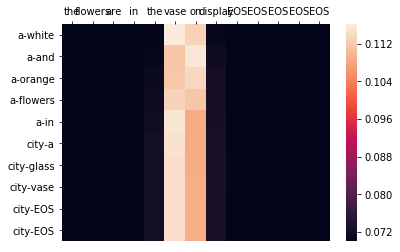

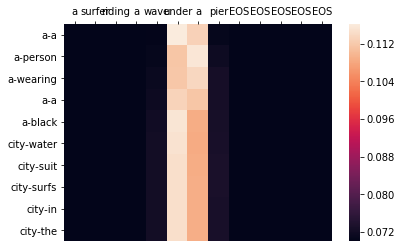

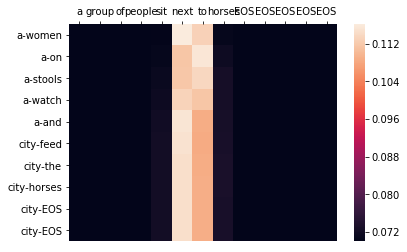



=========== HEATMAPS ==========


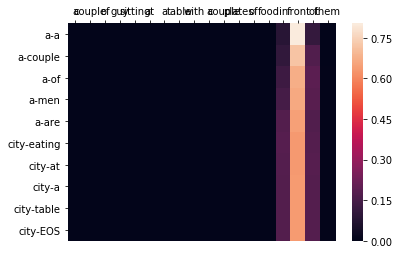

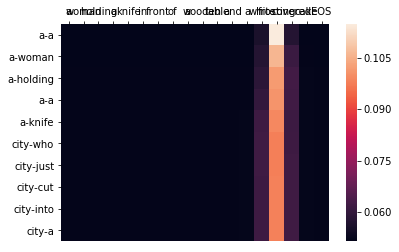

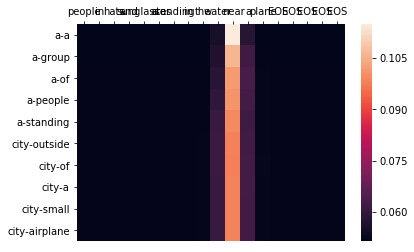

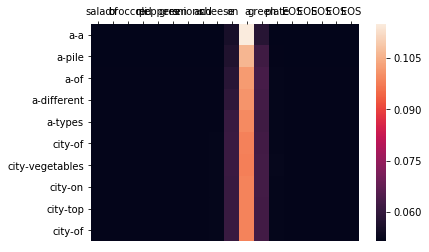

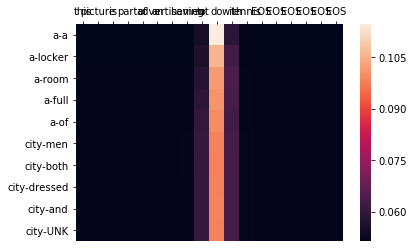

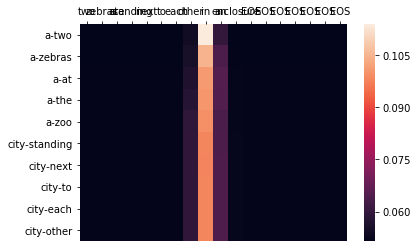

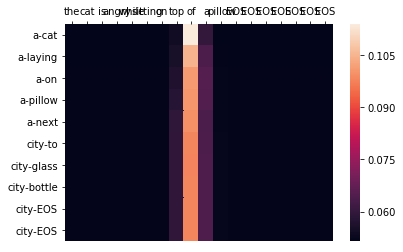

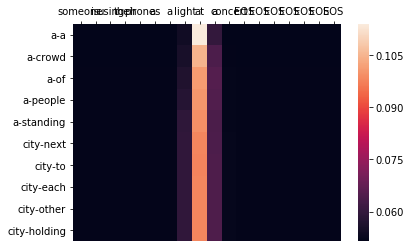

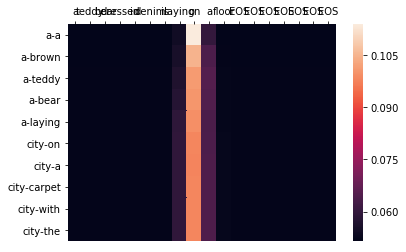

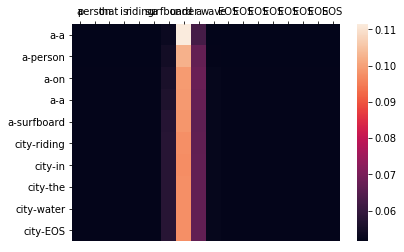

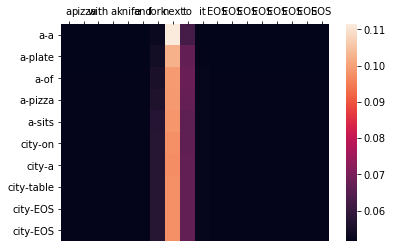

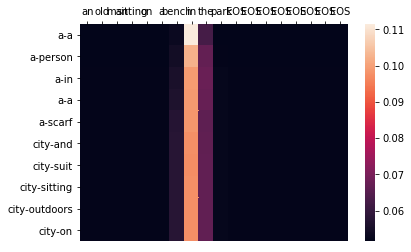

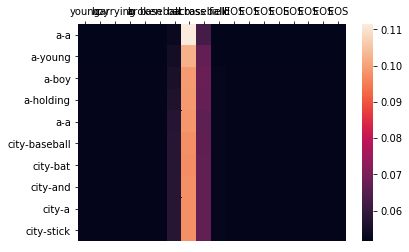

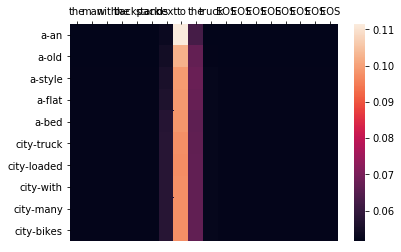

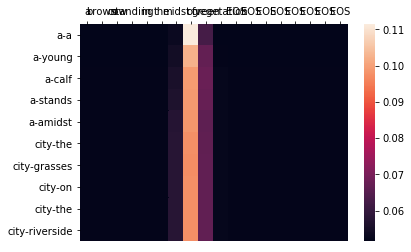

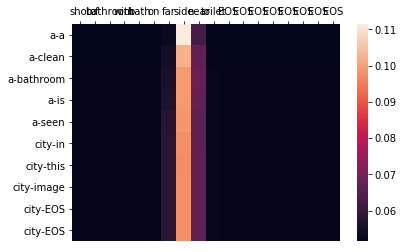

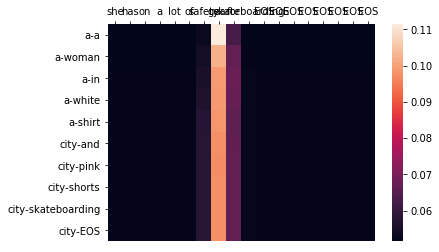

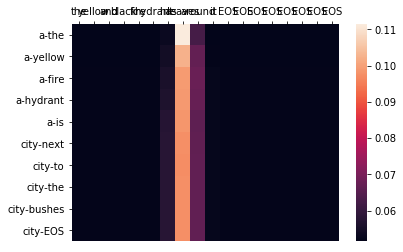

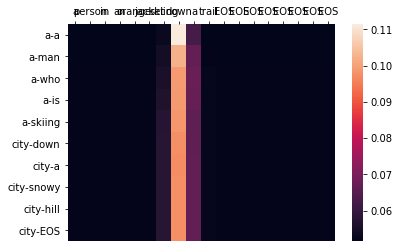

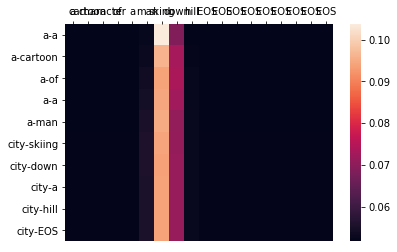

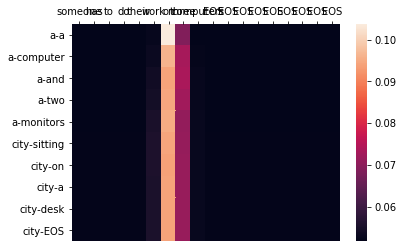

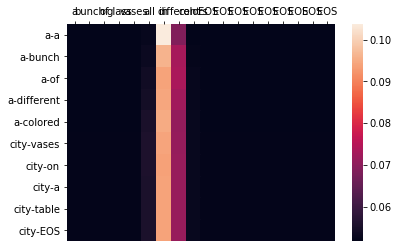

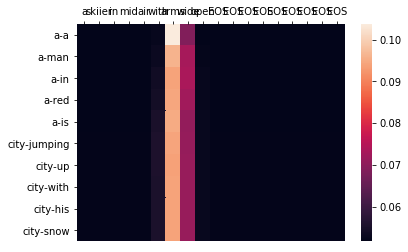

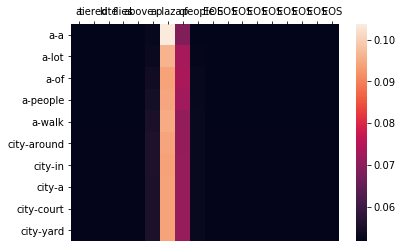

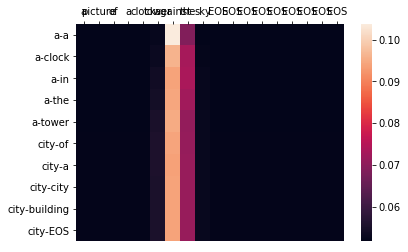

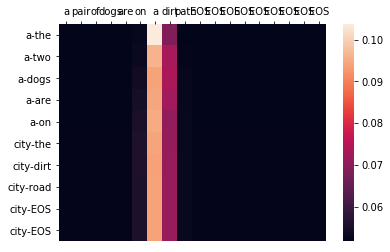

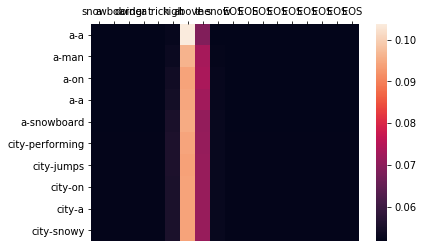

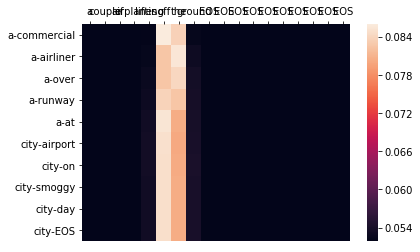

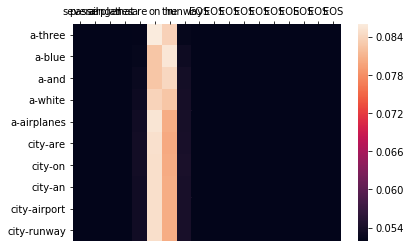

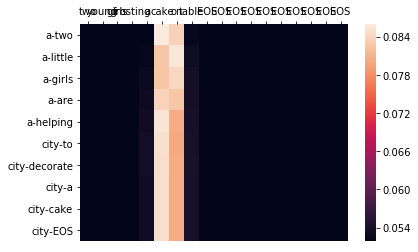

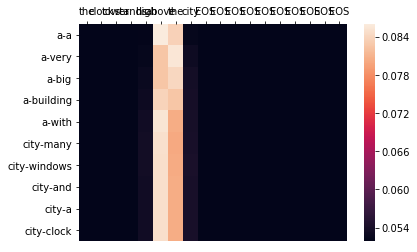

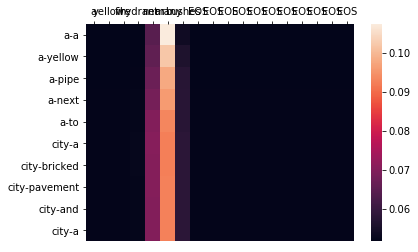



=========== HEATMAPS ==========


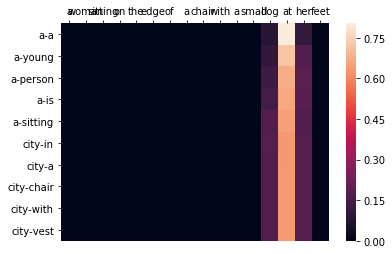

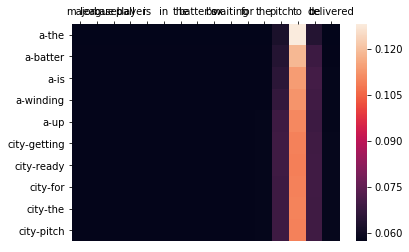

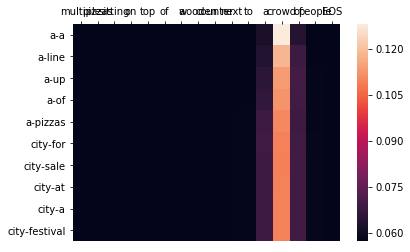

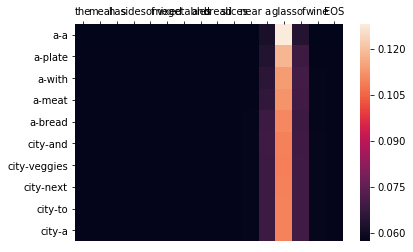

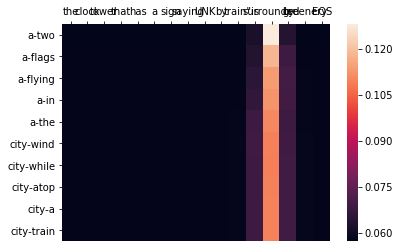

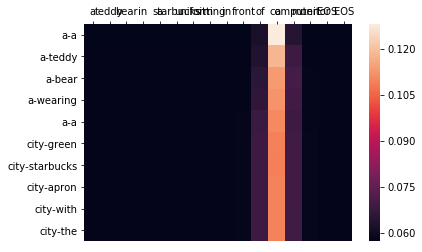

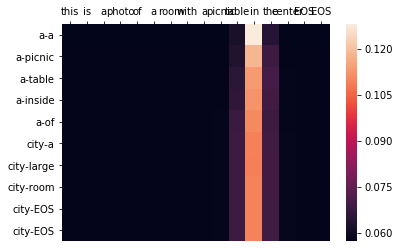

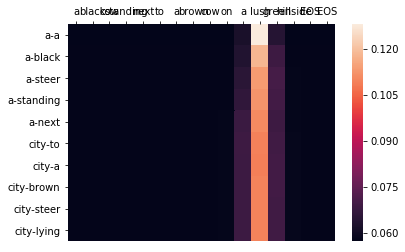

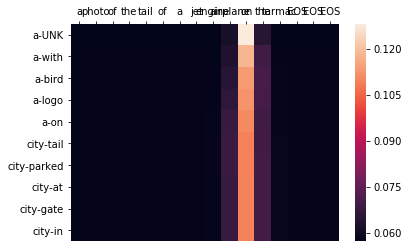

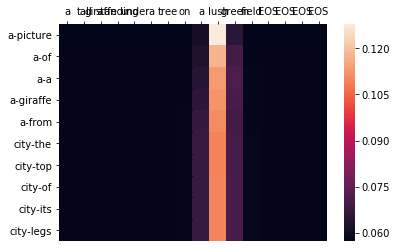

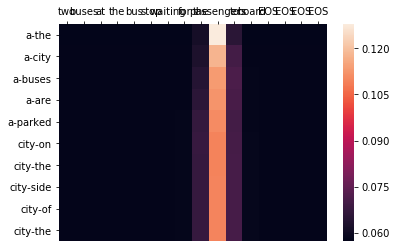

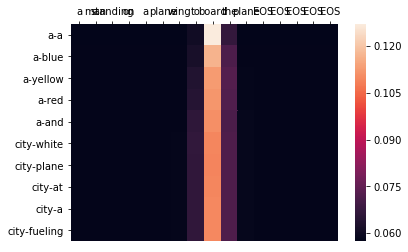

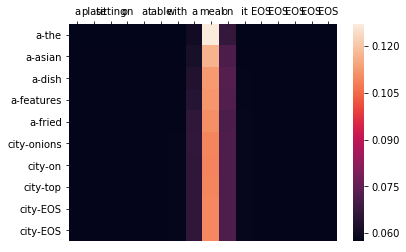

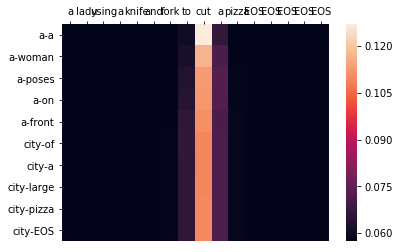

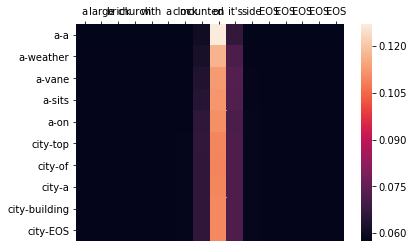

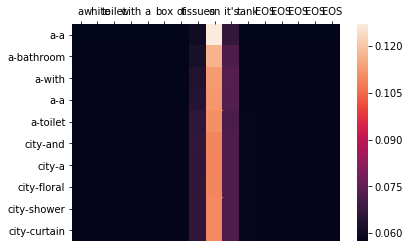

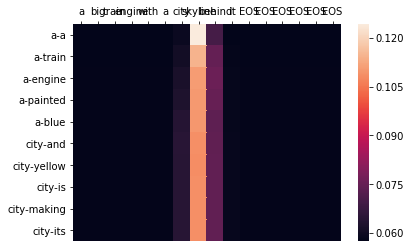

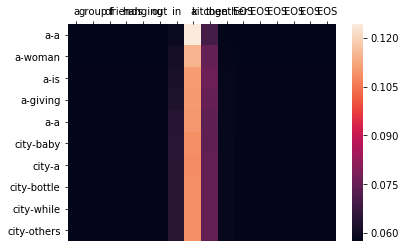

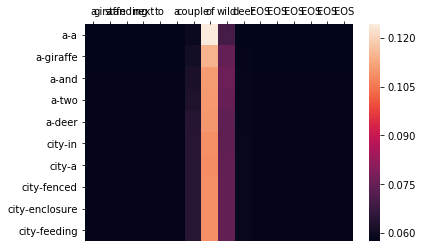

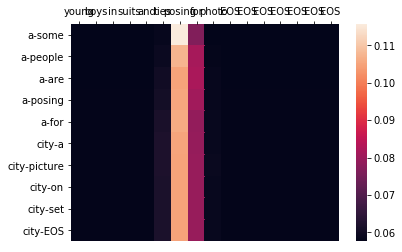

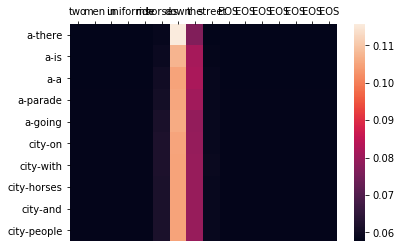

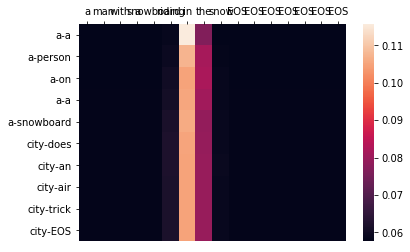

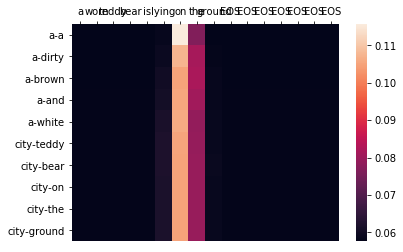

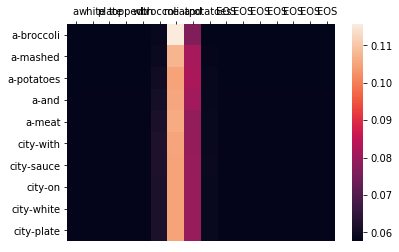

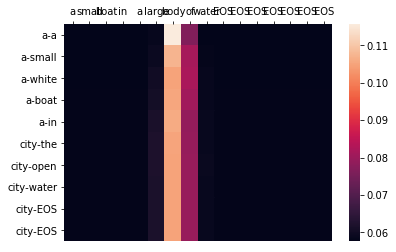

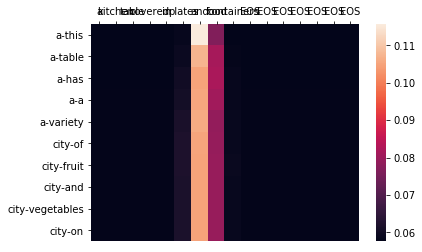

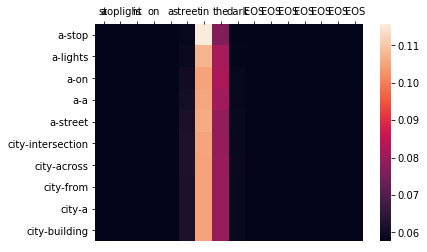

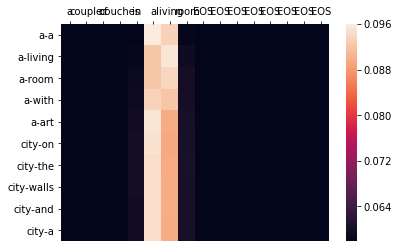

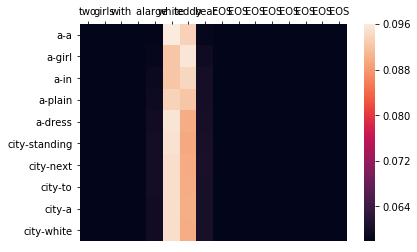

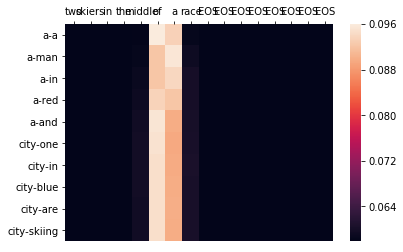

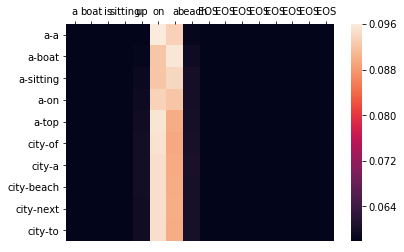

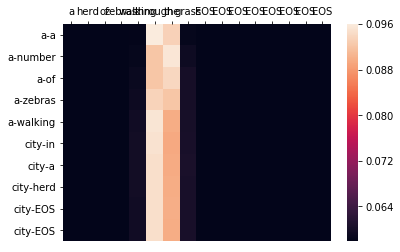



=========== HEATMAPS ==========


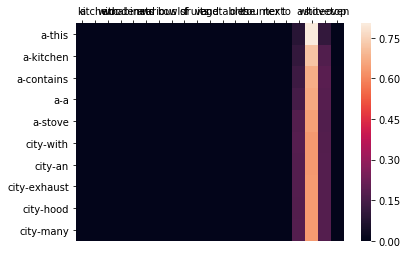

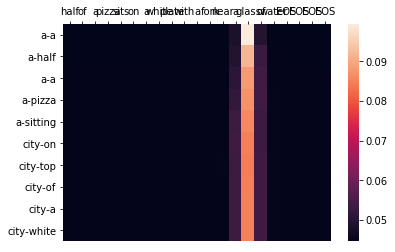

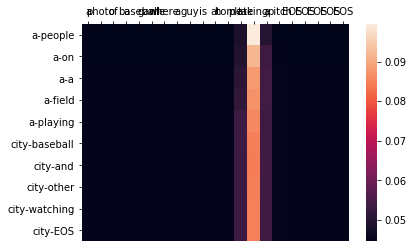

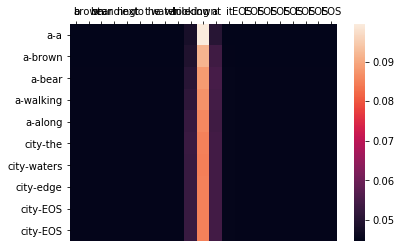

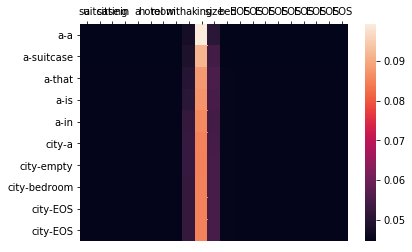

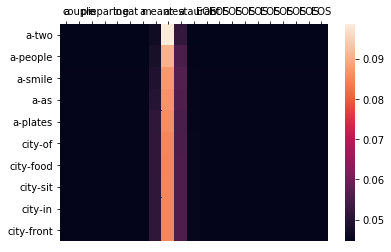

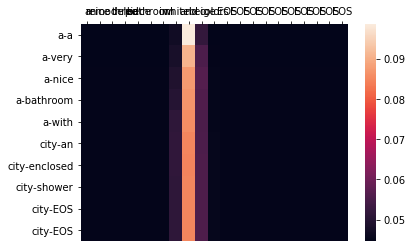

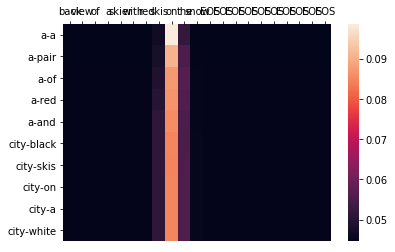

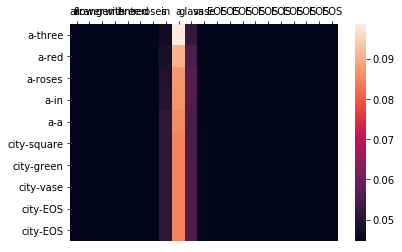

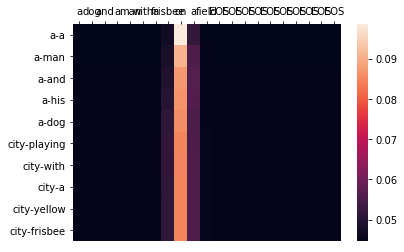

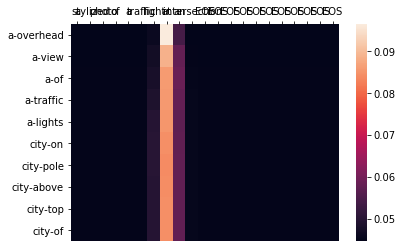

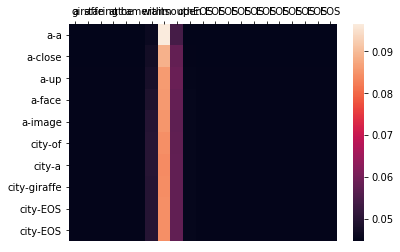

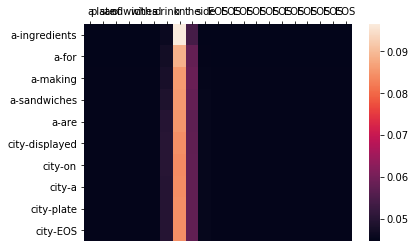

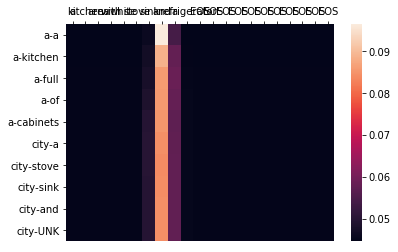

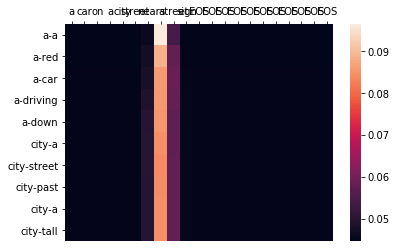

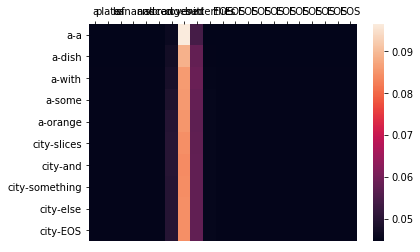

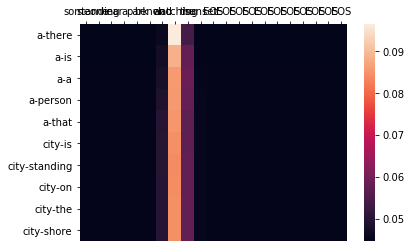

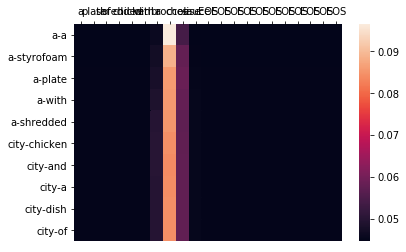

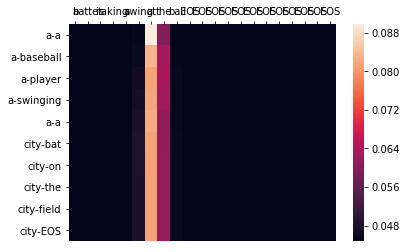

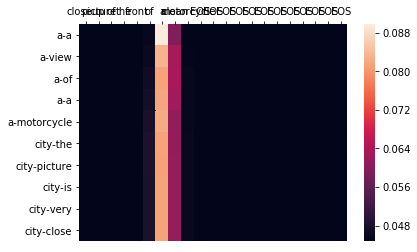

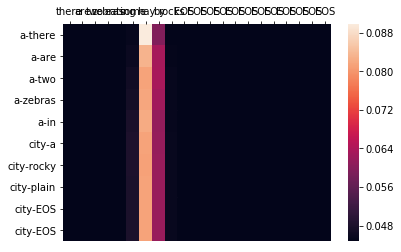

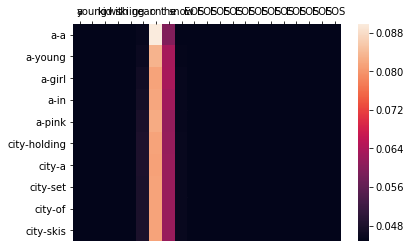

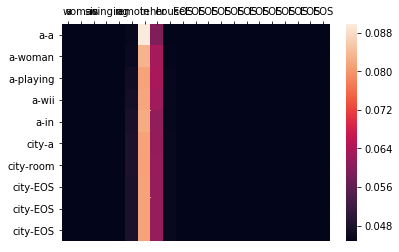

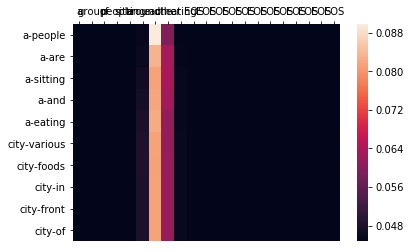

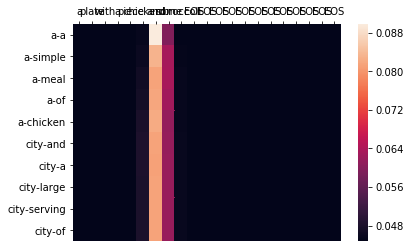

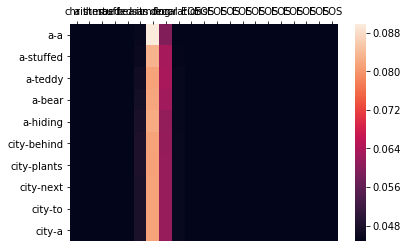

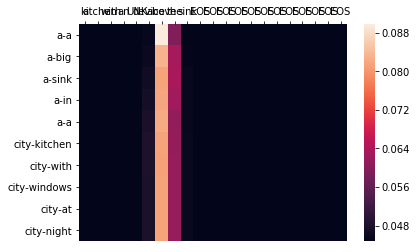

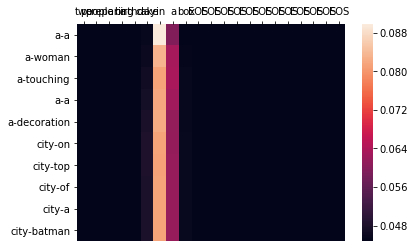

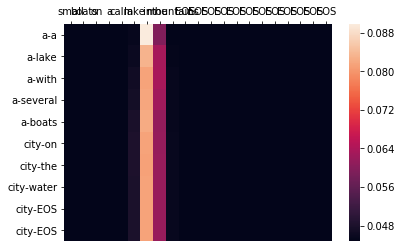

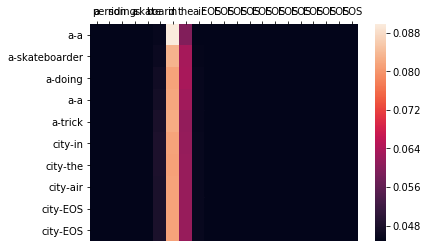

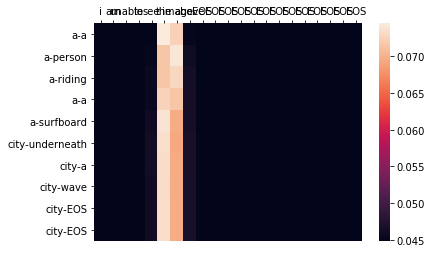

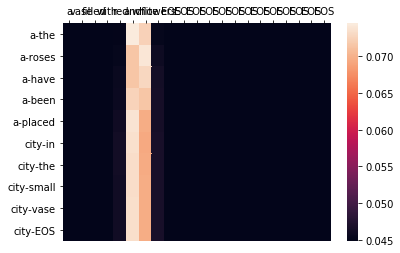



=========== HEATMAPS ==========


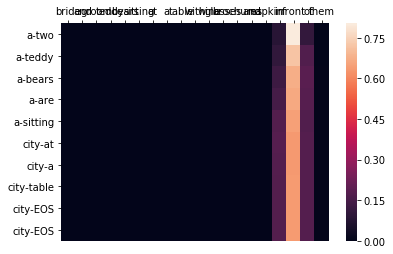

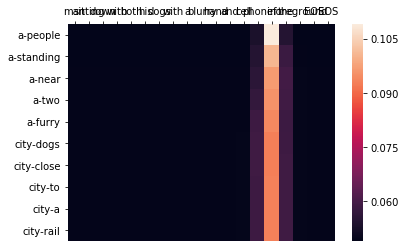

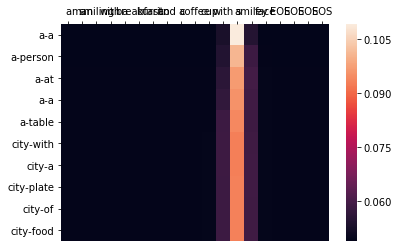

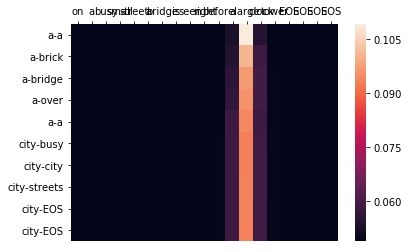

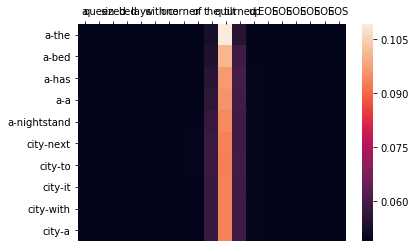

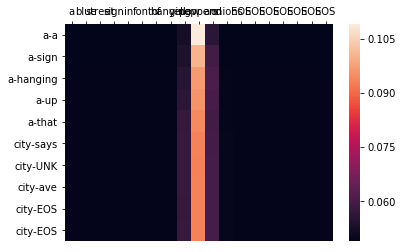

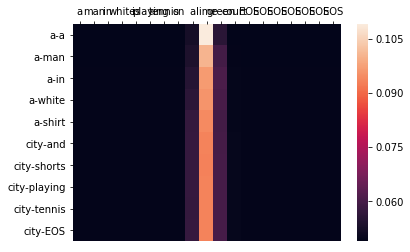

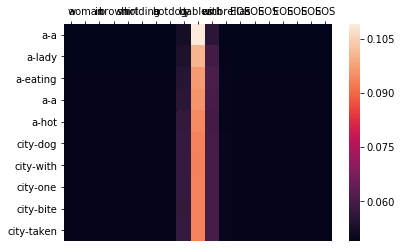

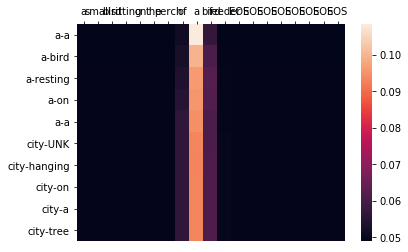

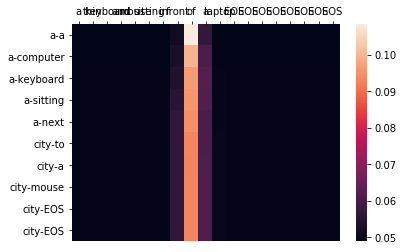

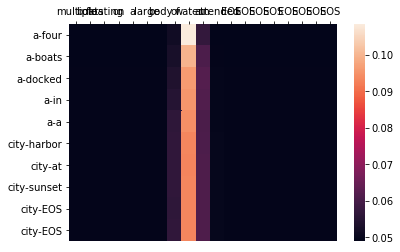

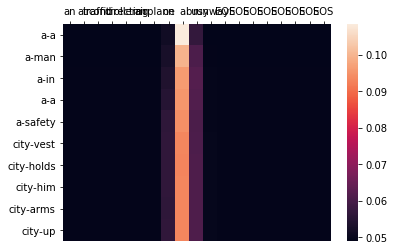

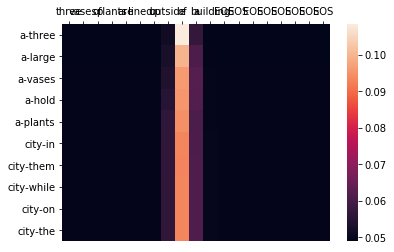

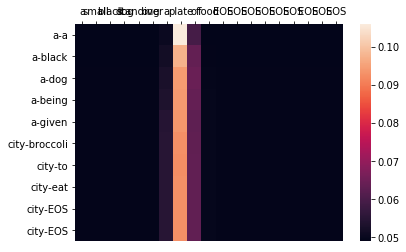

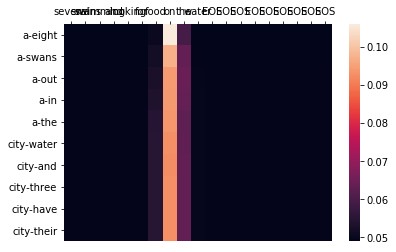

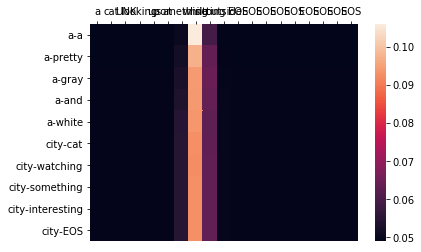

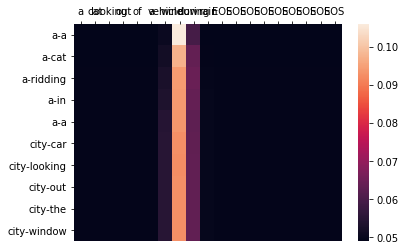

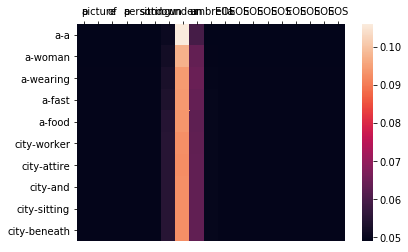

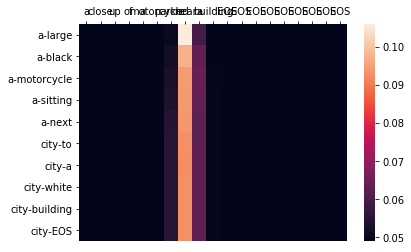

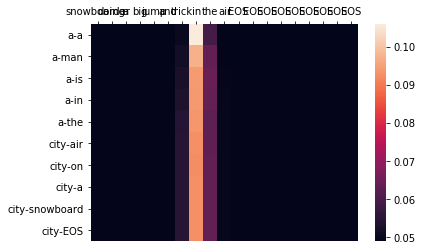

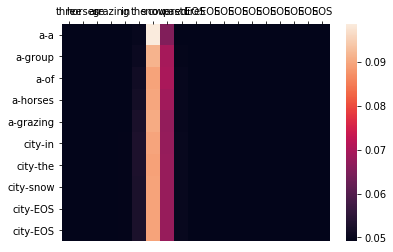

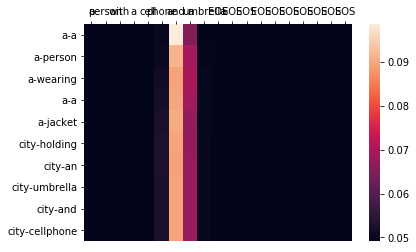

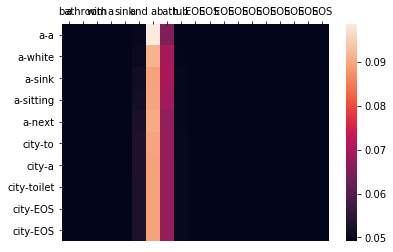

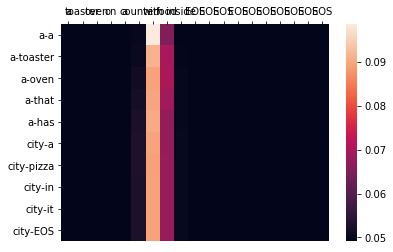

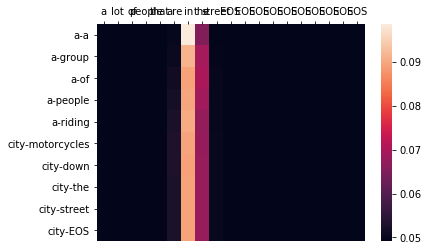

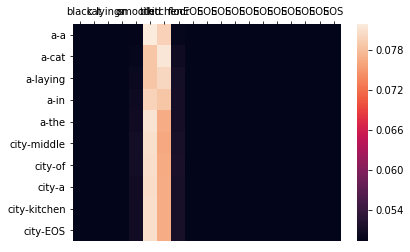

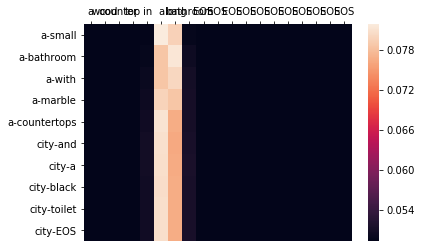

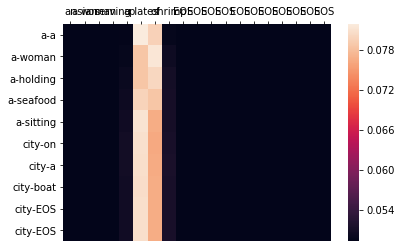

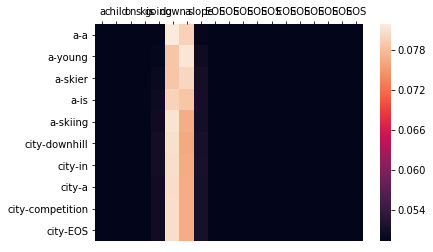

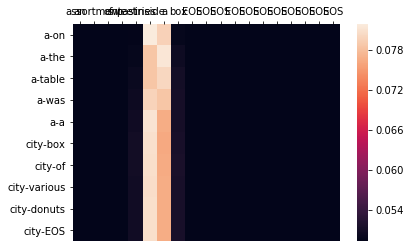

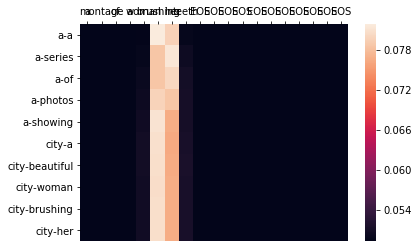

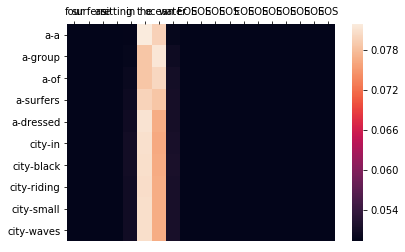



Average BLEU score over 320 examples is 0.0428


/usr/local/lib/python2.7/dist-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type AttentionDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 50min 31s, sys: 15min 52s, total: 1h 6min 24s
Wall time: 47min 37s


In [10]:
%%time

s2s = Seq2Seq(indexer, trainPairs, trainLens, testPairs, testLens,
              embeddings=embeddings,
              batchSize=32, hiddenSize=300, bidirectional=True,
              nLayers=2, dropout=0.3, residual=True, 
              lr=1e-3, lrDecay=0.95, lrDecayFreq=50000000,
              l2Reg=0.001,
              enforcingRatio=0.5, clip=20.0,
              maxDecodingLen=10,
              resultSavePath='mscoco/resultargetsLents.txt')
s2s.train(nEpochs=10, epochSize=1000, printEvery=50)
s2s.evaluate(nBatches=10, saveResults=True)
torch.save(s2s, 'mscoco/seq2seq.ckpt')

In [5]:
diter = DataIterator(indexer,trainPairs,trainLens)

In [6]:
diter.random_batch(2)

(Variable containing:
  5727  5351
  7675   739
  8734  8734
  1253  3149
  1879  1255
  5142  6515
  5510  8739
  3724  3901
  3129  4242
  3901     0
  8262     0
  5295     0
 [torch.LongTensor of size 12x2], array([12,  9]), Variable containing:
  3901  7512
  8262  1879
  2974  5646
  7675  2280
  8734  8915
  7794  5394
  8739  3901
  1253  4242
  4146     0
  5442     0
  5230     0
   843     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
     0     0
 [torch.LongTensor of size 50x2], array([12,  8]))

## SCRIPT

In [ ]:
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_path', help="Path to formatted input to Seq2Seq. See Seq2Seq documentation.",
                        type=str,
                        default='mscoco/mscoco_formatted.p')
    parser.add_argument('--model_save_path', help="Path to saved Seq2Seq model.",
                        type=str,
                        default='mscoco/seq2seq.ckpt')
    parser.add_argument('--result_save_path', help="Path to save results.",
                        type=str, default='mscoco/results.txt')
    parser.add_argument('--clear_prev_result', help="Delete previously output results.",
                        type=bool, default=True)
    parser.add_argument('--batch_size', type=int, default=5)
    parser.add_argument('--hidden_size', type=int, default=10)
    parser.add_argument('--n_layers', type=int, default=2)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--residual', type=bool, default=True)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--lr_decay', type=float, default=0.95)
    parser.add_argument('--lr_dacay_freq', type=int, default=500)
    parser.add_argument('--l2_reg', type=float, default=0.5)
    parser.add_argument('--enforce_ratio', type=float, default=0.5)
    parser.add_argument('--clip', type=float, default=5.0)
    parser.add_argument('--n_epochs', type=int, default=1)
    parser.add_argument('--epoch_size', type=int, default=10)
    parser.add_argument('--print_every', type=int, default=5)
    parser.add_argument('--n_eval_batches', type=int, default=10)
    parser.add_argument('--max_decoding_length', type=int, default=20)
    args = parser.parse_args()
    
    option = raw_input("OPTIONS: (r)etrain)/(c)ontinue).\nr: Retrain new model\nc: Continue training of saved model.\n")
    if option=='r':
        if not os.path.exists(args.data_path):
            dataBuildMsg = """
                Data does not exist. Please make it in the following format:\n
                indexer: Indexer object which has files loaded (each is a file with space-separated words as lines).
                trainPairs, testPairs: each is a list of pairs of word index list.
                trainLens, testLens: each is a list of pairs of length of word index list.\n
                The order is indexer, trainPairs, trainLens, testPairs, testLens. Pickle it with dill.\n
            """
            raise Exception(dataBuildMsg)
        else:
            if os.path.exists(args.model_save_path):
                option = raw_input("Model exists. Hit (c)ontinue to overwrite it, (q)uit to quit.\n")
                if option=='q':
                    exit(0)
            indexer, trainPairs, trainLens, testPairs, testLens = dill.load(open(args.data_path, 'rb'))
            model = Seq2Seq(indexer, trainPairs, trainLens, testPairs, testLens,
                            args.batch_size, args.hidden_size, 
                            args.n_layers, args.dropout, args.residual,
                            args.lr, args.lr_decay, args.lr_decay_freq,
                            args.l2_reg,
                            args.enforce_ratio, args.clip,
                            args.max_decoding_length,
                            args.result_save_path)
    elif option=='c':
        model = torch.load(args.model_save_path)
    else:
        raise Exception("Eneter either r/c.")
        exit(1)
    
    if args.clear_prev_result and os.path.exists(args.result_save_path):
        os.remove(args.result_save_path)
    
    model.train(args.n_epochs, args.epoch_size, args.print_every)
    model.evaluate(args.n_eval_batches)
    torch.save(model, args.model_save_path)